# N:1 MENT — marginal projections

In [1]:
import os
import sys
import time

import numpy as np
import psdist as ps
import psdist.plot as psv
import ultraplot as plt
from tqdm.notebook import tqdm
from tqdm.notebook import trange

import ment
from ment.sim import simulate
from ment.sim import copy_diagnostics
from ment.train.plot import PlotDistCorner
from ment.train.plot import PlotProj1D
from ment.utils import unravel

In [2]:
plt.rc["cmap.discrete"] = False
plt.rc["cmap.sequential"] = "viridis"
plt.rc["figure.facecolor"] = "white"
plt.rc["grid"] = False

## Settings

In [3]:
dist_name = "gaussian_mixture"
ndim = 6
xmax = 3.5
seed = 12345

## Source distribution

In [4]:
dist = ment.dist.get_dist(dist_name, ndim=ndim, seed=seed)
x_true = dist.sample(1_000_000)

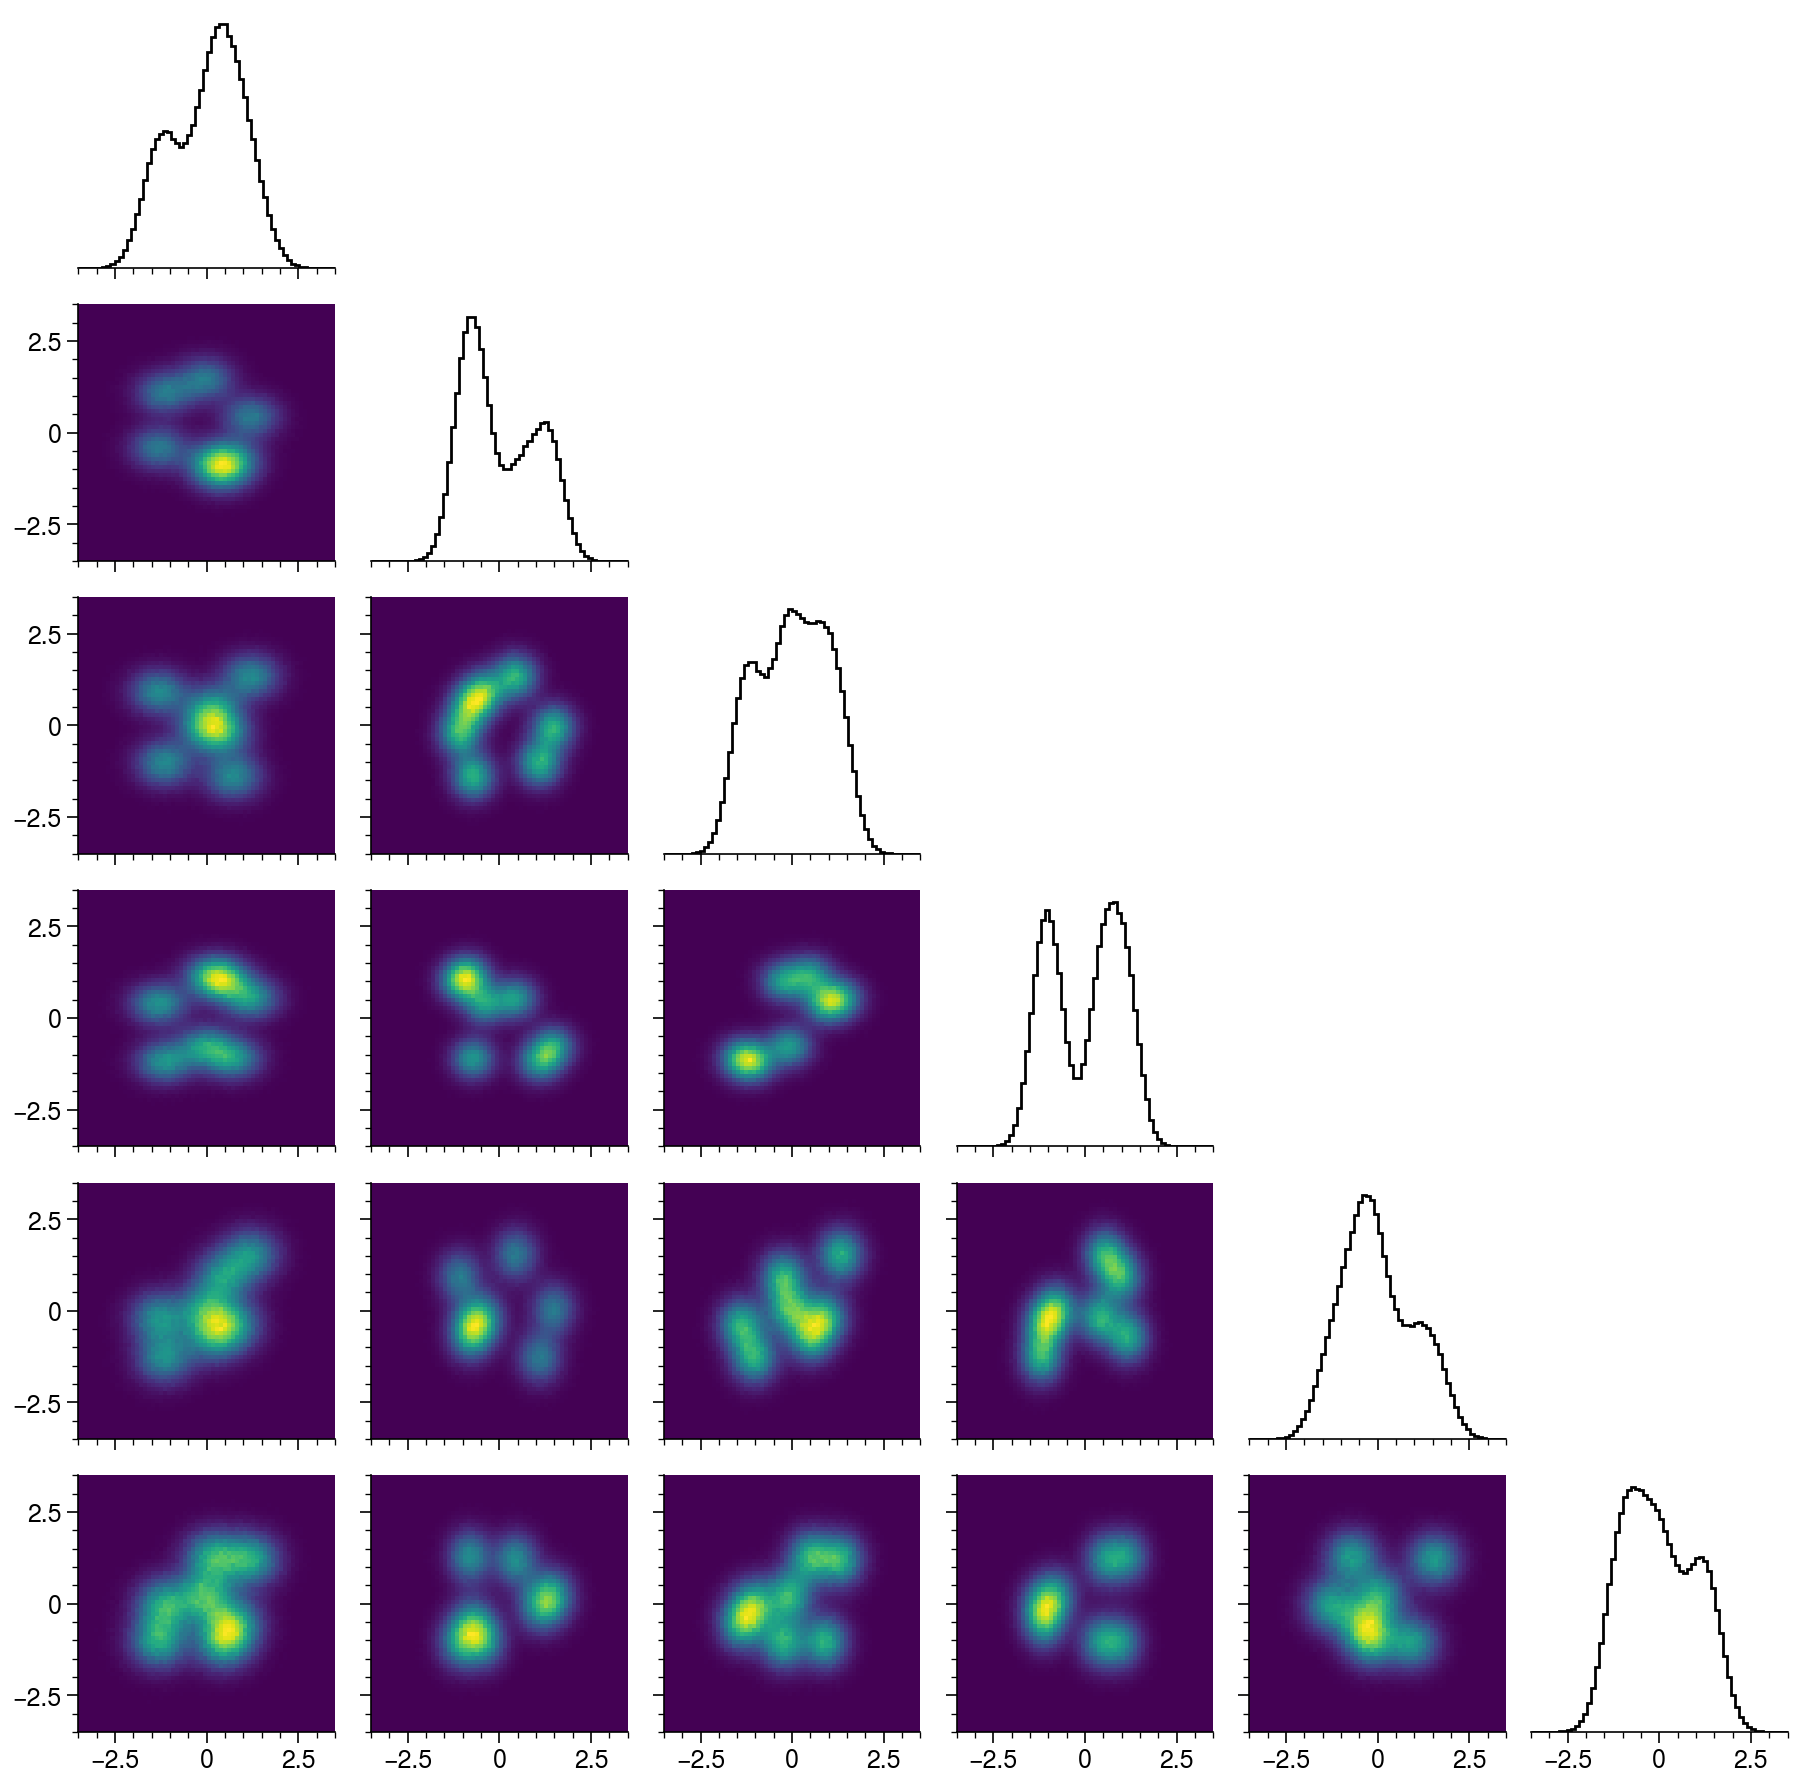

In [5]:
limits = ndim * [(-xmax, xmax)]

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
grid.plot_points(x_true, limits=limits, bins=64, mask=False)
plt.show()

## Data generation

In [6]:
nmeas = 10
nbins = 64
kde = False
kde_bandwidth_frac = 1.0

In [7]:
class ProjectionTransform:
    def __init__(self, direction: np.ndarray) -> None:
        self.direction = direction

    def __call__(self, x: np.ndarray) -> np.ndarray:
        return np.sum(x * self.direction, axis=1)[:, None]

In [8]:
transforms = []
directions = np.random.normal(size=(nmeas, ndim))
for direction in directions:
    direction = np.random.normal(size=ndim)
    direction = direction / np.linalg.norm(direction)
    transform = ProjectionTransform(direction)
    transforms.append(transform)

# Create histogram diagnostics
axis_proj = axis_meas = 0
bin_edges = np.linspace(-xmax, xmax, nbins + 1)

projections = []
for transform in transforms:
    projection = ment.diag.Histogram1D(
        axis=axis_meas, edges=bin_edges, kde=kde, kde_bandwidth_frac=kde_bandwidth_frac
    )
    projections.append([projection])

# Generate data.
projections = ment.sim.simulate_with_diag_update(
    x_true,
    transforms,
    projections,
    kde=False,
    blur=0.0,
)

## Reconstruction model

In [9]:
sampler = "mcmc"
nsamp = 500_000
burnin = 10_000

if sampler == "grid":
    samp_grid_res = 32
    samp_noise = 0.5
    samp_grid_shape = ndim * [samp_grid_res]
    samp_grid_limits = limits

    sampler = ment.samp.GridSampler(
        grid_limits=samp_grid_limits,
        grid_shape=samp_grid_shape,
        noise=samp_noise,
    )
elif sampler == "mcmc":
    sampler = ment.samp.MetropolisHastingsSampler(
        ndim=ndim,
        chains=248,
        proposal_cov=np.eye(ndim),
        burnin=burnin,
        shuffle=True,
        verbose=True,
    )
else:
    raise ValueError

In [10]:
prior = ment.GaussianPrior(ndim=ndim, scale=1.0)

model = ment.MENT(
    ndim=ndim,
    transforms=transforms,
    projections=projections,
    prior=prior,
    interpolation_kws=dict(method="linear"),
    sampler=sampler,
    nsamp=nsamp,
    mode="sample",
    verbose=0,
)

## Training

In [11]:
plot_nsamp = 1_000_000
plot_nbins = 64

In [12]:
def plot_model(model):
    figs = []

    # Plot reconstructed distribution.
    x_pred = model.sample(1_000_000)

    grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.25), diag_shrink=0.80)
    grid.plot(
        x_pred,
        limits=limits,
        bins=65,
        mask=False,
        cmap="viridis",
    )
    figs.append(grid.fig)

    # Plot simulated vs. measured projections.
    projections_true = ment.sim.copy_histograms(model.projections)
    projections_pred = ment.sim.copy_histograms(model.diagnostics)
    projections_pred = ment.sim.simulate(x_pred, transforms, projections_pred)

    ncols = min(nmeas, 7)
    nrows = int(np.ceil(nmeas / ncols))

    for log in [False, True]:
        fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(1.5 * ncols, 1.25 * nrows))
        for index, transform in enumerate(transforms):
            projection_true = unravel(projections_true)[index]
            projection_pred = unravel(projections_pred)[index]

            scale = np.max(projection_true.values.max())

            ax = axs[index]
            ax.plot(projection_true.coords, projection_true.values / scale, color="lightgray")
            ax.plot(
                projection_pred.coords,
                projection_pred.values / scale,
                color="black",
                marker=".",
                lw=0,
                ms=1.0,
            )
            ax.format(ymax=1.25, xlim=(-xmax, xmax))
            if log:
                ax.format(yscale="log", ymax=5.0, ymin=1.00e-05, yformatter="log")
        figs.append(fig)

    return figs

non numeric history values being saved


  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  2%|█▉                                                                                                            | 240/14031 [00:00<00:05, 2398.09it/s]

  3%|███▊                                                                                                          | 483/14031 [00:00<00:05, 2412.30it/s]

  5%|█████▋                                                                                                        | 726/14031 [00:00<00:05, 2419.78it/s]

  7%|███████▌                                                                                                      | 969/14031 [00:00<00:05, 2422.20it/s]

  9%|█████████▍                                                                                                   | 1212/14031 [00:00<00:05, 2420.76it/s]

 10%|███████████▎                                                                                                 | 1455/14031 [00:00<00:05, 2418.66it/s]

 12%|█████████████▏                                                                                               | 1697/14031 [00:00<00:05, 2415.24it/s]

 14%|███████████████                                                                                              | 1939/14031 [00:00<00:05, 2414.45it/s]

 16%|████████████████▉                                                                                            | 2181/14031 [00:00<00:04, 2413.34it/s]

 17%|██████████████████▊                                                                                          | 2423/14031 [00:01<00:04, 2397.13it/s]

 19%|████████████████████▋                                                                                        | 2663/14031 [00:01<00:04, 2342.50it/s]

 21%|██████████████████████▌                                                                                      | 2898/14031 [00:01<00:04, 2316.23it/s]

 22%|████████████████████████▎                                                                                    | 3137/14031 [00:01<00:04, 2335.54it/s]

 24%|██████████████████████████▏                                                                                  | 3371/14031 [00:01<00:04, 2333.40it/s]

 26%|████████████████████████████                                                                                 | 3611/14031 [00:01<00:04, 2353.13it/s]

 27%|█████████████████████████████▉                                                                               | 3856/14031 [00:01<00:04, 2380.07it/s]

 29%|███████████████████████████████▊                                                                             | 4098/14031 [00:01<00:04, 2389.48it/s]

 31%|█████████████████████████████████▋                                                                           | 4341/14031 [00:01<00:04, 2399.26it/s]

 33%|███████████████████████████████████▌                                                                         | 4585/14031 [00:01<00:03, 2410.82it/s]

 34%|█████████████████████████████████████▌                                                                       | 4828/14031 [00:02<00:03, 2414.19it/s]

 36%|███████████████████████████████████████▍                                                                     | 5071/14031 [00:02<00:03, 2418.01it/s]

 38%|█████████████████████████████████████████▎                                                                   | 5315/14031 [00:02<00:03, 2423.80it/s]

 40%|███████████████████████████████████████████▏                                                                 | 5560/14031 [00:02<00:03, 2428.82it/s]

 41%|█████████████████████████████████████████████                                                                | 5803/14031 [00:02<00:03, 2422.35it/s]

 43%|██████████████████████████████████████████████▉                                                              | 6046/14031 [00:02<00:03, 2384.23it/s]

 45%|████████████████████████████████████████████████▊                                                            | 6285/14031 [00:02<00:03, 2341.28it/s]

 46%|██████████████████████████████████████████████████▋                                                          | 6520/14031 [00:02<00:03, 2328.28it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 6760/14031 [00:02<00:03, 2348.02it/s]

 50%|██████████████████████████████████████████████████████▍                                                      | 7000/14031 [00:02<00:02, 2360.67it/s]

 52%|████████████████████████████████████████████████████████▎                                                    | 7242/14031 [00:03<00:02, 2377.94it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 7484/14031 [00:03<00:02, 2389.45it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 7728/14031 [00:03<00:02, 2402.84it/s]

 57%|█████████████████████████████████████████████████████████████▉                                               | 7972/14031 [00:03<00:02, 2411.81it/s]

 59%|███████████████████████████████████████████████████████████████▊                                             | 8215/14031 [00:03<00:02, 2417.03it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 8458/14031 [00:03<00:02, 2420.46it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 8701/14031 [00:03<00:02, 2418.97it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 8943/14031 [00:03<00:02, 2419.15it/s]

 65%|███████████████████████████████████████████████████████████████████████▎                                     | 9186/14031 [00:03<00:02, 2422.04it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 9429/14031 [00:03<00:01, 2424.12it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 9672/14031 [00:04<00:01, 2423.78it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 9915/14031 [00:04<00:01, 2422.30it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                             | 10159/14031 [00:04<00:01, 2424.89it/s]

 74%|████████████████████████████████████████████████████████████████████████████████                            | 10402/14031 [00:04<00:01, 2424.35it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 10645/14031 [00:04<00:01, 2425.08it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 10888/14031 [00:04<00:01, 2425.43it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 11131/14031 [00:04<00:01, 2425.78it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 11374/14031 [00:04<00:01, 2426.18it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 11617/14031 [00:04<00:00, 2427.25it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 11860/14031 [00:04<00:00, 2427.76it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 12103/14031 [00:05<00:00, 2427.90it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 12347/14031 [00:05<00:00, 2429.69it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 12592/14031 [00:05<00:00, 2433.31it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▊         | 12836/14031 [00:05<00:00, 2433.12it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 13080/14031 [00:05<00:00, 2432.31it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 13324/14031 [00:05<00:00, 2430.27it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 13568/14031 [00:05<00:00, 2432.12it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 13812/14031 [00:05<00:00, 2432.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2405.61it/s]

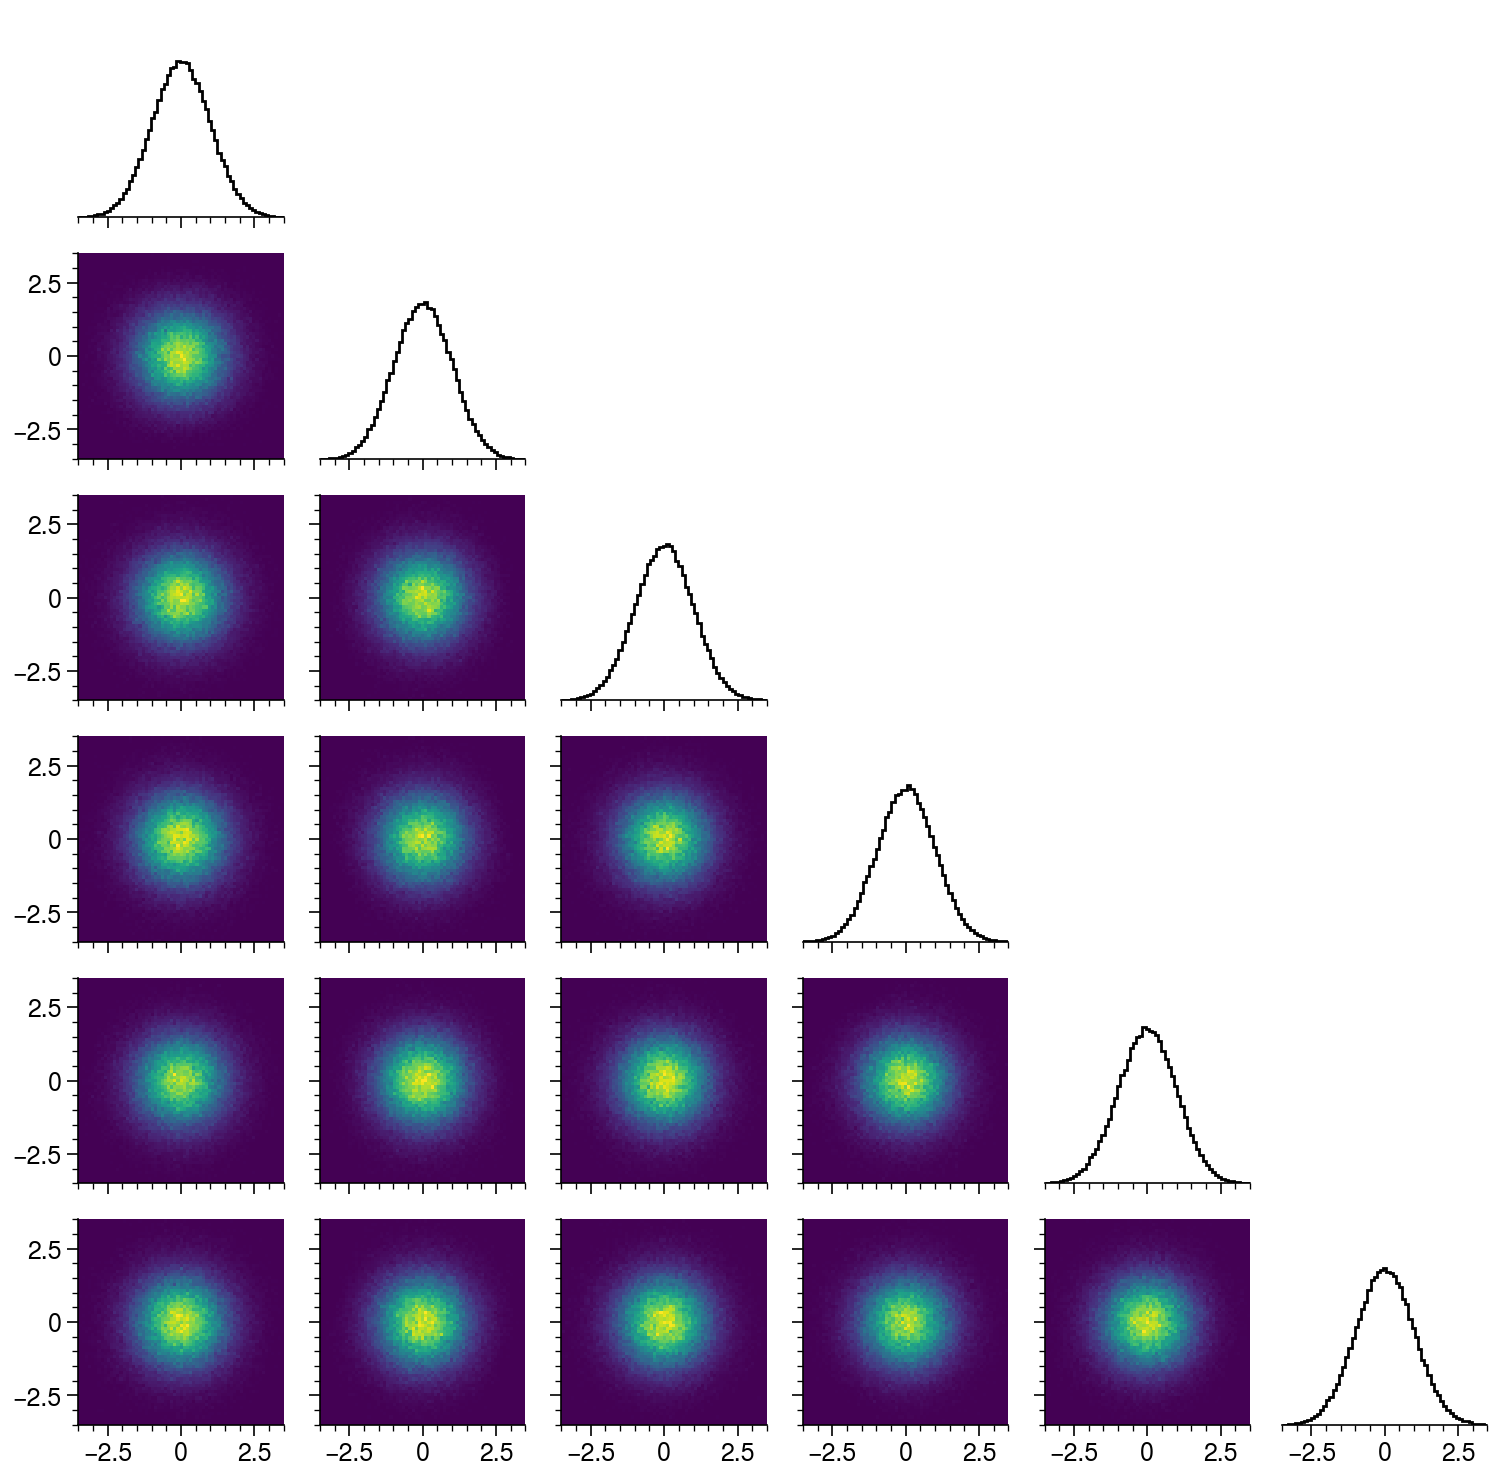

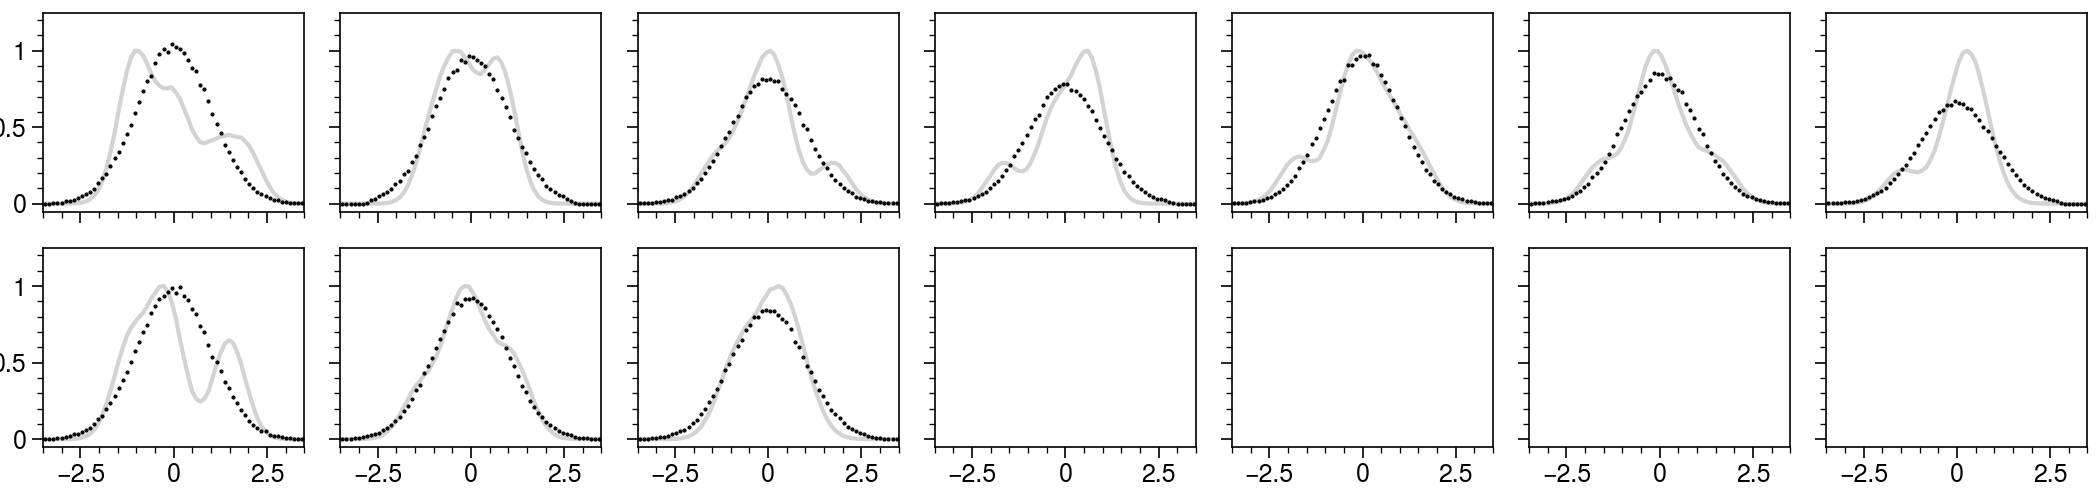

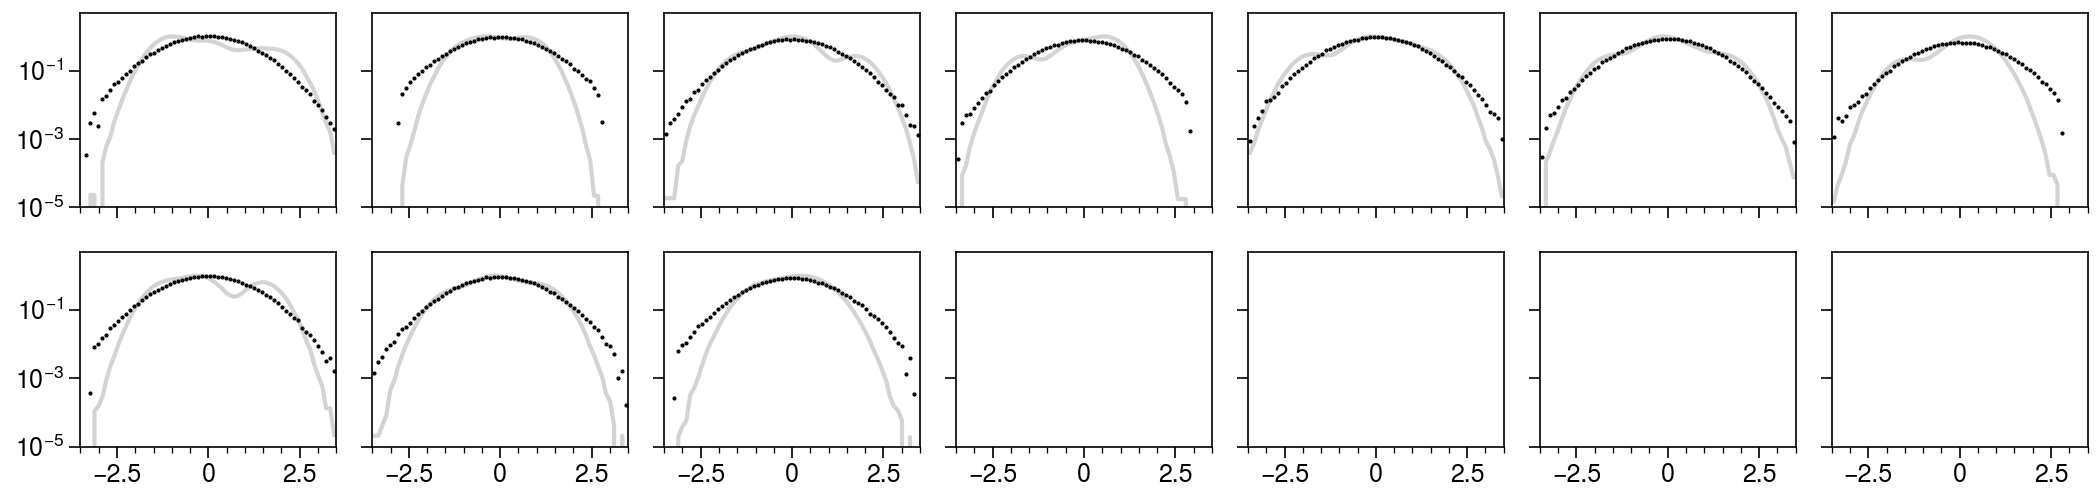

None
epoch = 1


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██                                                                                                            | 221/12015 [00:00<00:05, 2206.91it/s]

  4%|████                                                                                                          | 450/12015 [00:00<00:05, 2253.02it/s]

  6%|██████▏                                                                                                       | 682/12015 [00:00<00:04, 2279.41it/s]

  8%|████████▎                                                                                                     | 912/12015 [00:00<00:04, 2286.47it/s]

  9%|██████████▎                                                                                                  | 1141/12015 [00:00<00:04, 2265.43it/s]

 11%|████████████▍                                                                                                | 1376/12015 [00:00<00:04, 2293.77it/s]

 13%|██████████████▋                                                                                              | 1616/12015 [00:00<00:04, 2327.53it/s]

 15%|████████████████▊                                                                                            | 1854/12015 [00:00<00:04, 2343.03it/s]

 17%|███████████████████                                                                                          | 2096/12015 [00:00<00:04, 2365.99it/s]

 19%|█████████████████████▏                                                                                       | 2336/12015 [00:01<00:04, 2373.87it/s]

 21%|███████████████████████▍                                                                                     | 2578/12015 [00:01<00:03, 2385.01it/s]

 23%|█████████████████████████▌                                                                                   | 2817/12015 [00:01<00:03, 2384.65it/s]

 25%|███████████████████████████▋                                                                                 | 3056/12015 [00:01<00:03, 2383.03it/s]

 27%|█████████████████████████████▉                                                                               | 3297/12015 [00:01<00:03, 2389.14it/s]

 29%|████████████████████████████████                                                                             | 3536/12015 [00:01<00:03, 2387.89it/s]

 31%|██████████████████████████████████▎                                                                          | 3776/12015 [00:01<00:03, 2391.50it/s]

 33%|████████████████████████████████████▍                                                                        | 4017/12015 [00:01<00:03, 2396.38it/s]

 35%|██████████████████████████████████████▌                                                                      | 4257/12015 [00:01<00:03, 2385.35it/s]

 37%|████████████████████████████████████████▊                                                                    | 4496/12015 [00:01<00:03, 2385.37it/s]

 39%|██████████████████████████████████████████▉                                                                  | 4735/12015 [00:02<00:03, 2386.29it/s]

 41%|█████████████████████████████████████████████▏                                                               | 4977/12015 [00:02<00:02, 2394.63it/s]

 43%|███████████████████████████████████████████████▎                                                             | 5218/12015 [00:02<00:02, 2398.14it/s]

 45%|█████████████████████████████████████████████████▌                                                           | 5458/12015 [00:02<00:02, 2378.85it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 5696/12015 [00:02<00:02, 2375.76it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 5934/12015 [00:02<00:02, 2375.55it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 6172/12015 [00:02<00:02, 2376.59it/s]

 53%|██████████████████████████████████████████████████████████▏                                                  | 6411/12015 [00:02<00:02, 2377.96it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 6649/12015 [00:02<00:02, 2376.87it/s]

 57%|██████████████████████████████████████████████████████████████▍                                              | 6888/12015 [00:02<00:02, 2379.41it/s]

 59%|████████████████████████████████████████████████████████████████▋                                            | 7127/12015 [00:03<00:02, 2380.16it/s]

 61%|██████████████████████████████████████████████████████████████████▊                                          | 7366/12015 [00:03<00:01, 2377.40it/s]

 63%|████████████████████████████████████████████████████████████████████▉                                        | 7605/12015 [00:03<00:01, 2379.16it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 7843/12015 [00:03<00:01, 2374.94it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 8081/12015 [00:03<00:01, 2375.14it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 8319/12015 [00:03<00:01, 2374.84it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▋                               | 8557/12015 [00:03<00:01, 2374.57it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▊                             | 8797/12015 [00:03<00:01, 2379.73it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 9035/12015 [00:03<00:01, 2378.08it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████                         | 9273/12015 [00:03<00:01, 2374.51it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▎                      | 9511/12015 [00:04<00:01, 2363.35it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▍                    | 9748/12015 [00:04<00:00, 2364.73it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 9987/12015 [00:04<00:00, 2371.65it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 10225/12015 [00:04<00:00, 2372.93it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 10464/12015 [00:04<00:00, 2377.36it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 10703/12015 [00:04<00:00, 2379.64it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 10944/12015 [00:04<00:00, 2387.59it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11186/12015 [00:04<00:00, 2395.15it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 11426/12015 [00:04<00:00, 2393.06it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 11667/12015 [00:04<00:00, 2396.82it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 11907/12015 [00:05<00:00, 2395.25it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2371.61it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 242/12015 [00:00<00:04, 2411.61it/s]

  4%|████▍                                                                                                         | 484/12015 [00:00<00:04, 2397.05it/s]

  6%|██████▋                                                                                                       | 724/12015 [00:00<00:04, 2398.06it/s]

  8%|████████▊                                                                                                     | 964/12015 [00:00<00:04, 2398.69it/s]

 10%|██████████▉                                                                                                  | 1204/12015 [00:00<00:04, 2396.24it/s]

 12%|█████████████                                                                                                | 1445/12015 [00:00<00:04, 2400.31it/s]

 14%|███████████████▎                                                                                             | 1686/12015 [00:00<00:04, 2401.01it/s]

 16%|█████████████████▍                                                                                           | 1928/12015 [00:00<00:04, 2405.96it/s]

 18%|███████████████████▋                                                                                         | 2170/12015 [00:00<00:04, 2409.83it/s]

 20%|█████████████████████▊                                                                                       | 2411/12015 [00:01<00:03, 2406.63it/s]

 22%|████████████████████████                                                                                     | 2653/12015 [00:01<00:03, 2408.72it/s]

 24%|██████████████████████████▎                                                                                  | 2895/12015 [00:01<00:03, 2409.39it/s]

 26%|████████████████████████████▍                                                                                | 3136/12015 [00:01<00:03, 2407.22it/s]

 28%|██████████████████████████████▋                                                                              | 3378/12015 [00:01<00:03, 2408.99it/s]

 30%|████████████████████████████████▊                                                                            | 3619/12015 [00:01<00:03, 2406.33it/s]

 32%|███████████████████████████████████                                                                          | 3861/12015 [00:01<00:03, 2408.84it/s]

 34%|█████████████████████████████████████▏                                                                       | 4102/12015 [00:01<00:03, 2408.78it/s]

 36%|███████████████████████████████████████▍                                                                     | 4343/12015 [00:01<00:03, 2405.90it/s]

 38%|█████████████████████████████████████████▌                                                                   | 4586/12015 [00:01<00:03, 2410.63it/s]

 40%|███████████████████████████████████████████▊                                                                 | 4828/12015 [00:02<00:02, 2408.11it/s]

 42%|██████████████████████████████████████████████                                                               | 5071/12015 [00:02<00:02, 2414.62it/s]

 44%|████████████████████████████████████████████████▏                                                            | 5313/12015 [00:02<00:02, 2414.29it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 5555/12015 [00:02<00:02, 2411.97it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 5797/12015 [00:02<00:02, 2414.15it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 6039/12015 [00:02<00:02, 2410.76it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 6281/12015 [00:02<00:02, 2404.81it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 6522/12015 [00:02<00:02, 2404.36it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 6764/12015 [00:02<00:02, 2407.25it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7006/12015 [00:02<00:02, 2408.25it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 7247/12015 [00:03<00:01, 2398.02it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 7488/12015 [00:03<00:01, 2399.43it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 7729/12015 [00:03<00:01, 2400.15it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 7972/12015 [00:03<00:01, 2406.51it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 8214/12015 [00:03<00:01, 2409.47it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 8455/12015 [00:03<00:01, 2400.93it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 8696/12015 [00:03<00:01, 2357.70it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 8935/12015 [00:03<00:01, 2365.19it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 9177/12015 [00:03<00:01, 2379.09it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 9418/12015 [00:03<00:01, 2387.60it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 9658/12015 [00:04<00:00, 2389.12it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 9900/12015 [00:04<00:00, 2396.21it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 10140/12015 [00:04<00:00, 2395.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 10382/12015 [00:04<00:00, 2400.19it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 10625/12015 [00:04<00:00, 2407.87it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 10866/12015 [00:04<00:00, 2401.37it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 11108/12015 [00:04<00:00, 2404.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 11349/12015 [00:04<00:00, 2404.24it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 11592/12015 [00:04<00:00, 2409.52it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 11834/12015 [00:04<00:00, 2410.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2401.81it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 241/12015 [00:00<00:04, 2401.76it/s]

  4%|████▍                                                                                                         | 483/12015 [00:00<00:04, 2410.58it/s]

  6%|██████▋                                                                                                       | 725/12015 [00:00<00:04, 2399.22it/s]

  8%|████████▊                                                                                                     | 967/12015 [00:00<00:04, 2405.58it/s]

 10%|██████████▉                                                                                                  | 1208/12015 [00:00<00:04, 2406.20it/s]

 12%|█████████████▏                                                                                               | 1449/12015 [00:00<00:04, 2406.28it/s]

 14%|███████████████▎                                                                                             | 1692/12015 [00:00<00:04, 2413.09it/s]

 16%|█████████████████▌                                                                                           | 1934/12015 [00:00<00:04, 2405.42it/s]

 18%|███████████████████▋                                                                                         | 2177/12015 [00:00<00:04, 2411.25it/s]

 20%|█████████████████████▉                                                                                       | 2419/12015 [00:01<00:03, 2408.63it/s]

 22%|████████████████████████▏                                                                                    | 2661/12015 [00:01<00:03, 2409.88it/s]

 24%|██████████████████████████▎                                                                                  | 2904/12015 [00:01<00:03, 2413.58it/s]

 26%|████████████████████████████▌                                                                                | 3146/12015 [00:01<00:03, 2406.36it/s]

 28%|██████████████████████████████▋                                                                              | 3389/12015 [00:01<00:03, 2410.44it/s]

 30%|████████████████████████████████▉                                                                            | 3631/12015 [00:01<00:03, 2408.50it/s]

 32%|███████████████████████████████████▏                                                                         | 3872/12015 [00:01<00:03, 2407.88it/s]

 34%|█████████████████████████████████████▎                                                                       | 4114/12015 [00:01<00:03, 2410.41it/s]

 36%|███████████████████████████████████████▌                                                                     | 4357/12015 [00:01<00:03, 2414.31it/s]

 38%|█████████████████████████████████████████▋                                                                   | 4599/12015 [00:01<00:03, 2412.05it/s]

 40%|███████████████████████████████████████████▉                                                                 | 4841/12015 [00:02<00:02, 2409.21it/s]

 42%|██████████████████████████████████████████████▏                                                              | 5085/12015 [00:02<00:02, 2416.39it/s]

 44%|████████████████████████████████████████████████▎                                                            | 5327/12015 [00:02<00:02, 2416.85it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 5569/12015 [00:02<00:02, 2416.42it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 5811/12015 [00:02<00:02, 2417.28it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 6053/12015 [00:02<00:02, 2409.96it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 6295/12015 [00:02<00:02, 2408.38it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 6538/12015 [00:02<00:02, 2412.57it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 6780/12015 [00:02<00:02, 2408.63it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 7023/12015 [00:02<00:02, 2414.92it/s]

 60%|█████████████████████████████████████████████████████████████████▉                                           | 7265/12015 [00:03<00:01, 2413.10it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 7507/12015 [00:03<00:01, 2414.34it/s]

 64%|██████████████████████████████████████████████████████████████████████▎                                      | 7749/12015 [00:03<00:01, 2415.12it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                    | 7991/12015 [00:03<00:01, 2416.00it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 8234/12015 [00:03<00:01, 2417.64it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 8476/12015 [00:03<00:01, 2417.05it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                              | 8719/12015 [00:03<00:01, 2420.69it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 8962/12015 [00:03<00:01, 2419.15it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 9204/12015 [00:03<00:01, 2415.27it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 9446/12015 [00:03<00:01, 2415.86it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 9688/12015 [00:04<00:00, 2414.17it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 9931/12015 [00:04<00:00, 2416.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 10174/12015 [00:04<00:00, 2420.40it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 10417/12015 [00:04<00:00, 2411.96it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 10660/12015 [00:04<00:00, 2415.15it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 10902/12015 [00:04<00:00, 2414.48it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 11144/12015 [00:04<00:00, 2415.76it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 11386/12015 [00:04<00:00, 2401.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 11627/12015 [00:04<00:00, 2399.53it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 11869/12015 [00:04<00:00, 2405.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2411.14it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██                                                                                                            | 228/12015 [00:00<00:05, 2279.58it/s]

  4%|████▎                                                                                                         | 468/12015 [00:00<00:04, 2346.73it/s]

  6%|██████▍                                                                                                       | 707/12015 [00:00<00:04, 2365.72it/s]

  8%|████████▋                                                                                                     | 948/12015 [00:00<00:04, 2381.86it/s]

 10%|██████████▊                                                                                                  | 1188/12015 [00:00<00:04, 2384.94it/s]

 12%|████████████▉                                                                                                | 1428/12015 [00:00<00:04, 2388.16it/s]

 14%|███████████████▏                                                                                             | 1669/12015 [00:00<00:04, 2392.19it/s]

 16%|█████████████████▎                                                                                           | 1909/12015 [00:00<00:04, 2386.29it/s]

 18%|███████████████████▌                                                                                         | 2150/12015 [00:00<00:04, 2393.01it/s]

 20%|█████████████████████▋                                                                                       | 2391/12015 [00:01<00:04, 2397.18it/s]

 22%|███████████████████████▊                                                                                     | 2631/12015 [00:01<00:03, 2397.27it/s]

 24%|██████████████████████████                                                                                   | 2874/12015 [00:01<00:03, 2405.86it/s]

 26%|████████████████████████████▎                                                                                | 3116/12015 [00:01<00:03, 2408.46it/s]

 28%|██████████████████████████████▍                                                                              | 3357/12015 [00:01<00:03, 2407.18it/s]

 30%|████████████████████████████████▋                                                                            | 3599/12015 [00:01<00:03, 2410.25it/s]

 32%|██████████████████████████████████▊                                                                          | 3841/12015 [00:01<00:03, 2408.06it/s]

 34%|█████████████████████████████████████                                                                        | 4083/12015 [00:01<00:03, 2411.35it/s]

 36%|███████████████████████████████████████▏                                                                     | 4326/12015 [00:01<00:03, 2415.00it/s]

 38%|█████████████████████████████████████████▍                                                                   | 4568/12015 [00:01<00:03, 2409.37it/s]

 40%|███████████████████████████████████████████▋                                                                 | 4809/12015 [00:02<00:03, 2400.89it/s]

 42%|█████████████████████████████████████████████▊                                                               | 5050/12015 [00:02<00:02, 2375.18it/s]

 44%|███████████████████████████████████████████████▉                                                             | 5288/12015 [00:02<00:02, 2343.61it/s]

 46%|██████████████████████████████████████████████████                                                           | 5523/12015 [00:02<00:02, 2337.20it/s]

 48%|████████████████████████████████████████████████████▏                                                        | 5757/12015 [00:02<00:02, 2333.33it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 5991/12015 [00:02<00:02, 2315.33it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 6223/12015 [00:02<00:02, 2309.26it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 6454/12015 [00:02<00:02, 2307.79it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 6685/12015 [00:02<00:02, 2307.84it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 6917/12015 [00:02<00:02, 2308.73it/s]

 60%|████████████████████████████████████████████████████████████████▊                                            | 7149/12015 [00:03<00:02, 2311.29it/s]

 61%|██████████████████████████████████████████████████████████████████▉                                          | 7381/12015 [00:03<00:02, 2312.48it/s]

 63%|█████████████████████████████████████████████████████████████████████                                        | 7613/12015 [00:03<00:01, 2307.47it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 7848/12015 [00:03<00:01, 2317.75it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 8085/12015 [00:03<00:01, 2331.74it/s]

 69%|███████████████████████████████████████████████████████████████████████████▍                                 | 8319/12015 [00:03<00:01, 2238.74it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▌                               | 8544/12015 [00:03<00:01, 2131.62it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▍                             | 8759/12015 [00:03<00:01, 2116.37it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 8988/12015 [00:03<00:01, 2166.00it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 9217/12015 [00:03<00:01, 2201.71it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 9444/12015 [00:04<00:01, 2220.72it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 9676/12015 [00:04<00:01, 2248.55it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 9902/12015 [00:04<00:00, 2251.68it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 10130/12015 [00:04<00:00, 2259.21it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 10359/12015 [00:04<00:00, 2267.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 10589/12015 [00:04<00:00, 2276.23it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 10823/12015 [00:04<00:00, 2293.11it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 11057/12015 [00:04<00:00, 2304.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 11288/12015 [00:04<00:00, 2300.53it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 11521/12015 [00:04<00:00, 2307.13it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 11755/12015 [00:05<00:00, 2316.29it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 11987/12015 [00:05<00:00, 2316.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2321.59it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██                                                                                                            | 232/12015 [00:00<00:05, 2314.52it/s]

  4%|████▎                                                                                                         | 465/12015 [00:00<00:04, 2318.97it/s]

  6%|██████▍                                                                                                       | 700/12015 [00:00<00:04, 2329.63it/s]

  8%|████████▌                                                                                                     | 933/12015 [00:00<00:04, 2323.41it/s]

 10%|██████████▌                                                                                                  | 1167/12015 [00:00<00:04, 2326.28it/s]

 12%|████████████▋                                                                                                | 1401/12015 [00:00<00:04, 2330.33it/s]

 14%|██████████████▊                                                                                              | 1635/12015 [00:00<00:04, 2318.77it/s]

 16%|████████████████▉                                                                                            | 1873/12015 [00:00<00:04, 2337.23it/s]

 18%|███████████████████▏                                                                                         | 2111/12015 [00:00<00:04, 2349.21it/s]

 20%|█████████████████████▎                                                                                       | 2346/12015 [00:01<00:04, 2320.14it/s]

 22%|███████████████████████▍                                                                                     | 2584/12015 [00:01<00:04, 2336.77it/s]

 24%|█████████████████████████▌                                                                                   | 2824/12015 [00:01<00:03, 2354.87it/s]

 26%|███████████████████████████▊                                                                                 | 3064/12015 [00:01<00:03, 2368.03it/s]

 27%|█████████████████████████████▉                                                                               | 3302/12015 [00:01<00:03, 2369.95it/s]

 29%|████████████████████████████████                                                                             | 3540/12015 [00:01<00:03, 2371.66it/s]

 31%|██████████████████████████████████▎                                                                          | 3781/12015 [00:01<00:03, 2382.29it/s]

 33%|████████████████████████████████████▍                                                                        | 4021/12015 [00:01<00:03, 2386.74it/s]

 35%|██████████████████████████████████████▋                                                                      | 4262/12015 [00:01<00:03, 2390.88it/s]

 37%|████████████████████████████████████████▊                                                                    | 4503/12015 [00:01<00:03, 2394.74it/s]

 39%|███████████████████████████████████████████                                                                  | 4744/12015 [00:02<00:03, 2397.48it/s]

 42%|█████████████████████████████████████████████▏                                                               | 4987/12015 [00:02<00:02, 2404.74it/s]

 44%|███████████████████████████████████████████████▍                                                             | 5229/12015 [00:02<00:02, 2407.06it/s]

 46%|█████████████████████████████████████████████████▋                                                           | 5471/12015 [00:02<00:02, 2409.48it/s]

 48%|███████████████████████████████████████████████████▊                                                         | 5712/12015 [00:02<00:02, 2408.13it/s]

 50%|██████████████████████████████████████████████████████                                                       | 5954/12015 [00:02<00:02, 2410.92it/s]

 52%|████████████████████████████████████████████████████████▏                                                    | 6196/12015 [00:02<00:02, 2398.41it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 6436/12015 [00:02<00:02, 2396.67it/s]

 56%|████████████████████████████████████████████████████████████▌                                                | 6676/12015 [00:02<00:02, 2395.02it/s]

 58%|██████████████████████████████████████████████████████████████▊                                              | 6917/12015 [00:02<00:02, 2397.10it/s]

 60%|████████████████████████████████████████████████████████████████▉                                            | 7158/12015 [00:03<00:02, 2399.80it/s]

 62%|███████████████████████████████████████████████████████████████████                                          | 7398/12015 [00:03<00:01, 2398.02it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 7638/12015 [00:03<00:01, 2395.38it/s]

 66%|███████████████████████████████████████████████████████████████████████▍                                     | 7881/12015 [00:03<00:01, 2404.31it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 8124/12015 [00:03<00:01, 2410.71it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                 | 8367/12015 [00:03<00:01, 2414.95it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                               | 8609/12015 [00:03<00:01, 2409.29it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 8850/12015 [00:03<00:01, 2370.67it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▍                          | 9092/12015 [00:03<00:01, 2385.10it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 9335/12015 [00:03<00:01, 2397.27it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 9578/12015 [00:04<00:01, 2404.37it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 9821/12015 [00:04<00:00, 2410.85it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 10063/12015 [00:04<00:00, 2412.79it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 10306/12015 [00:04<00:00, 2417.02it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 10548/12015 [00:04<00:00, 2414.97it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 10791/12015 [00:04<00:00, 2416.65it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 11033/12015 [00:04<00:00, 2415.65it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 11277/12015 [00:04<00:00, 2420.06it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 11520/12015 [00:04<00:00, 2422.87it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 11763/12015 [00:04<00:00, 2421.21it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 12006/12015 [00:05<00:00, 2417.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2388.14it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 241/12015 [00:00<00:04, 2405.46it/s]

  4%|████▍                                                                                                         | 484/12015 [00:00<00:04, 2414.39it/s]

  6%|██████▋                                                                                                       | 726/12015 [00:00<00:04, 2416.09it/s]

  8%|████████▊                                                                                                     | 969/12015 [00:00<00:04, 2418.96it/s]

 10%|██████████▉                                                                                                  | 1212/12015 [00:00<00:04, 2420.24it/s]

 12%|█████████████▏                                                                                               | 1455/12015 [00:00<00:04, 2421.25it/s]

 14%|███████████████▍                                                                                             | 1698/12015 [00:00<00:04, 2422.12it/s]

 16%|█████████████████▌                                                                                           | 1941/12015 [00:00<00:04, 2422.16it/s]

 18%|███████████████████▊                                                                                         | 2184/12015 [00:00<00:04, 2421.59it/s]

 20%|██████████████████████                                                                                       | 2427/12015 [00:01<00:03, 2420.55it/s]

 22%|████████████████████████▏                                                                                    | 2670/12015 [00:01<00:03, 2422.89it/s]

 24%|██████████████████████████▍                                                                                  | 2913/12015 [00:01<00:03, 2420.67it/s]

 26%|████████████████████████████▋                                                                                | 3156/12015 [00:01<00:03, 2419.20it/s]

 28%|██████████████████████████████▊                                                                              | 3398/12015 [00:01<00:03, 2417.59it/s]

 30%|█████████████████████████████████                                                                            | 3641/12015 [00:01<00:03, 2418.91it/s]

 32%|███████████████████████████████████▏                                                                         | 3885/12015 [00:01<00:03, 2422.39it/s]

 34%|█████████████████████████████████████▍                                                                       | 4128/12015 [00:01<00:03, 2423.77it/s]

 36%|███████████████████████████████████████▋                                                                     | 4371/12015 [00:01<00:03, 2424.47it/s]

 38%|█████████████████████████████████████████▊                                                                   | 4614/12015 [00:01<00:03, 2422.98it/s]

 40%|████████████████████████████████████████████                                                                 | 4858/12015 [00:02<00:02, 2425.53it/s]

 42%|██████████████████████████████████████████████▎                                                              | 5102/12015 [00:02<00:02, 2427.91it/s]

 44%|████████████████████████████████████████████████▍                                                            | 5345/12015 [00:02<00:02, 2393.96it/s]

 46%|██████████████████████████████████████████████████▋                                                          | 5585/12015 [00:02<00:02, 2345.36it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 5820/12015 [00:02<00:02, 2321.26it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 6057/12015 [00:02<00:02, 2333.41it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 6297/12015 [00:02<00:02, 2352.51it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 6538/12015 [00:02<00:02, 2368.41it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 6777/12015 [00:02<00:02, 2374.54it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 7017/12015 [00:02<00:02, 2382.02it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 7258/12015 [00:03<00:01, 2389.19it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 7499/12015 [00:03<00:01, 2394.29it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 7740/12015 [00:03<00:01, 2396.75it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 7980/12015 [00:03<00:01, 2387.30it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 8219/12015 [00:03<00:01, 2385.46it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 8460/12015 [00:03<00:01, 2391.33it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 8700/12015 [00:03<00:01, 2379.14it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 8940/12015 [00:03<00:01, 2382.99it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▎                         | 9181/12015 [00:03<00:01, 2387.45it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 9423/12015 [00:03<00:01, 2395.35it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 9664/12015 [00:04<00:00, 2397.98it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 9905/12015 [00:04<00:00, 2399.36it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 10146/12015 [00:04<00:00, 2400.79it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 10388/12015 [00:04<00:00, 2404.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 10629/12015 [00:04<00:00, 2405.09it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 10870/12015 [00:04<00:00, 2404.08it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 11111/12015 [00:04<00:00, 2401.49it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 11353/12015 [00:04<00:00, 2405.31it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 11594/12015 [00:04<00:00, 2405.30it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 11835/12015 [00:04<00:00, 2401.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2399.26it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 241/12015 [00:00<00:04, 2405.88it/s]

  4%|████▍                                                                                                         | 483/12015 [00:00<00:04, 2408.48it/s]

  6%|██████▋                                                                                                       | 724/12015 [00:00<00:04, 2408.16it/s]

  8%|████████▊                                                                                                     | 965/12015 [00:00<00:04, 2399.13it/s]

 10%|██████████▉                                                                                                  | 1205/12015 [00:00<00:04, 2398.77it/s]

 12%|█████████████▏                                                                                               | 1447/12015 [00:00<00:04, 2404.36it/s]

 14%|███████████████▎                                                                                             | 1688/12015 [00:00<00:04, 2404.22it/s]

 16%|█████████████████▍                                                                                           | 1929/12015 [00:00<00:04, 2400.10it/s]

 18%|███████████████████▋                                                                                         | 2171/12015 [00:00<00:04, 2403.66it/s]

 20%|█████████████████████▉                                                                                       | 2412/12015 [00:01<00:04, 2399.14it/s]

 22%|████████████████████████                                                                                     | 2652/12015 [00:01<00:03, 2398.94it/s]

 24%|██████████████████████████▏                                                                                  | 2893/12015 [00:01<00:03, 2400.53it/s]

 26%|████████████████████████████▍                                                                                | 3135/12015 [00:01<00:03, 2404.83it/s]

 28%|██████████████████████████████▋                                                                              | 3378/12015 [00:01<00:03, 2411.80it/s]

 30%|████████████████████████████████▊                                                                            | 3620/12015 [00:01<00:03, 2407.23it/s]

 32%|███████████████████████████████████                                                                          | 3861/12015 [00:01<00:03, 2403.10it/s]

 34%|█████████████████████████████████████▏                                                                       | 4102/12015 [00:01<00:03, 2405.02it/s]

 36%|███████████████████████████████████████▍                                                                     | 4343/12015 [00:01<00:03, 2405.23it/s]

 38%|█████████████████████████████████████████▌                                                                   | 4584/12015 [00:01<00:03, 2406.60it/s]

 40%|███████████████████████████████████████████▊                                                                 | 4826/12015 [00:02<00:02, 2410.38it/s]

 42%|█████████████████████████████████████████████▉                                                               | 5068/12015 [00:02<00:02, 2398.39it/s]

 44%|████████████████████████████████████████████████▏                                                            | 5309/12015 [00:02<00:02, 2401.43it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 5551/12015 [00:02<00:02, 2406.76it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 5795/12015 [00:02<00:02, 2414.52it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 6039/12015 [00:02<00:02, 2421.08it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 6283/12015 [00:02<00:02, 2424.15it/s]

 54%|███████████████████████████████████████████████████████████▏                                                 | 6526/12015 [00:02<00:02, 2425.33it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 6769/12015 [00:02<00:02, 2423.85it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7013/12015 [00:02<00:02, 2426.19it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 7257/12015 [00:03<00:01, 2427.61it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 7500/12015 [00:03<00:01, 2428.11it/s]

 64%|██████████████████████████████████████████████████████████████████████▎                                      | 7745/12015 [00:03<00:01, 2432.87it/s]

 67%|████████████████████████████████████████████████████████████████████████▍                                    | 7990/12015 [00:03<00:01, 2435.58it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 8234/12015 [00:03<00:01, 2431.62it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 8478/12015 [00:03<00:01, 2425.26it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                              | 8721/12015 [00:03<00:01, 2422.09it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▎                           | 8964/12015 [00:03<00:01, 2366.68it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 9201/12015 [00:03<00:01, 2341.18it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                       | 9443/12015 [00:03<00:01, 2363.85it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                     | 9686/12015 [00:04<00:00, 2383.04it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 9929/12015 [00:04<00:00, 2396.63it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▍                | 10173/12015 [00:04<00:00, 2407.80it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 10416/12015 [00:04<00:00, 2412.21it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▊            | 10659/12015 [00:04<00:00, 2415.21it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████▉          | 10901/12015 [00:04<00:00, 2414.98it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 11143/12015 [00:04<00:00, 2413.58it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 11386/12015 [00:04<00:00, 2417.21it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 11628/12015 [00:04<00:00, 2417.90it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 11871/12015 [00:04<00:00, 2420.10it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2408.92it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 243/12015 [00:00<00:04, 2420.89it/s]

  4%|████▍                                                                                                         | 486/12015 [00:00<00:04, 2418.12it/s]

  6%|██████▋                                                                                                       | 730/12015 [00:00<00:04, 2423.75it/s]

  8%|████████▉                                                                                                     | 973/12015 [00:00<00:04, 2422.19it/s]

 10%|███████████                                                                                                  | 1216/12015 [00:00<00:04, 2422.33it/s]

 12%|█████████████▏                                                                                               | 1459/12015 [00:00<00:04, 2422.89it/s]

 14%|███████████████▍                                                                                             | 1702/12015 [00:00<00:04, 2423.28it/s]

 16%|█████████████████▋                                                                                           | 1945/12015 [00:00<00:04, 2413.36it/s]

 18%|███████████████████▊                                                                                         | 2187/12015 [00:00<00:04, 2406.14it/s]

 20%|██████████████████████                                                                                       | 2428/12015 [00:01<00:03, 2401.11it/s]

 22%|████████████████████████▏                                                                                    | 2669/12015 [00:01<00:03, 2401.08it/s]

 24%|██████████████████████████▍                                                                                  | 2911/12015 [00:01<00:03, 2406.20it/s]

 26%|████████████████████████████▌                                                                                | 3154/12015 [00:01<00:03, 2410.76it/s]

 28%|██████████████████████████████▊                                                                              | 3397/12015 [00:01<00:03, 2413.83it/s]

 30%|█████████████████████████████████                                                                            | 3639/12015 [00:01<00:03, 2414.29it/s]

 32%|███████████████████████████████████▏                                                                         | 3881/12015 [00:01<00:03, 2413.37it/s]

 34%|█████████████████████████████████████▍                                                                       | 4123/12015 [00:01<00:03, 2411.59it/s]

 36%|███████████████████████████████████████▌                                                                     | 4365/12015 [00:01<00:03, 2410.05it/s]

 38%|█████████████████████████████████████████▊                                                                   | 4607/12015 [00:01<00:03, 2412.01it/s]

 40%|███████████████████████████████████████████▉                                                                 | 4849/12015 [00:02<00:02, 2405.80it/s]

 42%|██████████████████████████████████████████████▏                                                              | 5090/12015 [00:02<00:02, 2405.25it/s]

 44%|████████████████████████████████████████████████▎                                                            | 5331/12015 [00:02<00:02, 2401.66it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 5572/12015 [00:02<00:02, 2403.49it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 5813/12015 [00:02<00:02, 2404.16it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 6054/12015 [00:02<00:02, 2401.37it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 6295/12015 [00:02<00:02, 2400.46it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 6538/12015 [00:02<00:02, 2406.36it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 6779/12015 [00:02<00:02, 2403.56it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 7020/12015 [00:02<00:02, 2404.28it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 7261/12015 [00:03<00:01, 2405.87it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 7502/12015 [00:03<00:01, 2403.66it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 7743/12015 [00:03<00:01, 2401.07it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 7984/12015 [00:03<00:01, 2402.70it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 8225/12015 [00:03<00:01, 2378.79it/s]

 70%|████████████████████████████████████████████████████████████████████████████▊                                | 8467/12015 [00:03<00:01, 2389.67it/s]

 72%|███████████████████████████████████████████████████████████████████████████████                              | 8709/12015 [00:03<00:01, 2396.40it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▏                           | 8952/12015 [00:03<00:01, 2406.12it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▍                         | 9193/12015 [00:03<00:01, 2377.82it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▌                       | 9431/12015 [00:03<00:01, 2349.56it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▋                     | 9667/12015 [00:04<00:00, 2350.80it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▉                   | 9908/12015 [00:04<00:00, 2367.57it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 10148/12015 [00:04<00:00, 2376.71it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 10390/12015 [00:04<00:00, 2387.47it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 10631/12015 [00:04<00:00, 2391.31it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 10872/12015 [00:04<00:00, 2395.44it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▉        | 11113/12015 [00:04<00:00, 2397.27it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 11354/12015 [00:04<00:00, 2399.21it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 11594/12015 [00:04<00:00, 2396.13it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 11834/12015 [00:04<00:00, 2370.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2398.30it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 237/12015 [00:00<00:04, 2364.75it/s]

  4%|████▎                                                                                                         | 477/12015 [00:00<00:04, 2384.53it/s]

  6%|██████▌                                                                                                       | 719/12015 [00:00<00:04, 2399.36it/s]

  8%|████████▊                                                                                                     | 960/12015 [00:00<00:04, 2401.60it/s]

 10%|██████████▉                                                                                                  | 1201/12015 [00:00<00:04, 2401.68it/s]

 12%|█████████████                                                                                                | 1443/12015 [00:00<00:04, 2404.42it/s]

 14%|███████████████▎                                                                                             | 1684/12015 [00:00<00:04, 2404.75it/s]

 16%|█████████████████▍                                                                                           | 1926/12015 [00:00<00:04, 2407.04it/s]

 18%|███████████████████▋                                                                                         | 2169/12015 [00:00<00:04, 2413.35it/s]

 20%|█████████████████████▉                                                                                       | 2412/12015 [00:01<00:03, 2416.62it/s]

 22%|████████████████████████                                                                                     | 2655/12015 [00:01<00:03, 2418.84it/s]

 24%|██████████████████████████▎                                                                                  | 2898/12015 [00:01<00:03, 2419.18it/s]

 26%|████████████████████████████▍                                                                                | 3141/12015 [00:01<00:03, 2420.65it/s]

 28%|██████████████████████████████▋                                                                              | 3384/12015 [00:01<00:03, 2410.34it/s]

 30%|████████████████████████████████▉                                                                            | 3626/12015 [00:01<00:03, 2412.40it/s]

 32%|███████████████████████████████████                                                                          | 3870/12015 [00:01<00:03, 2418.00it/s]

 34%|█████████████████████████████████████▎                                                                       | 4113/12015 [00:01<00:03, 2420.72it/s]

 36%|███████████████████████████████████████▌                                                                     | 4356/12015 [00:01<00:03, 2423.08it/s]

 38%|█████████████████████████████████████████▋                                                                   | 4599/12015 [00:01<00:03, 2423.28it/s]

 40%|███████████████████████████████████████████▉                                                                 | 4842/12015 [00:02<00:02, 2409.94it/s]

 42%|██████████████████████████████████████████████                                                               | 5084/12015 [00:02<00:02, 2391.95it/s]

 44%|████████████████████████████████████████████████▎                                                            | 5326/12015 [00:02<00:02, 2399.25it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 5567/12015 [00:02<00:02, 2401.30it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 5810/12015 [00:02<00:02, 2408.12it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 6053/12015 [00:02<00:02, 2412.48it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 6297/12015 [00:02<00:02, 2417.87it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 6541/12015 [00:02<00:02, 2423.36it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 6785/12015 [00:02<00:02, 2426.73it/s]

 58%|███████████████████████████████████████████████████████████████▊                                             | 7028/12015 [00:02<00:02, 2427.49it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                           | 7272/12015 [00:03<00:01, 2428.96it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 7516/12015 [00:03<00:01, 2430.24it/s]

 65%|██████████████████████████████████████████████████████████████████████▍                                      | 7760/12015 [00:03<00:01, 2430.48it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 8004/12015 [00:03<00:01, 2428.06it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 8247/12015 [00:03<00:01, 2414.58it/s]

 71%|█████████████████████████████████████████████████████████████████████████████                                | 8489/12015 [00:03<00:01, 2398.52it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 8729/12015 [00:03<00:01, 2396.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 8971/12015 [00:03<00:01, 2401.63it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 9212/12015 [00:03<00:01, 2404.01it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 9454/12015 [00:03<00:01, 2406.49it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 9696/12015 [00:04<00:00, 2409.13it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 9939/12015 [00:04<00:00, 2414.94it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 10183/12015 [00:04<00:00, 2420.44it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▋              | 10427/12015 [00:04<00:00, 2423.43it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 10670/12015 [00:04<00:00, 2420.67it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 10913/12015 [00:04<00:00, 2393.14it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 11153/12015 [00:04<00:00, 2365.33it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 11390/12015 [00:04<00:00, 2327.68it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 11623/12015 [00:04<00:00, 2311.36it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 11855/12015 [00:04<00:00, 2294.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2396.38it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 240/12015 [00:00<00:04, 2396.60it/s]

  4%|████▍                                                                                                         | 481/12015 [00:00<00:04, 2403.82it/s]

  6%|██████▌                                                                                                       | 722/12015 [00:00<00:04, 2403.39it/s]

  8%|████████▊                                                                                                     | 964/12015 [00:00<00:04, 2406.73it/s]

 10%|██████████▉                                                                                                  | 1205/12015 [00:00<00:04, 2405.62it/s]

 12%|█████████████                                                                                                | 1446/12015 [00:00<00:04, 2400.70it/s]

 14%|███████████████▎                                                                                             | 1688/12015 [00:00<00:04, 2406.00it/s]

 16%|█████████████████▍                                                                                           | 1929/12015 [00:00<00:04, 2405.65it/s]

 18%|███████████████████▋                                                                                         | 2170/12015 [00:00<00:04, 2404.12it/s]

 20%|█████████████████████▉                                                                                       | 2412/12015 [00:01<00:03, 2407.20it/s]

 22%|████████████████████████                                                                                     | 2655/12015 [00:01<00:03, 2411.37it/s]

 24%|██████████████████████████▎                                                                                  | 2897/12015 [00:01<00:03, 2409.00it/s]

 26%|████████████████████████████▍                                                                                | 3138/12015 [00:01<00:03, 2408.79it/s]

 28%|██████████████████████████████▋                                                                              | 3380/12015 [00:01<00:03, 2410.12it/s]

 30%|████████████████████████████████▊                                                                            | 3623/12015 [00:01<00:03, 2413.32it/s]

 32%|███████████████████████████████████                                                                          | 3867/12015 [00:01<00:03, 2418.75it/s]

 34%|█████████████████████████████████████▎                                                                       | 4109/12015 [00:01<00:03, 2388.46it/s]

 36%|███████████████████████████████████████▍                                                                     | 4348/12015 [00:01<00:03, 2387.67it/s]

 38%|█████████████████████████████████████████▌                                                                   | 4588/12015 [00:01<00:03, 2389.83it/s]

 40%|███████████████████████████████████████████▊                                                                 | 4832/12015 [00:02<00:02, 2403.86it/s]

 42%|██████████████████████████████████████████████                                                               | 5076/12015 [00:02<00:02, 2411.80it/s]

 44%|████████████████████████████████████████████████▎                                                            | 5319/12015 [00:02<00:02, 2415.62it/s]

 46%|██████████████████████████████████████████████████▍                                                          | 5563/12015 [00:02<00:02, 2421.34it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 5807/12015 [00:02<00:02, 2424.99it/s]

 50%|██████████████████████████████████████████████████████▉                                                      | 6050/12015 [00:02<00:02, 2424.30it/s]

 52%|█████████████████████████████████████████████████████████                                                    | 6294/12015 [00:02<00:02, 2427.34it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 6538/12015 [00:02<00:02, 2429.83it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 6781/12015 [00:02<00:02, 2426.91it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 7024/12015 [00:02<00:02, 2426.81it/s]

 60%|█████████████████████████████████████████████████████████████████▉                                           | 7268/12015 [00:03<00:01, 2429.15it/s]

 63%|████████████████████████████████████████████████████████████████████▏                                        | 7511/12015 [00:03<00:01, 2428.06it/s]

 65%|██████████████████████████████████████████████████████████████████████▎                                      | 7754/12015 [00:03<00:01, 2414.88it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 7998/12015 [00:03<00:01, 2419.62it/s]

 69%|██████████████████████████████████████████████████████████████████████████▊                                  | 8242/12015 [00:03<00:01, 2424.41it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 8486/12015 [00:03<00:01, 2427.48it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▏                             | 8730/12015 [00:03<00:01, 2428.94it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▍                           | 8973/12015 [00:03<00:01, 2425.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▌                         | 9216/12015 [00:03<00:01, 2420.64it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 9460/12015 [00:03<00:01, 2423.55it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████                     | 9705/12015 [00:04<00:00, 2429.02it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▏                  | 9948/12015 [00:04<00:00, 2428.68it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 10192/12015 [00:04<00:00, 2429.24it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▊              | 10435/12015 [00:04<00:00, 2424.31it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▉            | 10678/12015 [00:04<00:00, 2422.45it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 10921/12015 [00:04<00:00, 2414.96it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 11163/12015 [00:04<00:00, 2414.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 11406/12015 [00:04<00:00, 2418.94it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 11649/12015 [00:04<00:00, 2421.70it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 11892/12015 [00:04<00:00, 2409.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2415.33it/s]

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  2%|█▉                                                                                                            | 240/14031 [00:00<00:05, 2397.22it/s]

  3%|███▊                                                                                                          | 483/14031 [00:00<00:05, 2411.60it/s]

  5%|█████▋                                                                                                        | 726/14031 [00:00<00:05, 2419.45it/s]

  7%|███████▌                                                                                                      | 969/14031 [00:00<00:05, 2420.66it/s]

  9%|█████████▍                                                                                                   | 1213/14031 [00:00<00:05, 2424.39it/s]

 10%|███████████▎                                                                                                 | 1456/14031 [00:00<00:05, 2420.70it/s]

 12%|█████████████▏                                                                                               | 1699/14031 [00:00<00:05, 2422.94it/s]

 14%|███████████████                                                                                              | 1942/14031 [00:00<00:04, 2421.12it/s]

 16%|████████████████▉                                                                                            | 2185/14031 [00:00<00:04, 2421.49it/s]

 17%|██████████████████▊                                                                                          | 2428/14031 [00:01<00:04, 2412.69it/s]

 19%|████████████████████▋                                                                                        | 2670/14031 [00:01<00:04, 2409.00it/s]

 21%|██████████████████████▌                                                                                      | 2911/14031 [00:01<00:04, 2407.78it/s]

 22%|████████████████████████▌                                                                                    | 3154/14031 [00:01<00:04, 2414.34it/s]

 24%|██████████████████████████▍                                                                                  | 3397/14031 [00:01<00:04, 2416.27it/s]

 26%|████████████████████████████▎                                                                                | 3639/14031 [00:01<00:04, 2415.84it/s]

 28%|██████████████████████████████▏                                                                              | 3882/14031 [00:01<00:04, 2419.97it/s]

 29%|████████████████████████████████                                                                             | 4125/14031 [00:01<00:04, 2420.43it/s]

 31%|█████████████████████████████████▉                                                                           | 4368/14031 [00:01<00:03, 2422.94it/s]

 33%|███████████████████████████████████▊                                                                         | 4611/14031 [00:01<00:03, 2423.12it/s]

 35%|█████████████████████████████████████▋                                                                       | 4854/14031 [00:02<00:03, 2422.72it/s]

 36%|███████████████████████████████████████▌                                                                     | 5098/14031 [00:02<00:03, 2425.05it/s]

 38%|█████████████████████████████████████████▍                                                                   | 5341/14031 [00:02<00:03, 2425.90it/s]

 40%|███████████████████████████████████████████▍                                                                 | 5584/14031 [00:02<00:03, 2425.39it/s]

 42%|█████████████████████████████████████████████▎                                                               | 5828/14031 [00:02<00:03, 2427.05it/s]

 43%|███████████████████████████████████████████████▏                                                             | 6071/14031 [00:02<00:03, 2425.44it/s]

 45%|█████████████████████████████████████████████████                                                            | 6314/14031 [00:02<00:03, 2421.34it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 6557/14031 [00:02<00:03, 2422.26it/s]

 48%|████████████████████████████████████████████████████▊                                                        | 6800/14031 [00:02<00:02, 2420.53it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 7043/14031 [00:02<00:02, 2422.26it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 7286/14031 [00:03<00:02, 2394.85it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 7526/14031 [00:03<00:02, 2379.94it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 7768/14031 [00:03<00:02, 2390.86it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 8009/14031 [00:03<00:02, 2395.66it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 8252/14031 [00:03<00:02, 2404.31it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                           | 8493/14031 [00:03<00:02, 2404.88it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 8734/14031 [00:03<00:02, 2393.07it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 8974/14031 [00:03<00:02, 2394.19it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 9214/14031 [00:03<00:02, 2374.06it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 9452/14031 [00:03<00:01, 2365.22it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 9689/14031 [00:04<00:01, 2359.86it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 9929/14031 [00:04<00:01, 2370.25it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                             | 10171/14031 [00:04<00:01, 2383.72it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 10411/14031 [00:04<00:01, 2386.82it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 10652/14031 [00:04<00:01, 2392.66it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 10893/14031 [00:04<00:01, 2397.06it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 11133/14031 [00:04<00:01, 2395.70it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 11373/14031 [00:04<00:01, 2395.12it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 11616/14031 [00:04<00:01, 2402.76it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 11859/14031 [00:04<00:00, 2410.76it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 12101/14031 [00:05<00:00, 2407.12it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 12342/14031 [00:05<00:00, 2407.33it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 12584/14031 [00:05<00:00, 2410.60it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▋         | 12827/14031 [00:05<00:00, 2414.87it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 13070/14031 [00:05<00:00, 2417.12it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 13312/14031 [00:05<00:00, 2417.55it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 13554/14031 [00:05<00:00, 2418.17it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 13796/14031 [00:05<00:00, 2405.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2405.34it/s]

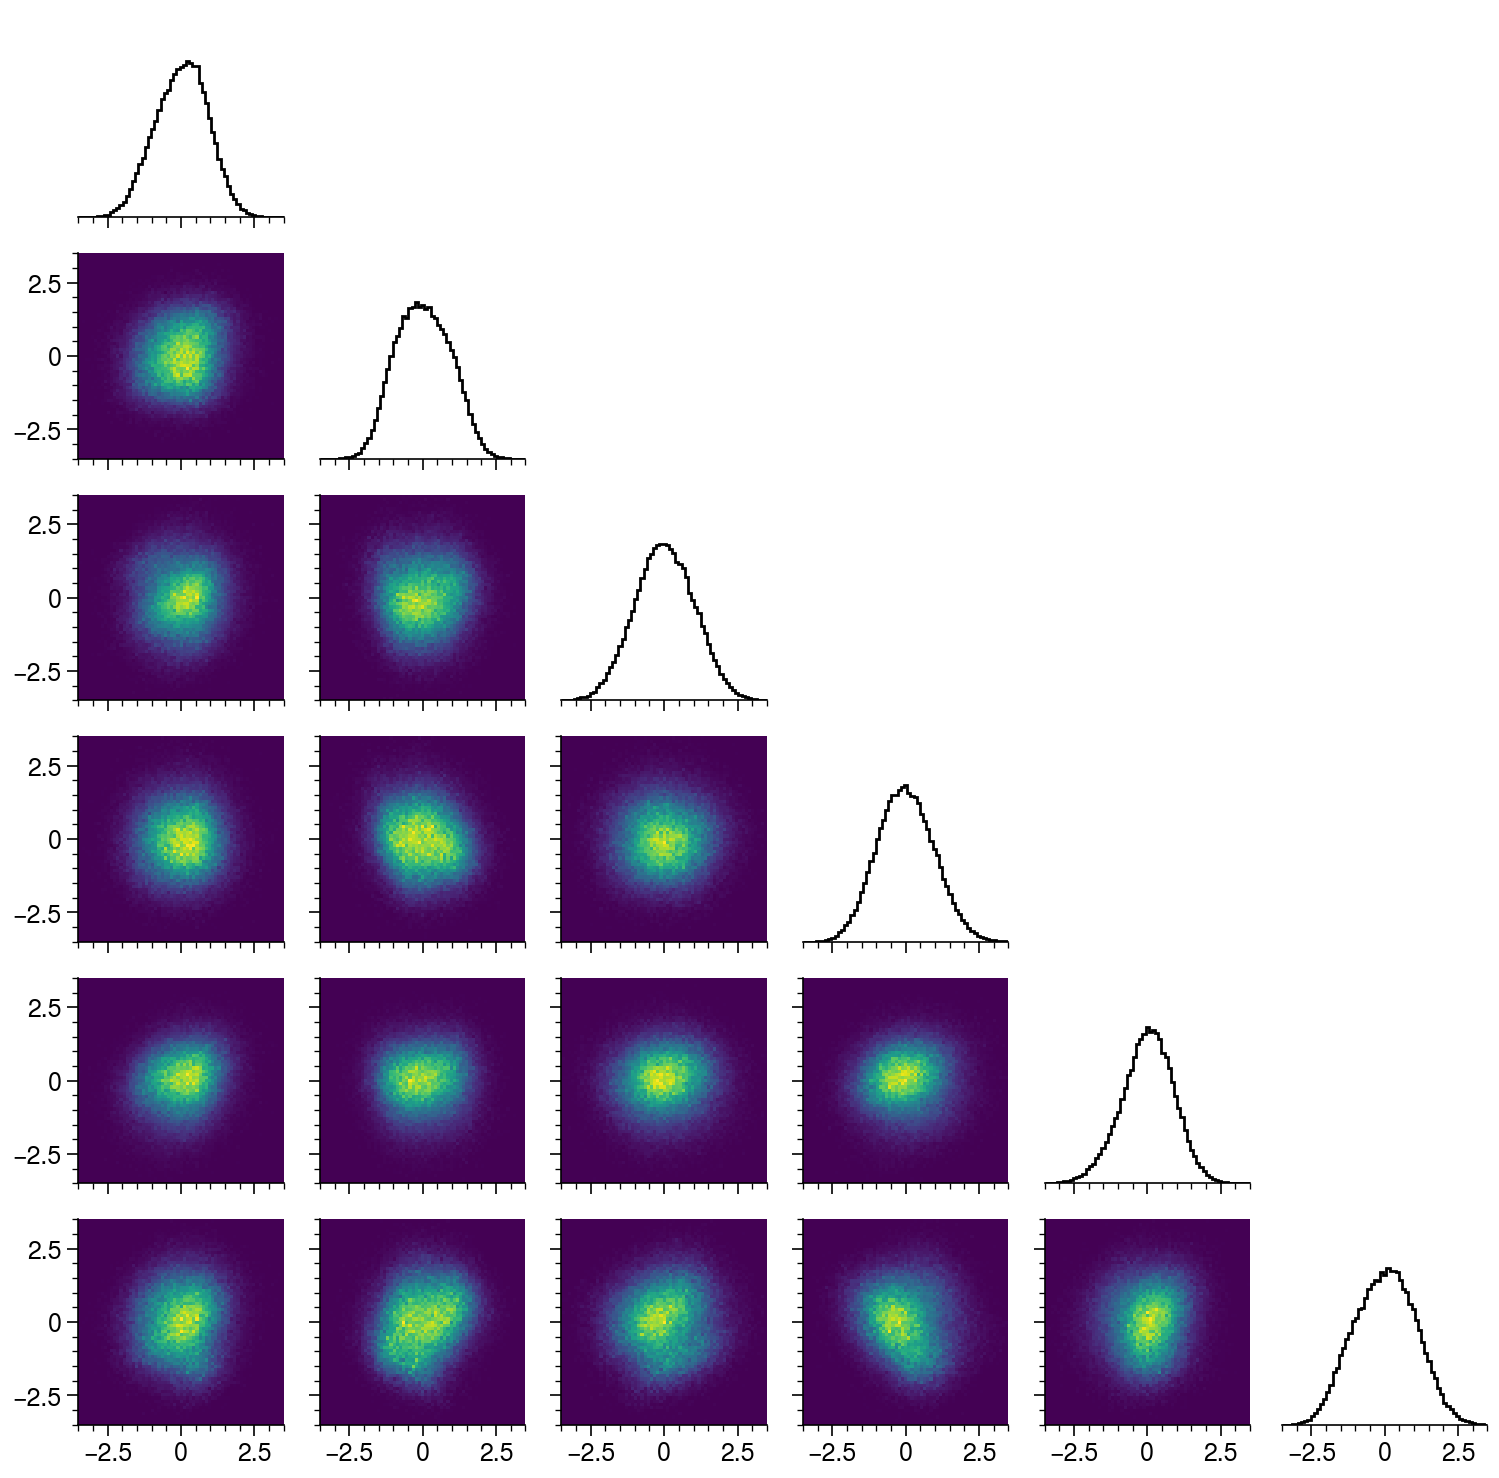

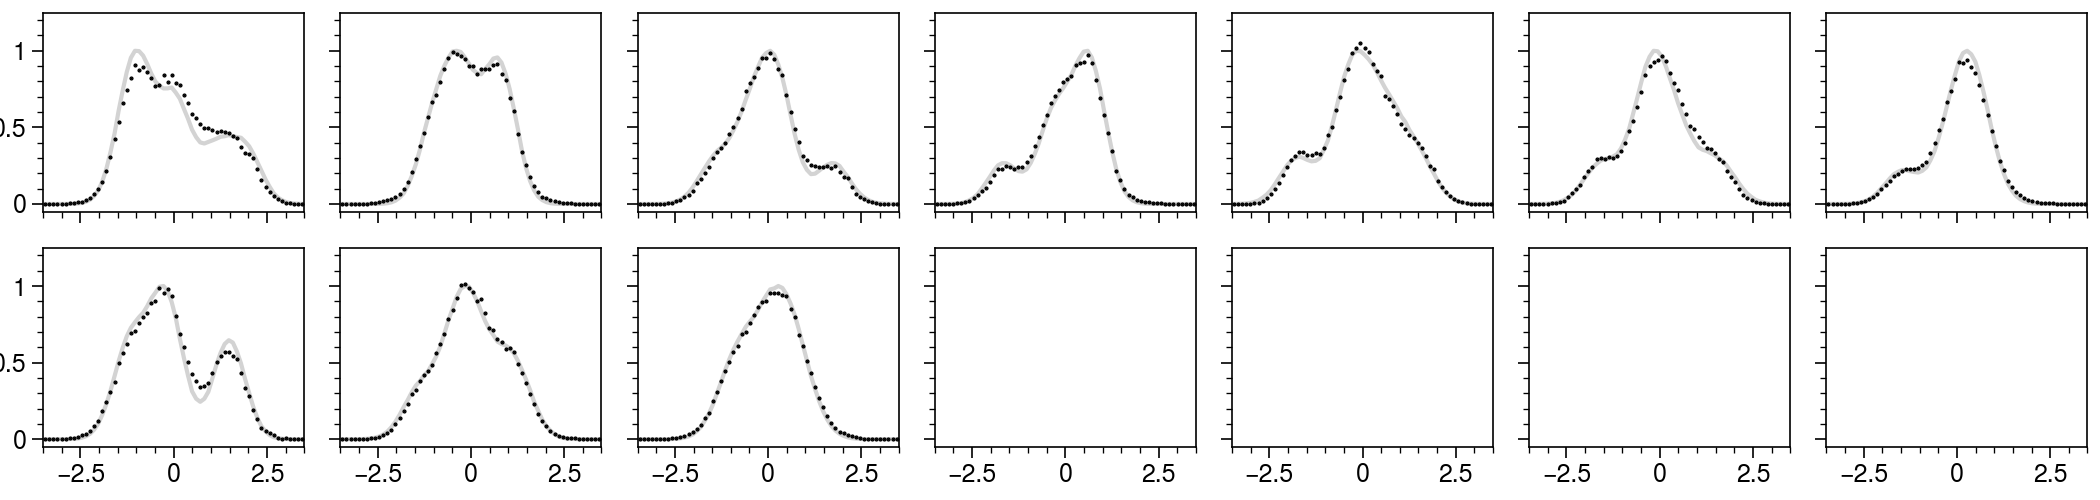

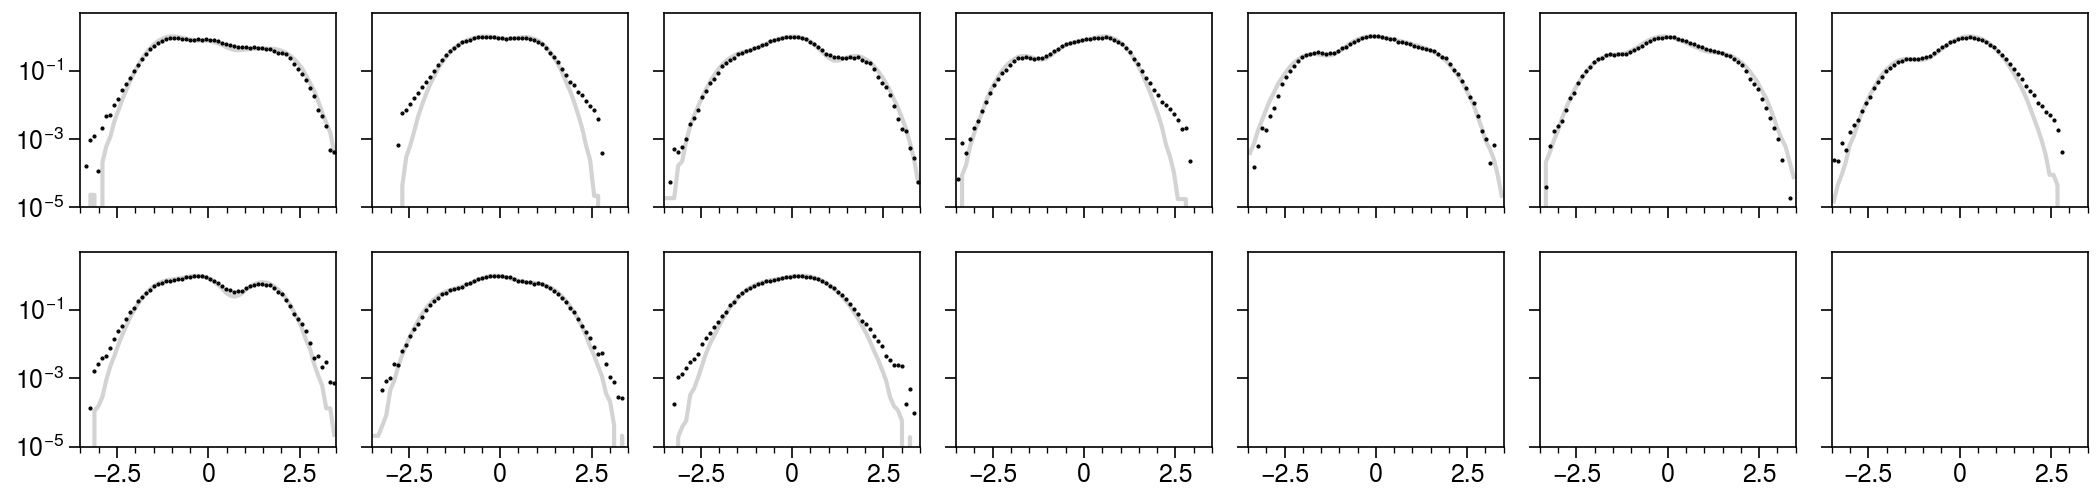

None
epoch = 2


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██                                                                                                            | 225/12015 [00:00<00:05, 2247.55it/s]

  4%|████▏                                                                                                         | 451/12015 [00:00<00:05, 2249.31it/s]

  6%|██████▏                                                                                                       | 676/12015 [00:00<00:05, 2248.99it/s]

  7%|████████▏                                                                                                     | 901/12015 [00:00<00:04, 2225.43it/s]

  9%|██████████▏                                                                                                  | 1129/12015 [00:00<00:04, 2243.08it/s]

 11%|████████████▎                                                                                                | 1355/12015 [00:00<00:04, 2248.00it/s]

 13%|██████████████▎                                                                                              | 1582/12015 [00:00<00:04, 2254.12it/s]

 15%|████████████████▍                                                                                            | 1810/12015 [00:00<00:04, 2260.40it/s]

 17%|██████████████████▍                                                                                          | 2037/12015 [00:00<00:04, 2259.69it/s]

 19%|████████████████████▌                                                                                        | 2266/12015 [00:01<00:04, 2266.46it/s]

 21%|██████████████████████▌                                                                                      | 2493/12015 [00:01<00:04, 2255.50it/s]

 23%|████████████████████████▋                                                                                    | 2720/12015 [00:01<00:04, 2258.80it/s]

 25%|██████████████████████████▋                                                                                  | 2946/12015 [00:01<00:04, 2251.70it/s]

 26%|████████████████████████████▊                                                                                | 3172/12015 [00:01<00:03, 2241.02it/s]

 28%|██████████████████████████████▊                                                                              | 3397/12015 [00:01<00:03, 2242.40it/s]

 30%|████████████████████████████████▊                                                                            | 3622/12015 [00:01<00:03, 2241.68it/s]

 32%|██████████████████████████████████▉                                                                          | 3848/12015 [00:01<00:03, 2245.11it/s]

 34%|████████████████████████████████████▉                                                                        | 4074/12015 [00:01<00:03, 2248.88it/s]

 36%|███████████████████████████████████████                                                                      | 4299/12015 [00:01<00:03, 2244.05it/s]

 38%|█████████████████████████████████████████                                                                    | 4525/12015 [00:02<00:03, 2248.20it/s]

 40%|███████████████████████████████████████████                                                                  | 4750/12015 [00:02<00:03, 2247.24it/s]

 41%|█████████████████████████████████████████████▏                                                               | 4979/12015 [00:02<00:03, 2259.73it/s]

 43%|███████████████████████████████████████████████▎                                                             | 5213/12015 [00:02<00:02, 2282.56it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 5442/12015 [00:02<00:02, 2277.37it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 5675/12015 [00:02<00:02, 2290.71it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 5905/12015 [00:02<00:02, 2289.06it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 6134/12015 [00:02<00:02, 2284.80it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 6363/12015 [00:02<00:02, 2283.56it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 6592/12015 [00:02<00:02, 2272.15it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 6820/12015 [00:03<00:02, 2274.43it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 7048/12015 [00:03<00:02, 2270.75it/s]

 61%|██████████████████████████████████████████████████████████████████                                           | 7276/12015 [00:03<00:02, 2266.93it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 7506/12015 [00:03<00:01, 2274.62it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 7734/12015 [00:03<00:01, 2263.54it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 7961/12015 [00:03<00:01, 2261.17it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 8188/12015 [00:03<00:01, 2261.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 8415/12015 [00:03<00:01, 2261.64it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 8644/12015 [00:03<00:01, 2268.47it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 8871/12015 [00:03<00:01, 2262.69it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 9098/12015 [00:04<00:01, 2259.58it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▌                        | 9324/12015 [00:04<00:01, 2250.68it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▋                      | 9552/12015 [00:04<00:01, 2256.19it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▋                    | 9778/12015 [00:04<00:00, 2252.91it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▉                  | 10008/12015 [00:04<00:00, 2265.21it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████                | 10235/12015 [00:04<00:00, 2252.10it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 10461/12015 [00:04<00:00, 2247.63it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 10686/12015 [00:04<00:00, 2247.96it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████          | 10911/12015 [00:04<00:00, 2242.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 11139/12015 [00:04<00:00, 2253.64it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 11365/12015 [00:05<00:00, 2240.14it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 11590/12015 [00:05<00:00, 2236.05it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 11816/12015 [00:05<00:00, 2242.57it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2256.89it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██                                                                                                            | 228/12015 [00:00<00:05, 2271.84it/s]

  4%|████▏                                                                                                         | 456/12015 [00:00<00:05, 2240.66it/s]

  6%|██████▏                                                                                                       | 681/12015 [00:00<00:05, 2217.11it/s]

  8%|████████▎                                                                                                     | 903/12015 [00:00<00:05, 2149.58it/s]

 10%|██████████▍                                                                                                  | 1146/12015 [00:00<00:04, 2245.97it/s]

 12%|████████████▌                                                                                                | 1388/12015 [00:00<00:04, 2302.27it/s]

 14%|██████████████▊                                                                                              | 1629/12015 [00:00<00:04, 2336.99it/s]

 16%|████████████████▉                                                                                            | 1872/12015 [00:00<00:04, 2364.73it/s]

 18%|███████████████████▏                                                                                         | 2117/12015 [00:00<00:04, 2389.06it/s]

 20%|█████████████████████▍                                                                                       | 2360/12015 [00:01<00:04, 2401.53it/s]

 22%|███████████████████████▌                                                                                     | 2604/12015 [00:01<00:03, 2411.30it/s]

 24%|█████████████████████████▊                                                                                   | 2848/12015 [00:01<00:03, 2418.20it/s]

 26%|████████████████████████████                                                                                 | 3092/12015 [00:01<00:03, 2424.24it/s]

 28%|██████████████████████████████▎                                                                              | 3335/12015 [00:01<00:03, 2417.41it/s]

 30%|████████████████████████████████▍                                                                            | 3577/12015 [00:01<00:03, 2410.57it/s]

 32%|██████████████████████████████████▋                                                                          | 3819/12015 [00:01<00:03, 2408.61it/s]

 34%|████████████████████████████████████▊                                                                        | 4060/12015 [00:01<00:03, 2402.02it/s]

 36%|███████████████████████████████████████                                                                      | 4301/12015 [00:01<00:03, 2399.38it/s]

 38%|█████████████████████████████████████████▏                                                                   | 4541/12015 [00:01<00:03, 2395.18it/s]

 40%|███████████████████████████████████████████▎                                                                 | 4781/12015 [00:02<00:03, 2395.45it/s]

 42%|█████████████████████████████████████████████▌                                                               | 5021/12015 [00:02<00:02, 2393.51it/s]

 44%|███████████████████████████████████████████████▋                                                             | 5261/12015 [00:02<00:02, 2393.12it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 5501/12015 [00:02<00:02, 2392.66it/s]

 48%|████████████████████████████████████████████████████                                                         | 5741/12015 [00:02<00:02, 2392.21it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 5982/12015 [00:02<00:02, 2394.63it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 6222/12015 [00:02<00:02, 2392.58it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 6462/12015 [00:02<00:02, 2391.41it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 6703/12015 [00:02<00:02, 2395.69it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 6943/12015 [00:02<00:02, 2391.88it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                           | 7184/12015 [00:03<00:02, 2394.54it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 7424/12015 [00:03<00:01, 2392.20it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 7664/12015 [00:03<00:01, 2393.30it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 7904/12015 [00:03<00:01, 2391.38it/s]

 68%|█████████████████████████████████████████████████████████████████████████▉                                   | 8144/12015 [00:03<00:01, 2390.67it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 8384/12015 [00:03<00:01, 2389.37it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 8624/12015 [00:03<00:01, 2391.77it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 8864/12015 [00:03<00:01, 2388.56it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 9103/12015 [00:03<00:01, 2387.69it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 9343/12015 [00:03<00:01, 2391.06it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 9583/12015 [00:04<00:01, 2389.64it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 9822/12015 [00:04<00:00, 2384.83it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 10062/12015 [00:04<00:00, 2388.78it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 10301/12015 [00:04<00:00, 2387.91it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 10540/12015 [00:04<00:00, 2366.54it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 10777/12015 [00:04<00:00, 2310.87it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 11016/12015 [00:04<00:00, 2333.94it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 11257/12015 [00:04<00:00, 2353.84it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 11498/12015 [00:04<00:00, 2368.49it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 11739/12015 [00:04<00:00, 2378.96it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 11978/12015 [00:05<00:00, 2291.98it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2368.60it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 237/12015 [00:00<00:04, 2367.44it/s]

  4%|████▎                                                                                                         | 475/12015 [00:00<00:04, 2371.87it/s]

  6%|██████▌                                                                                                       | 713/12015 [00:00<00:04, 2374.15it/s]

  8%|████████▋                                                                                                     | 951/12015 [00:00<00:04, 2370.01it/s]

 10%|██████████▊                                                                                                  | 1189/12015 [00:00<00:04, 2367.38it/s]

 12%|████████████▉                                                                                                | 1427/12015 [00:00<00:04, 2370.09it/s]

 14%|███████████████                                                                                              | 1667/12015 [00:00<00:04, 2378.01it/s]

 16%|█████████████████▎                                                                                           | 1907/12015 [00:00<00:04, 2383.04it/s]

 18%|███████████████████▍                                                                                         | 2147/12015 [00:00<00:04, 2386.77it/s]

 20%|█████████████████████▋                                                                                       | 2386/12015 [00:01<00:04, 2387.05it/s]

 22%|███████████████████████▊                                                                                     | 2625/12015 [00:01<00:03, 2349.56it/s]

 24%|█████████████████████████▉                                                                                   | 2861/12015 [00:01<00:03, 2343.78it/s]

 26%|████████████████████████████                                                                                 | 3099/12015 [00:01<00:03, 2352.79it/s]

 28%|██████████████████████████████▎                                                                              | 3339/12015 [00:01<00:03, 2365.77it/s]

 30%|████████████████████████████████▍                                                                            | 3578/12015 [00:01<00:03, 2372.78it/s]

 32%|██████████████████████████████████▌                                                                          | 3816/12015 [00:01<00:03, 2372.50it/s]

 34%|████████████████████████████████████▊                                                                        | 4056/12015 [00:01<00:03, 2380.05it/s]

 36%|██████████████████████████████████████▉                                                                      | 4296/12015 [00:01<00:03, 2383.57it/s]

 38%|█████████████████████████████████████████▏                                                                   | 4536/12015 [00:01<00:03, 2385.70it/s]

 40%|███████████████████████████████████████████▎                                                                 | 4775/12015 [00:02<00:03, 2385.01it/s]

 42%|█████████████████████████████████████████████▍                                                               | 5015/12015 [00:02<00:02, 2386.62it/s]

 44%|███████████████████████████████████████████████▋                                                             | 5254/12015 [00:02<00:02, 2385.74it/s]

 46%|█████████████████████████████████████████████████▊                                                           | 5495/12015 [00:02<00:02, 2390.45it/s]

 48%|████████████████████████████████████████████████████                                                         | 5735/12015 [00:02<00:02, 2391.29it/s]

 50%|██████████████████████████████████████████████████████▏                                                      | 5975/12015 [00:02<00:02, 2391.90it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 6215/12015 [00:02<00:02, 2392.37it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 6455/12015 [00:02<00:02, 2389.30it/s]

 56%|████████████████████████████████████████████████████████████▋                                                | 6694/12015 [00:02<00:02, 2388.59it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 6934/12015 [00:02<00:02, 2389.33it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 7174/12015 [00:03<00:02, 2392.32it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 7414/12015 [00:03<00:01, 2394.05it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 7654/12015 [00:03<00:01, 2374.37it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 7892/12015 [00:03<00:01, 2349.82it/s]

 68%|█████████████████████████████████████████████████████████████████████████▋                                   | 8128/12015 [00:03<00:01, 2336.96it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 8362/12015 [00:03<00:01, 2331.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▉                               | 8596/12015 [00:03<00:01, 2321.48it/s]

 73%|████████████████████████████████████████████████████████████████████████████████                             | 8829/12015 [00:03<00:01, 2309.81it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████▏                          | 9062/12015 [00:03<00:01, 2313.96it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████▎                        | 9296/12015 [00:03<00:01, 2319.01it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▍                      | 9528/12015 [00:04<00:01, 2316.15it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▌                    | 9762/12015 [00:04<00:00, 2321.80it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▋                  | 9995/12015 [00:04<00:00, 2317.43it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▉                | 10227/12015 [00:04<00:00, 2317.16it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 10459/12015 [00:04<00:00, 2313.43it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████            | 10691/12015 [00:04<00:00, 2308.52it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▏         | 10923/12015 [00:04<00:00, 2311.81it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 11155/12015 [00:04<00:00, 2301.99it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 11387/12015 [00:04<00:00, 2304.78it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 11619/12015 [00:04<00:00, 2306.54it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 11850/12015 [00:05<00:00, 2304.01it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2352.46it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██                                                                                                            | 231/12015 [00:00<00:05, 2305.14it/s]

  4%|████▏                                                                                                         | 463/12015 [00:00<00:05, 2308.14it/s]

  6%|██████▎                                                                                                       | 694/12015 [00:00<00:05, 2165.25it/s]

  8%|████████▌                                                                                                     | 932/12015 [00:00<00:04, 2244.05it/s]

 10%|██████████▌                                                                                                  | 1169/12015 [00:00<00:04, 2284.78it/s]

 12%|████████████▊                                                                                                | 1407/12015 [00:00<00:04, 2313.04it/s]

 14%|██████████████▉                                                                                              | 1647/12015 [00:00<00:04, 2338.56it/s]

 16%|█████████████████                                                                                            | 1885/12015 [00:00<00:04, 2349.64it/s]

 18%|███████████████████▎                                                                                         | 2124/12015 [00:00<00:04, 2361.38it/s]

 20%|█████████████████████▍                                                                                       | 2364/12015 [00:01<00:04, 2371.24it/s]

 22%|███████████████████████▌                                                                                     | 2604/12015 [00:01<00:03, 2379.73it/s]

 24%|█████████████████████████▊                                                                                   | 2843/12015 [00:01<00:03, 2382.16it/s]

 26%|███████████████████████████▉                                                                                 | 3082/12015 [00:01<00:03, 2383.71it/s]

 28%|██████████████████████████████▏                                                                              | 3325/12015 [00:01<00:03, 2396.03it/s]

 30%|████████████████████████████████▎                                                                            | 3565/12015 [00:01<00:03, 2393.22it/s]

 32%|██████████████████████████████████▌                                                                          | 3805/12015 [00:01<00:03, 2373.66it/s]

 34%|████████████████████████████████████▋                                                                        | 4043/12015 [00:01<00:03, 2364.95it/s]

 36%|██████████████████████████████████████▊                                                                      | 4280/12015 [00:01<00:03, 2358.59it/s]

 38%|████████████████████████████████████████▉                                                                    | 4516/12015 [00:01<00:03, 2354.49it/s]

 40%|███████████████████████████████████████████                                                                  | 4752/12015 [00:02<00:03, 2351.38it/s]

 42%|█████████████████████████████████████████████▎                                                               | 4988/12015 [00:02<00:02, 2348.46it/s]

 43%|███████████████████████████████████████████████▍                                                             | 5224/12015 [00:02<00:02, 2349.16it/s]

 45%|█████████████████████████████████████████████████▌                                                           | 5459/12015 [00:02<00:02, 2346.68it/s]

 47%|███████████████████████████████████████████████████▋                                                         | 5695/12015 [00:02<00:02, 2350.41it/s]

 49%|█████████████████████████████████████████████████████▊                                                       | 5931/12015 [00:02<00:02, 2348.54it/s]

 51%|███████████████████████████████████████████████████████▉                                                     | 6166/12015 [00:02<00:02, 2345.62it/s]

 53%|██████████████████████████████████████████████████████████                                                   | 6402/12015 [00:02<00:02, 2348.22it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 6637/12015 [00:02<00:02, 2341.13it/s]

 57%|██████████████████████████████████████████████████████████████▎                                              | 6872/12015 [00:02<00:02, 2342.44it/s]

 59%|████████████████████████████████████████████████████████████████▍                                            | 7107/12015 [00:03<00:02, 2327.25it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 7340/12015 [00:03<00:02, 2217.09it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 7563/12015 [00:03<00:02, 2159.80it/s]

 65%|██████████████████████████████████████████████████████████████████████▋                                      | 7787/12015 [00:03<00:01, 2180.89it/s]

 67%|████████████████████████████████████████████████████████████████████████▋                                    | 8006/12015 [00:03<00:01, 2142.61it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 8234/12015 [00:03<00:01, 2181.89it/s]

 70%|████████████████████████████████████████████████████████████████████████████▊                                | 8464/12015 [00:03<00:01, 2215.60it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▉                              | 8697/12015 [00:03<00:01, 2248.07it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 8930/12015 [00:03<00:01, 2271.89it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 9165/12015 [00:03<00:01, 2293.32it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 9402/12015 [00:04<00:01, 2313.60it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 9637/12015 [00:04<00:01, 2321.92it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 9872/12015 [00:04<00:00, 2328.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 10108/12015 [00:04<00:00, 2337.02it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▉               | 10342/12015 [00:04<00:00, 2332.81it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████             | 10576/12015 [00:04<00:00, 2334.16it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▏          | 10810/12015 [00:04<00:00, 2260.04it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 11038/12015 [00:04<00:00, 2265.73it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 11272/12015 [00:04<00:00, 2287.24it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 11505/12015 [00:04<00:00, 2297.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 11739/12015 [00:05<00:00, 2309.52it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 11971/12015 [00:05<00:00, 2310.36it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2310.29it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 233/12015 [00:00<00:05, 2320.49it/s]

  4%|████▎                                                                                                         | 466/12015 [00:00<00:04, 2313.51it/s]

  6%|██████▍                                                                                                       | 698/12015 [00:00<00:04, 2306.66it/s]

  8%|████████▌                                                                                                     | 931/12015 [00:00<00:04, 2315.30it/s]

 10%|██████████▌                                                                                                  | 1163/12015 [00:00<00:04, 2309.59it/s]

 12%|████████████▋                                                                                                | 1397/12015 [00:00<00:04, 2317.26it/s]

 14%|██████████████▊                                                                                              | 1630/12015 [00:00<00:04, 2320.26it/s]

 16%|████████████████▉                                                                                            | 1863/12015 [00:00<00:04, 2322.34it/s]

 17%|███████████████████                                                                                          | 2096/12015 [00:00<00:04, 2320.84it/s]

 19%|█████████████████████▏                                                                                       | 2330/12015 [00:01<00:04, 2326.08it/s]

 21%|███████████████████████▎                                                                                     | 2563/12015 [00:01<00:04, 2318.90it/s]

 23%|█████████████████████████▎                                                                                   | 2795/12015 [00:01<00:04, 2298.50it/s]

 25%|███████████████████████████▍                                                                                 | 3025/12015 [00:01<00:03, 2298.70it/s]

 27%|█████████████████████████████▌                                                                               | 3255/12015 [00:01<00:03, 2296.62it/s]

 29%|███████████████████████████████▌                                                                             | 3486/12015 [00:01<00:03, 2299.05it/s]

 31%|█████████████████████████████████▋                                                                           | 3717/12015 [00:01<00:03, 2302.05it/s]

 33%|███████████████████████████████████▊                                                                         | 3948/12015 [00:01<00:03, 2298.39it/s]

 35%|█████████████████████████████████████▉                                                                       | 4178/12015 [00:01<00:03, 2293.63it/s]

 37%|███████████████████████████████████████▉                                                                     | 4409/12015 [00:01<00:03, 2296.28it/s]

 39%|██████████████████████████████████████████                                                                   | 4641/12015 [00:02<00:03, 2300.57it/s]

 41%|████████████████████████████████████████████▏                                                                | 4873/12015 [00:02<00:03, 2303.91it/s]

 42%|██████████████████████████████████████████████▎                                                              | 5104/12015 [00:02<00:02, 2304.18it/s]

 44%|████████████████████████████████████████████████▍                                                            | 5336/12015 [00:02<00:02, 2308.70it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 5570/12015 [00:02<00:02, 2315.47it/s]

 48%|████████████████████████████████████████████████████▋                                                        | 5802/12015 [00:02<00:02, 2313.89it/s]

 50%|██████████████████████████████████████████████████████▊                                                      | 6036/12015 [00:02<00:02, 2320.89it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 6269/12015 [00:02<00:02, 2315.02it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 6502/12015 [00:02<00:02, 2316.56it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 6734/12015 [00:02<00:02, 2314.37it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 6968/12015 [00:03<00:02, 2321.61it/s]

 60%|█████████████████████████████████████████████████████████████████▎                                           | 7201/12015 [00:03<00:02, 2318.62it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 7435/12015 [00:03<00:01, 2323.21it/s]

 64%|█████████████████████████████████████████████████████████████████████▌                                       | 7669/12015 [00:03<00:01, 2325.73it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 7902/12015 [00:03<00:01, 2325.77it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 8136/12015 [00:03<00:01, 2328.85it/s]

 70%|███████████████████████████████████████████████████████████████████████████▉                                 | 8375/12015 [00:03<00:01, 2346.38it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 8616/12015 [00:03<00:01, 2364.10it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▎                            | 8856/12015 [00:03<00:01, 2374.71it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 9097/12015 [00:03<00:01, 2384.83it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 9338/12015 [00:04<00:01, 2391.94it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 9579/12015 [00:04<00:01, 2395.93it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 9819/12015 [00:04<00:00, 2395.16it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 10059/12015 [00:04<00:00, 2391.71it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 10300/12015 [00:04<00:00, 2395.60it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 10540/12015 [00:04<00:00, 2395.70it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 10780/12015 [00:04<00:00, 2395.41it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████         | 11020/12015 [00:04<00:00, 2396.34it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 11262/12015 [00:04<00:00, 2401.01it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 11503/12015 [00:04<00:00, 2395.73it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 11743/12015 [00:05<00:00, 2396.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 11983/12015 [00:05<00:00, 2390.71it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2339.33it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 239/12015 [00:00<00:04, 2381.38it/s]

  4%|████▍                                                                                                         | 478/12015 [00:00<00:04, 2386.36it/s]

  6%|██████▌                                                                                                       | 717/12015 [00:00<00:05, 2222.89it/s]

  8%|████████▋                                                                                                     | 952/12015 [00:00<00:04, 2269.08it/s]

 10%|██████████▊                                                                                                  | 1194/12015 [00:00<00:04, 2319.17it/s]

 12%|█████████████                                                                                                | 1434/12015 [00:00<00:04, 2344.06it/s]

 14%|███████████████▏                                                                                             | 1674/12015 [00:00<00:04, 2361.53it/s]

 16%|█████████████████▎                                                                                           | 1914/12015 [00:00<00:04, 2373.36it/s]

 18%|███████████████████▌                                                                                         | 2155/12015 [00:00<00:04, 2383.71it/s]

 20%|█████████████████████▋                                                                                       | 2395/12015 [00:01<00:04, 2388.03it/s]

 22%|███████████████████████▉                                                                                     | 2634/12015 [00:01<00:03, 2385.39it/s]

 24%|██████████████████████████                                                                                   | 2873/12015 [00:01<00:03, 2380.66it/s]

 26%|████████████████████████████▎                                                                                | 3115/12015 [00:01<00:03, 2391.83it/s]

 28%|██████████████████████████████▍                                                                              | 3355/12015 [00:01<00:03, 2391.17it/s]

 30%|████████████████████████████████▌                                                                            | 3596/12015 [00:01<00:03, 2395.71it/s]

 32%|██████████████████████████████████▊                                                                          | 3839/12015 [00:01<00:03, 2403.67it/s]

 34%|█████████████████████████████████████                                                                        | 4080/12015 [00:01<00:03, 2398.20it/s]

 36%|███████████████████████████████████████▏                                                                     | 4320/12015 [00:01<00:03, 2395.87it/s]

 38%|█████████████████████████████████████████▍                                                                   | 4563/12015 [00:01<00:03, 2403.30it/s]

 40%|███████████████████████████████████████████▌                                                                 | 4804/12015 [00:02<00:03, 2398.80it/s]

 42%|█████████████████████████████████████████████▊                                                               | 5044/12015 [00:02<00:02, 2394.56it/s]

 44%|███████████████████████████████████████████████▉                                                             | 5288/12015 [00:02<00:02, 2405.93it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 5531/12015 [00:02<00:02, 2410.64it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 5773/12015 [00:02<00:02, 2411.84it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 6015/12015 [00:02<00:02, 2405.26it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 6256/12015 [00:02<00:02, 2401.23it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 6497/12015 [00:02<00:02, 2401.79it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 6738/12015 [00:02<00:02, 2396.07it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 6981/12015 [00:02<00:02, 2404.42it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 7222/12015 [00:03<00:01, 2403.62it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 7465/12015 [00:03<00:01, 2409.96it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 7706/12015 [00:03<00:01, 2401.77it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 7947/12015 [00:03<00:01, 2391.42it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 8187/12015 [00:03<00:01, 2317.25it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 8420/12015 [00:03<00:01, 2297.10it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 8651/12015 [00:03<00:01, 2297.63it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 8890/12015 [00:03<00:01, 2322.36it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 9127/12015 [00:03<00:01, 2334.19it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 9361/12015 [00:03<00:01, 2233.94it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 9597/12015 [00:04<00:01, 2269.85it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 9833/12015 [00:04<00:00, 2294.29it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 10073/12015 [00:04<00:00, 2323.46it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 10313/12015 [00:04<00:00, 2344.01it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 10553/12015 [00:04<00:00, 2359.54it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 10792/12015 [00:04<00:00, 2367.22it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 11033/12015 [00:04<00:00, 2377.16it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 11271/12015 [00:04<00:00, 2377.95it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 11513/12015 [00:04<00:00, 2388.78it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 11754/12015 [00:04<00:00, 2394.50it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 11995/12015 [00:05<00:00, 2396.91it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2367.75it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 241/12015 [00:00<00:04, 2400.14it/s]

  4%|████▍                                                                                                         | 482/12015 [00:00<00:04, 2400.77it/s]

  6%|██████▌                                                                                                       | 723/12015 [00:00<00:04, 2393.93it/s]

  8%|████████▊                                                                                                     | 963/12015 [00:00<00:04, 2393.03it/s]

 10%|██████████▉                                                                                                  | 1205/12015 [00:00<00:04, 2400.65it/s]

 12%|█████████████                                                                                                | 1446/12015 [00:00<00:04, 2401.75it/s]

 14%|███████████████▎                                                                                             | 1687/12015 [00:00<00:04, 2402.12it/s]

 16%|█████████████████▍                                                                                           | 1928/12015 [00:00<00:04, 2400.64it/s]

 18%|███████████████████▋                                                                                         | 2169/12015 [00:00<00:04, 2397.29it/s]

 20%|█████████████████████▊                                                                                       | 2410/12015 [00:01<00:04, 2399.78it/s]

 22%|████████████████████████                                                                                     | 2650/12015 [00:01<00:03, 2395.05it/s]

 24%|██████████████████████████▏                                                                                  | 2890/12015 [00:01<00:03, 2389.01it/s]

 26%|████████████████████████████▍                                                                                | 3130/12015 [00:01<00:03, 2391.47it/s]

 28%|██████████████████████████████▌                                                                              | 3371/12015 [00:01<00:03, 2394.77it/s]

 30%|████████████████████████████████▊                                                                            | 3613/12015 [00:01<00:03, 2399.96it/s]

 32%|██████████████████████████████████▉                                                                          | 3854/12015 [00:01<00:03, 2401.90it/s]

 34%|█████████████████████████████████████▏                                                                       | 4095/12015 [00:01<00:03, 2401.00it/s]

 36%|███████████████████████████████████████▎                                                                     | 4336/12015 [00:01<00:03, 2398.62it/s]

 38%|█████████████████████████████████████████▌                                                                   | 4576/12015 [00:01<00:03, 2393.41it/s]

 40%|███████████████████████████████████████████▋                                                                 | 4818/12015 [00:02<00:02, 2399.05it/s]

 42%|█████████████████████████████████████████████▉                                                               | 5058/12015 [00:02<00:02, 2398.31it/s]

 44%|████████████████████████████████████████████████                                                             | 5298/12015 [00:02<00:02, 2397.98it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 5538/12015 [00:02<00:02, 2396.48it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 5778/12015 [00:02<00:02, 2394.47it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 6019/12015 [00:02<00:02, 2397.44it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 6259/12015 [00:02<00:02, 2397.77it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 6499/12015 [00:02<00:02, 2277.01it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 6737/12015 [00:02<00:02, 2305.61it/s]

 58%|███████████████████████████████████████████████████████████████▏                                             | 6969/12015 [00:02<00:02, 2301.59it/s]

 60%|█████████████████████████████████████████████████████████████████▍                                           | 7207/12015 [00:03<00:02, 2324.16it/s]

 62%|███████████████████████████████████████████████████████████████████▌                                         | 7446/12015 [00:03<00:01, 2341.99it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 7686/12015 [00:03<00:01, 2357.44it/s]

 66%|███████████████████████████████████████████████████████████████████████▉                                     | 7927/12015 [00:03<00:01, 2372.59it/s]

 68%|██████████████████████████████████████████████████████████████████████████                                   | 8169/12015 [00:03<00:01, 2385.86it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 8409/12015 [00:03<00:01, 2388.70it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 8651/12015 [00:03<00:01, 2398.03it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 8894/12015 [00:03<00:01, 2407.46it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 9137/12015 [00:03<00:01, 2412.14it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████                        | 9379/12015 [00:03<00:01, 2404.11it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 9622/12015 [00:04<00:00, 2410.61it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 9865/12015 [00:04<00:00, 2415.71it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 10108/12015 [00:04<00:00, 2419.82it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 10351/12015 [00:04<00:00, 2422.35it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 10594/12015 [00:04<00:00, 2423.83it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▍          | 10837/12015 [00:04<00:00, 2415.15it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 11080/12015 [00:04<00:00, 2418.41it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 11322/12015 [00:04<00:00, 2411.14it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 11564/12015 [00:04<00:00, 2404.74it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 11807/12015 [00:04<00:00, 2409.62it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2391.48it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 239/12015 [00:00<00:04, 2382.66it/s]

  4%|████▍                                                                                                         | 479/12015 [00:00<00:04, 2391.63it/s]

  6%|██████▌                                                                                                       | 722/12015 [00:00<00:04, 2405.61it/s]

  8%|████████▊                                                                                                     | 963/12015 [00:00<00:04, 2397.79it/s]

 10%|██████████▉                                                                                                  | 1203/12015 [00:00<00:04, 2389.40it/s]

 12%|█████████████                                                                                                | 1443/12015 [00:00<00:04, 2390.91it/s]

 14%|███████████████▎                                                                                             | 1683/12015 [00:00<00:04, 2393.03it/s]

 16%|█████████████████▍                                                                                           | 1924/12015 [00:00<00:04, 2397.39it/s]

 18%|███████████████████▋                                                                                         | 2167/12015 [00:00<00:04, 2404.53it/s]

 20%|█████████████████████▊                                                                                       | 2408/12015 [00:01<00:04, 2401.51it/s]

 22%|████████████████████████                                                                                     | 2649/12015 [00:01<00:03, 2394.65it/s]

 24%|██████████████████████████▏                                                                                  | 2891/12015 [00:01<00:03, 2399.48it/s]

 26%|████████████████████████████▍                                                                                | 3132/12015 [00:01<00:03, 2401.83it/s]

 28%|██████████████████████████████▌                                                                              | 3374/12015 [00:01<00:03, 2406.27it/s]

 30%|████████████████████████████████▊                                                                            | 3617/12015 [00:01<00:03, 2412.64it/s]

 32%|███████████████████████████████████                                                                          | 3859/12015 [00:01<00:03, 2410.91it/s]

 34%|█████████████████████████████████████▏                                                                       | 4101/12015 [00:01<00:03, 2404.39it/s]

 36%|███████████████████████████████████████▍                                                                     | 4344/12015 [00:01<00:03, 2410.47it/s]

 38%|█████████████████████████████████████████▌                                                                   | 4586/12015 [00:01<00:03, 2375.78it/s]

 40%|███████████████████████████████████████████▊                                                                 | 4824/12015 [00:02<00:03, 2366.78it/s]

 42%|█████████████████████████████████████████████▉                                                               | 5061/12015 [00:02<00:02, 2365.70it/s]

 44%|████████████████████████████████████████████████                                                             | 5301/12015 [00:02<00:02, 2375.11it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 5541/12015 [00:02<00:02, 2381.86it/s]

 48%|████████████████████████████████████████████████████▍                                                        | 5781/12015 [00:02<00:02, 2386.08it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 6023/12015 [00:02<00:02, 2394.81it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 6264/12015 [00:02<00:02, 2396.83it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 6504/12015 [00:02<00:02, 2393.36it/s]

 56%|█████████████████████████████████████████████████████████████▏                                               | 6744/12015 [00:02<00:02, 2393.39it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 6984/12015 [00:02<00:02, 2394.41it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 7224/12015 [00:03<00:02, 2395.15it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 7464/12015 [00:03<00:01, 2396.04it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 7704/12015 [00:03<00:01, 2397.15it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 7945/12015 [00:03<00:01, 2398.33it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 8185/12015 [00:03<00:01, 2397.38it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 8425/12015 [00:03<00:01, 2396.24it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▌                              | 8665/12015 [00:03<00:01, 2395.26it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 8906/12015 [00:03<00:01, 2397.75it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▉                          | 9146/12015 [00:03<00:01, 2397.60it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 9387/12015 [00:03<00:01, 2399.63it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 9627/12015 [00:04<00:00, 2398.93it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▌                   | 9868/12015 [00:04<00:00, 2401.17it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▊                 | 10109/12015 [00:04<00:00, 2402.60it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 10350/12015 [00:04<00:00, 2399.30it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▏            | 10591/12015 [00:04<00:00, 2400.38it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▎          | 10832/12015 [00:04<00:00, 2402.08it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▌        | 11073/12015 [00:04<00:00, 2394.29it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 11314/12015 [00:04<00:00, 2398.93it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 11554/12015 [00:04<00:00, 2390.16it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 11795/12015 [00:04<00:00, 2394.45it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2395.50it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 238/12015 [00:00<00:04, 2379.03it/s]

  4%|████▍                                                                                                         | 479/12015 [00:00<00:04, 2396.45it/s]

  6%|██████▌                                                                                                       | 719/12015 [00:00<00:04, 2395.73it/s]

  8%|████████▊                                                                                                     | 959/12015 [00:00<00:04, 2391.15it/s]

 10%|██████████▉                                                                                                  | 1201/12015 [00:00<00:04, 2399.43it/s]

 12%|█████████████                                                                                                | 1441/12015 [00:00<00:04, 2395.52it/s]

 14%|███████████████▎                                                                                             | 1681/12015 [00:00<00:04, 2367.54it/s]

 16%|█████████████████▍                                                                                           | 1918/12015 [00:00<00:04, 2350.73it/s]

 18%|███████████████████▌                                                                                         | 2154/12015 [00:00<00:04, 2336.05it/s]

 20%|█████████████████████▋                                                                                       | 2388/12015 [00:01<00:04, 2333.55it/s]

 22%|███████████████████████▊                                                                                     | 2622/12015 [00:01<00:04, 2324.92it/s]

 24%|█████████████████████████▉                                                                                   | 2855/12015 [00:01<00:04, 2272.44it/s]

 26%|███████████████████████████▉                                                                                 | 3083/12015 [00:01<00:04, 2201.25it/s]

 28%|██████████████████████████████                                                                               | 3319/12015 [00:01<00:03, 2245.02it/s]

 30%|████████████████████████████████▏                                                                            | 3545/12015 [00:01<00:03, 2209.24it/s]

 31%|██████████████████████████████████▏                                                                          | 3767/12015 [00:01<00:03, 2191.53it/s]

 33%|████████████████████████████████████▎                                                                        | 4002/12015 [00:01<00:03, 2234.96it/s]

 35%|██████████████████████████████████████▍                                                                      | 4240/12015 [00:01<00:03, 2276.39it/s]

 37%|████████████████████████████████████████▌                                                                    | 4468/12015 [00:01<00:03, 2255.41it/s]

 39%|██████████████████████████████████████████▌                                                                  | 4694/12015 [00:02<00:03, 2193.50it/s]

 41%|████████████████████████████████████████████▌                                                                | 4914/12015 [00:02<00:03, 2143.21it/s]

 43%|██████████████████████████████████████████████▌                                                              | 5129/12015 [00:02<00:03, 2097.44it/s]

 44%|████████████████████████████████████████████████▍                                                            | 5340/12015 [00:02<00:03, 2059.55it/s]

 46%|██████████████████████████████████████████████████▌                                                          | 5567/12015 [00:02<00:03, 2117.59it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 5792/12015 [00:02<00:02, 2154.37it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 6028/12015 [00:02<00:02, 2213.46it/s]

 52%|████████████████████████████████████████████████████████▊                                                    | 6261/12015 [00:02<00:02, 2246.71it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 6495/12015 [00:02<00:02, 2272.21it/s]

 56%|████████████████████████████████████████████████████████████▉                                                | 6723/12015 [00:02<00:02, 2235.35it/s]

 58%|███████████████████████████████████████████████████████████████                                              | 6947/12015 [00:03<00:02, 2208.05it/s]

 60%|█████████████████████████████████████████████████████████████████                                            | 7169/12015 [00:03<00:02, 2175.97it/s]

 62%|███████████████████████████████████████████████████████████████████▏                                         | 7405/12015 [00:03<00:02, 2228.48it/s]

 63%|█████████████████████████████████████████████████████████████████████▏                                       | 7629/12015 [00:03<00:02, 2171.56it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 7848/12015 [00:03<00:01, 2167.08it/s]

 67%|█████████████████████████████████████████████████████████████████████████▏                                   | 8066/12015 [00:03<00:01, 2124.06it/s]

 69%|███████████████████████████████████████████████████████████████████████████▏                                 | 8293/12015 [00:03<00:01, 2164.67it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 8510/12015 [00:03<00:01, 2130.37it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▎                             | 8747/12015 [00:03<00:01, 2198.42it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▌                           | 8985/12015 [00:04<00:01, 2249.56it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▋                         | 9221/12015 [00:04<00:01, 2281.77it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▊                       | 9455/12015 [00:04<00:01, 2297.75it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▉                     | 9694/12015 [00:04<00:00, 2323.52it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                   | 9927/12015 [00:04<00:00, 2315.13it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 10159/12015 [00:04<00:00, 2276.84it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▍              | 10393/12015 [00:04<00:00, 2295.26it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▌            | 10628/12015 [00:04<00:00, 2310.56it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 10861/12015 [00:04<00:00, 2315.78it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 11096/12015 [00:04<00:00, 2324.82it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 11330/12015 [00:05<00:00, 2327.69it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 11566/12015 [00:05<00:00, 2335.08it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████  | 11803/12015 [00:05<00:00, 2344.33it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2258.40it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██                                                                                                            | 226/12015 [00:00<00:05, 2252.77it/s]

  4%|████▏                                                                                                         | 454/12015 [00:00<00:05, 2264.00it/s]

  6%|██████▎                                                                                                       | 685/12015 [00:00<00:04, 2284.36it/s]

  8%|████████▍                                                                                                     | 917/12015 [00:00<00:04, 2296.45it/s]

 10%|██████████▍                                                                                                  | 1147/12015 [00:00<00:04, 2293.85it/s]

 11%|████████████▍                                                                                                | 1377/12015 [00:00<00:04, 2284.74it/s]

 13%|██████████████▌                                                                                              | 1606/12015 [00:00<00:04, 2283.26it/s]

 15%|████████████████▋                                                                                            | 1842/12015 [00:00<00:04, 2305.55it/s]

 17%|██████████████████▊                                                                                          | 2078/12015 [00:00<00:04, 2321.29it/s]

 19%|█████████████████████                                                                                        | 2315/12015 [00:01<00:04, 2333.14it/s]

 21%|███████████████████████▏                                                                                     | 2551/12015 [00:01<00:04, 2340.72it/s]

 23%|█████████████████████████▎                                                                                   | 2790/12015 [00:01<00:03, 2354.34it/s]

 25%|███████████████████████████▍                                                                                 | 3027/12015 [00:01<00:03, 2357.39it/s]

 27%|█████████████████████████████▌                                                                               | 3265/12015 [00:01<00:03, 2362.35it/s]

 29%|███████████████████████████████▊                                                                             | 3502/12015 [00:01<00:03, 2362.34it/s]

 31%|█████████████████████████████████▉                                                                           | 3739/12015 [00:01<00:03, 2361.34it/s]

 33%|████████████████████████████████████                                                                         | 3976/12015 [00:01<00:03, 2361.21it/s]

 35%|██████████████████████████████████████▏                                                                      | 4215/12015 [00:01<00:03, 2369.52it/s]

 37%|████████████████████████████████████████▍                                                                    | 4454/12015 [00:01<00:03, 2375.29it/s]

 39%|██████████████████████████████████████████▌                                                                  | 4694/12015 [00:02<00:03, 2380.09it/s]

 41%|████████████████████████████████████████████▊                                                                | 4933/12015 [00:02<00:02, 2373.98it/s]

 43%|██████████████████████████████████████████████▉                                                              | 5173/12015 [00:02<00:02, 2380.29it/s]

 45%|█████████████████████████████████████████████████                                                            | 5413/12015 [00:02<00:02, 2385.78it/s]

 47%|███████████████████████████████████████████████████▎                                                         | 5653/12015 [00:02<00:02, 2387.95it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 5893/12015 [00:02<00:02, 2390.27it/s]

 51%|███████████████████████████████████████████████████████▋                                                     | 6134/12015 [00:02<00:02, 2393.88it/s]

 53%|█████████████████████████████████████████████████████████▊                                                   | 6375/12015 [00:02<00:02, 2396.51it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 6615/12015 [00:02<00:02, 2395.55it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 6856/12015 [00:02<00:02, 2398.67it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 7096/12015 [00:03<00:02, 2393.66it/s]

 61%|██████████████████████████████████████████████████████████████████▌                                          | 7336/12015 [00:03<00:01, 2395.07it/s]

 63%|████████████████████████████████████████████████████████████████████▋                                        | 7577/12015 [00:03<00:01, 2399.17it/s]

 65%|██████████████████████████████████████████████████████████████████████▉                                      | 7817/12015 [00:03<00:01, 2397.85it/s]

 67%|█████████████████████████████████████████████████████████████████████████                                    | 8057/12015 [00:03<00:01, 2396.66it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 8298/12015 [00:03<00:01, 2399.35it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▍                               | 8538/12015 [00:03<00:01, 2385.40it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▌                             | 8777/12015 [00:03<00:01, 2379.26it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▊                           | 9018/12015 [00:03<00:01, 2386.56it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▉                         | 9258/12015 [00:03<00:01, 2389.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████▏                      | 9499/12015 [00:04<00:01, 2393.44it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▎                    | 9739/12015 [00:04<00:00, 2395.06it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▌                  | 9979/12015 [00:04<00:00, 2395.75it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▊                | 10221/12015 [00:04<00:00, 2400.47it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████              | 10462/12015 [00:04<00:00, 2401.20it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 10704/12015 [00:04<00:00, 2406.15it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 10945/12015 [00:04<00:00, 2406.49it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11187/12015 [00:04<00:00, 2407.59it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 11429/12015 [00:04<00:00, 2409.97it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 11670/12015 [00:04<00:00, 2408.18it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████ | 11912/12015 [00:05<00:00, 2409.51it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2374.10it/s]

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  2%|█▉                                                                                                            | 240/14031 [00:00<00:05, 2399.88it/s]

  3%|███▊                                                                                                          | 480/14031 [00:00<00:05, 2399.47it/s]

  5%|█████▋                                                                                                        | 720/14031 [00:00<00:05, 2395.73it/s]

  7%|███████▌                                                                                                      | 961/14031 [00:00<00:05, 2398.65it/s]

  9%|█████████▎                                                                                                   | 1201/14031 [00:00<00:05, 2391.88it/s]

 10%|███████████▏                                                                                                 | 1444/14031 [00:00<00:05, 2402.37it/s]

 12%|█████████████                                                                                                | 1686/14031 [00:00<00:05, 2407.67it/s]

 14%|██████████████▉                                                                                              | 1927/14031 [00:00<00:05, 2404.15it/s]

 15%|████████████████▊                                                                                            | 2168/14031 [00:00<00:04, 2403.81it/s]

 17%|██████████████████▋                                                                                          | 2411/14031 [00:01<00:04, 2409.55it/s]

 19%|████████████████████▌                                                                                        | 2653/14031 [00:01<00:04, 2411.06it/s]

 21%|██████████████████████▍                                                                                      | 2895/14031 [00:01<00:04, 2412.64it/s]

 22%|████████████████████████▎                                                                                    | 3137/14031 [00:01<00:04, 2404.83it/s]

 24%|██████████████████████████▏                                                                                  | 3379/14031 [00:01<00:04, 2408.68it/s]

 26%|████████████████████████████▏                                                                                | 3622/14031 [00:01<00:04, 2412.10it/s]

 28%|██████████████████████████████                                                                               | 3864/14031 [00:01<00:04, 2407.51it/s]

 29%|███████████████████████████████▉                                                                             | 4107/14031 [00:01<00:04, 2412.98it/s]

 31%|█████████████████████████████████▊                                                                           | 4349/14031 [00:01<00:04, 2413.90it/s]

 33%|███████████████████████████████████▋                                                                         | 4591/14031 [00:01<00:03, 2409.31it/s]

 34%|█████████████████████████████████████▌                                                                       | 4832/14031 [00:02<00:03, 2407.18it/s]

 36%|███████████████████████████████████████▍                                                                     | 5076/14031 [00:02<00:03, 2416.79it/s]

 38%|█████████████████████████████████████████▎                                                                   | 5319/14031 [00:02<00:03, 2419.95it/s]

 40%|███████████████████████████████████████████▏                                                                 | 5561/14031 [00:02<00:03, 2405.10it/s]

 41%|█████████████████████████████████████████████                                                                | 5804/14031 [00:02<00:03, 2410.35it/s]

 43%|██████████████████████████████████████████████▉                                                              | 6046/14031 [00:02<00:03, 2410.92it/s]

 45%|████████████████████████████████████████████████▊                                                            | 6289/14031 [00:02<00:03, 2415.60it/s]

 47%|██████████████████████████████████████████████████▋                                                          | 6531/14031 [00:02<00:03, 2412.54it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 6774/14031 [00:02<00:03, 2417.07it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 7016/14031 [00:02<00:02, 2409.04it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 7257/14031 [00:03<00:02, 2408.90it/s]

 53%|██████████████████████████████████████████████████████████▎                                                  | 7499/14031 [00:03<00:02, 2411.22it/s]

 55%|████████████████████████████████████████████████████████████▏                                                | 7741/14031 [00:03<00:02, 2408.84it/s]

 57%|██████████████████████████████████████████████████████████████                                               | 7982/14031 [00:03<00:02, 2404.19it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 8223/14031 [00:03<00:02, 2368.00it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 8460/14031 [00:03<00:02, 2268.90it/s]

 62%|███████████████████████████████████████████████████████████████████▍                                         | 8688/14031 [00:03<00:02, 2237.76it/s]

 64%|█████████████████████████████████████████████████████████████████████▎                                       | 8925/14031 [00:03<00:02, 2273.29it/s]

 65%|███████████████████████████████████████████████████████████████████████▏                                     | 9161/14031 [00:03<00:02, 2298.43it/s]

 67%|████████████████████████████████████████████████████████████████████████▉                                    | 9392/14031 [00:03<00:02, 2242.68it/s]

 69%|██████████████████████████████████████████████████████████████████████████▋                                  | 9617/14031 [00:04<00:02, 2170.70it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 9835/14031 [00:04<00:01, 2105.27it/s]

 72%|█████████████████████████████████████████████████████████████████████████████▎                              | 10047/14031 [00:04<00:01, 2057.15it/s]

 73%|███████████████████████████████████████████████████████████████████████████████                             | 10269/14031 [00:04<00:01, 2101.02it/s]

 75%|████████████████████████████████████████████████████████████████████████████████▋                           | 10490/14031 [00:04<00:01, 2132.37it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                         | 10719/14031 [00:04<00:01, 2176.15it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▏                       | 10938/14031 [00:04<00:01, 2144.46it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████▉                      | 11169/14031 [00:04<00:01, 2191.33it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▊                    | 11401/14031 [00:04<00:01, 2228.48it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▌                  | 11630/14031 [00:04<00:01, 2245.47it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▎                | 11861/14031 [00:05<00:00, 2262.65it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 12091/14031 [00:05<00:00, 2273.26it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 12321/14031 [00:05<00:00, 2280.74it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▌           | 12551/14031 [00:05<00:00, 2284.75it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▍         | 12782/14031 [00:05<00:00, 2291.79it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 13012/14031 [00:05<00:00, 2291.08it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 13245/14031 [00:05<00:00, 2301.42it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 13476/14031 [00:05<00:00, 2303.11it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 13708/14031 [00:05<00:00, 2305.94it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 13939/14031 [00:05<00:00, 2303.78it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:06<00:00, 2326.55it/s]

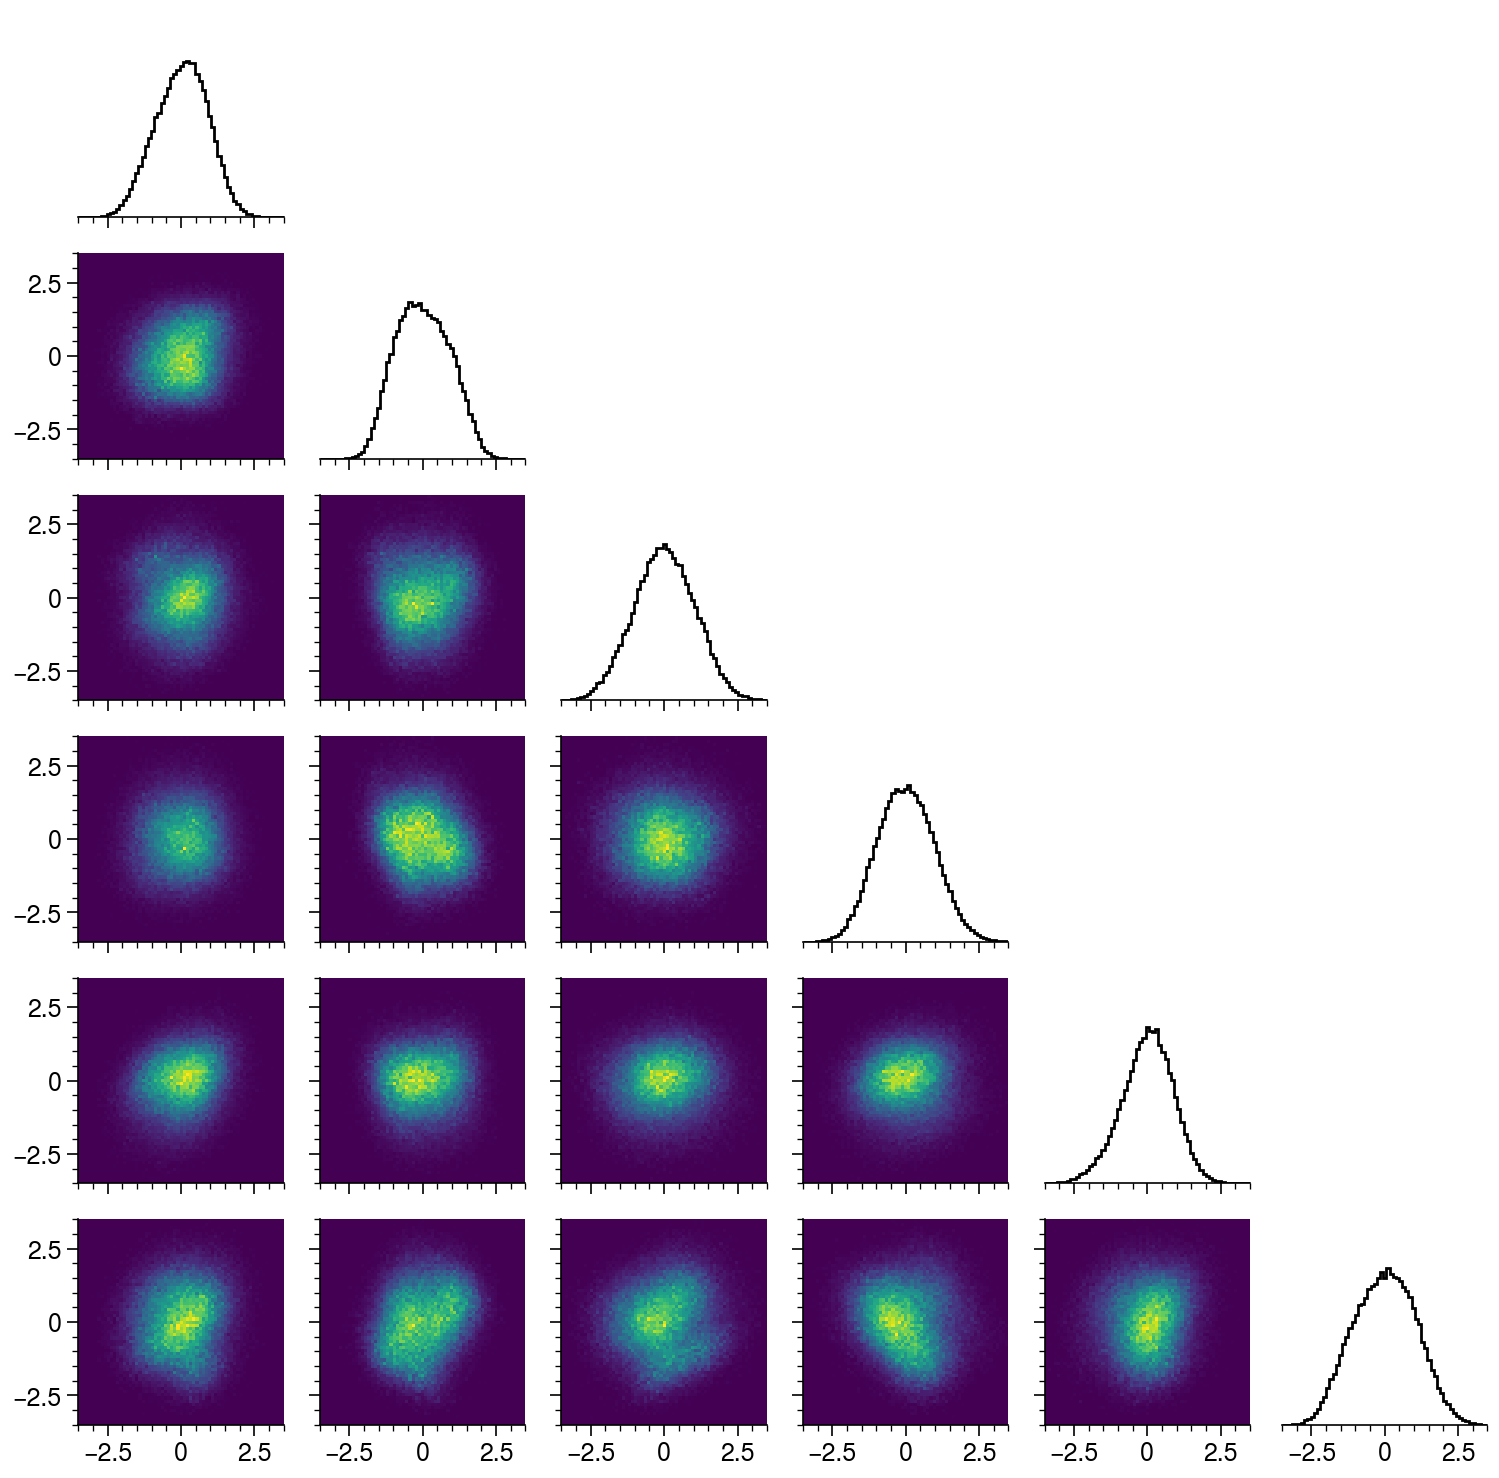

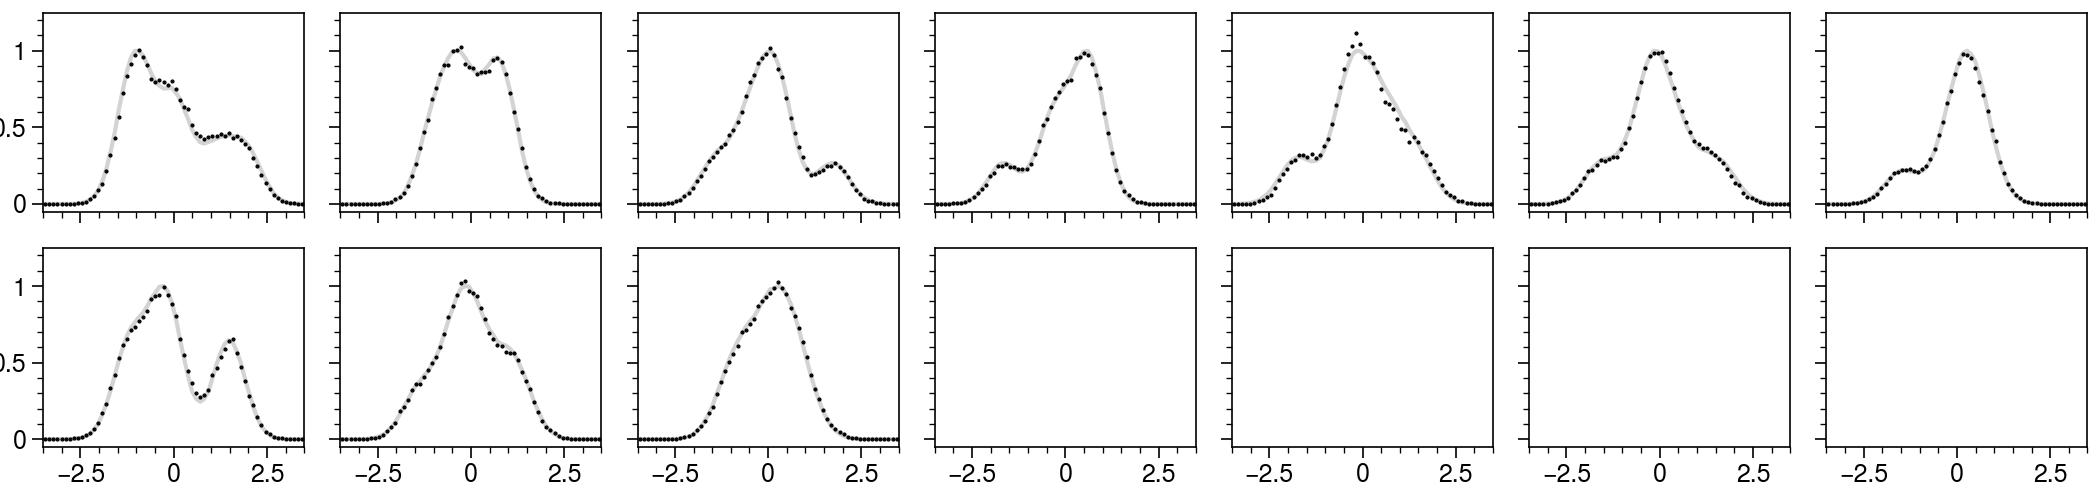

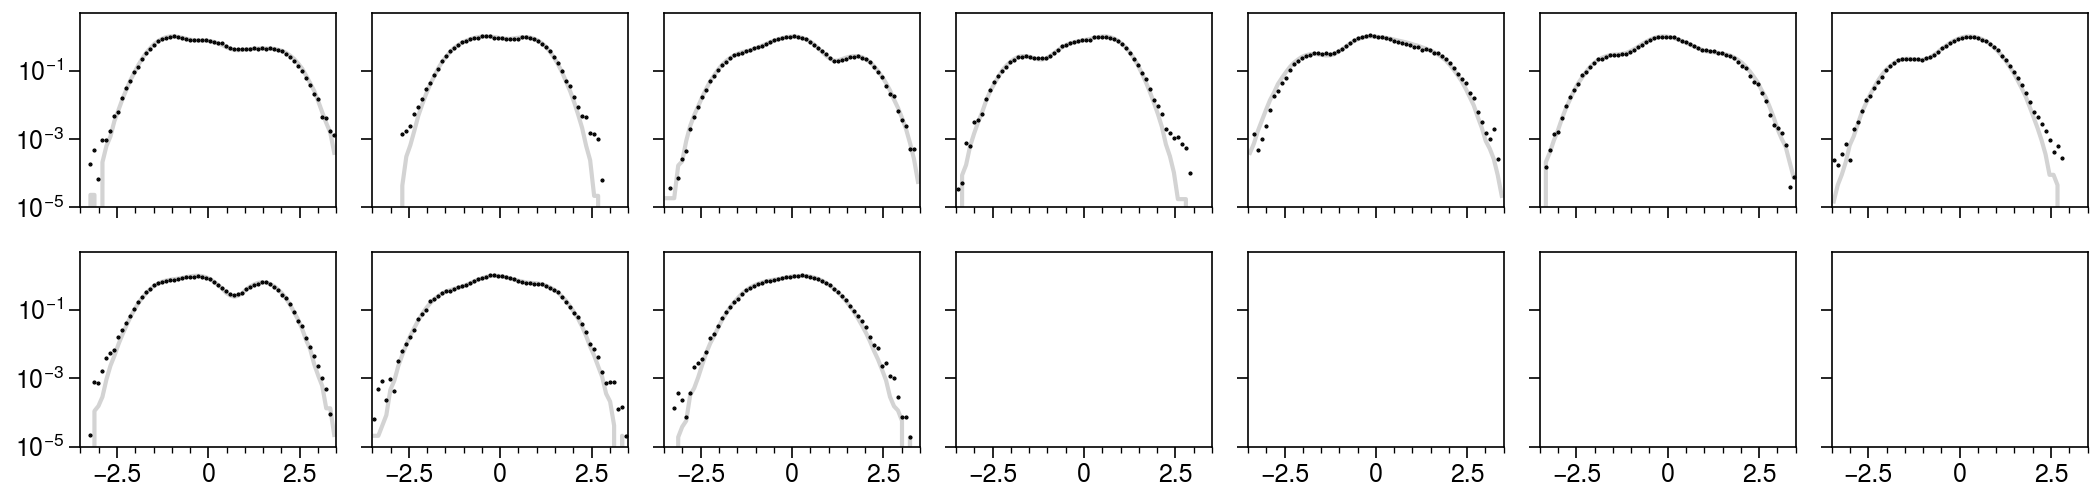

None
epoch = 3


  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 233/12015 [00:00<00:05, 2329.41it/s]

  4%|████▎                                                                                                         | 470/12015 [00:00<00:04, 2351.75it/s]

  6%|██████▍                                                                                                       | 707/12015 [00:00<00:04, 2356.71it/s]

  8%|████████▋                                                                                                     | 948/12015 [00:00<00:04, 2376.03it/s]

 10%|██████████▊                                                                                                  | 1187/12015 [00:00<00:04, 2379.77it/s]

 12%|████████████▉                                                                                                | 1425/12015 [00:00<00:04, 2356.55it/s]

 14%|███████████████                                                                                              | 1662/12015 [00:00<00:04, 2359.42it/s]

 16%|█████████████████▏                                                                                           | 1901/12015 [00:00<00:04, 2366.88it/s]

 18%|███████████████████▍                                                                                         | 2142/12015 [00:00<00:04, 2380.16it/s]

 20%|█████████████████████▋                                                                                       | 2384/12015 [00:01<00:04, 2390.57it/s]

 22%|███████████████████████▊                                                                                     | 2626/12015 [00:01<00:03, 2398.98it/s]

 24%|██████████████████████████                                                                                   | 2869/12015 [00:01<00:03, 2408.28it/s]

 26%|████████████████████████████▏                                                                                | 3110/12015 [00:01<00:03, 2408.40it/s]

 28%|██████████████████████████████▍                                                                              | 3351/12015 [00:01<00:03, 2402.37it/s]

 30%|████████████████████████████████▌                                                                            | 3592/12015 [00:01<00:03, 2397.31it/s]

 32%|██████████████████████████████████▊                                                                          | 3832/12015 [00:01<00:03, 2375.38it/s]

 34%|████████████████████████████████████▉                                                                        | 4070/12015 [00:01<00:03, 2304.09it/s]

 36%|███████████████████████████████████████                                                                      | 4302/12015 [00:01<00:03, 2307.44it/s]

 38%|█████████████████████████████████████████▏                                                                   | 4539/12015 [00:01<00:03, 2325.51it/s]

 40%|███████████████████████████████████████████▎                                                                 | 4781/12015 [00:02<00:03, 2350.71it/s]

 42%|█████████████████████████████████████████████▌                                                               | 5022/12015 [00:02<00:02, 2366.52it/s]

 44%|███████████████████████████████████████████████▋                                                             | 5260/12015 [00:02<00:02, 2370.00it/s]

 46%|█████████████████████████████████████████████████▉                                                           | 5498/12015 [00:02<00:02, 2372.00it/s]

 48%|████████████████████████████████████████████████████                                                         | 5739/12015 [00:02<00:02, 2380.67it/s]

 50%|██████████████████████████████████████████████████████▎                                                      | 5980/12015 [00:02<00:02, 2388.86it/s]

 52%|████████████████████████████████████████████████████████▍                                                    | 6221/12015 [00:02<00:02, 2393.07it/s]

 54%|██████████████████████████████████████████████████████████▌                                                  | 6462/12015 [00:02<00:02, 2397.23it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 6702/12015 [00:02<00:02, 2388.74it/s]

 58%|██████████████████████████████████████████████████████████████▉                                              | 6941/12015 [00:02<00:02, 2382.77it/s]

 60%|█████████████████████████████████████████████████████████████████▏                                           | 7180/12015 [00:03<00:02, 2376.11it/s]

 62%|███████████████████████████████████████████████████████████████████▎                                         | 7418/12015 [00:03<00:01, 2370.97it/s]

 64%|█████████████████████████████████████████████████████████████████████▍                                       | 7657/12015 [00:03<00:01, 2375.85it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 7897/12015 [00:03<00:01, 2382.93it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 8138/12015 [00:03<00:01, 2388.74it/s]

 70%|████████████████████████████████████████████████████████████████████████████                                 | 8379/12015 [00:03<00:01, 2393.52it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▏                              | 8620/12015 [00:03<00:01, 2396.27it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▍                            | 8861/12015 [00:03<00:01, 2398.06it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▌                          | 9101/12015 [00:03<00:01, 2397.45it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▊                        | 9342/12015 [00:03<00:01, 2399.48it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 9585/12015 [00:04<00:01, 2407.66it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 9828/12015 [00:04<00:00, 2414.10it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▌                 | 10070/12015 [00:04<00:00, 2401.38it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▋               | 10311/12015 [00:04<00:00, 2346.26it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▊             | 10546/12015 [00:04<00:00, 2335.94it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▉           | 10780/12015 [00:04<00:00, 2320.77it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 11013/12015 [00:04<00:00, 2275.67it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 11246/12015 [00:04<00:00, 2289.33it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 11476/12015 [00:04<00:00, 2272.16it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 11704/12015 [00:04<00:00, 2272.25it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 11934/12015 [00:05<00:00, 2279.34it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2360.54it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██                                                                                                            | 229/12015 [00:00<00:05, 2281.87it/s]

  4%|████▏                                                                                                         | 459/12015 [00:00<00:05, 2287.75it/s]

  6%|██████▎                                                                                                       | 691/12015 [00:00<00:04, 2300.53it/s]

  8%|████████▍                                                                                                     | 922/12015 [00:00<00:04, 2302.01it/s]

 10%|██████████▍                                                                                                  | 1153/12015 [00:00<00:04, 2303.87it/s]

 12%|████████████▌                                                                                                | 1386/12015 [00:00<00:04, 2312.31it/s]

 13%|██████████████▋                                                                                              | 1618/12015 [00:00<00:04, 2313.84it/s]

 15%|████████████████▊                                                                                            | 1852/12015 [00:00<00:04, 2319.43it/s]

 17%|██████████████████▉                                                                                          | 2084/12015 [00:00<00:04, 2318.97it/s]

 19%|█████████████████████                                                                                        | 2316/12015 [00:01<00:04, 2318.94it/s]

 21%|███████████████████████                                                                                      | 2549/12015 [00:01<00:04, 2319.99it/s]

 23%|█████████████████████████▏                                                                                   | 2781/12015 [00:01<00:03, 2318.81it/s]

 25%|███████████████████████████▎                                                                                 | 3014/12015 [00:01<00:03, 2321.78it/s]

 27%|█████████████████████████████▍                                                                               | 3247/12015 [00:01<00:03, 2317.87it/s]

 29%|███████████████████████████████▌                                                                             | 3479/12015 [00:01<00:03, 2313.84it/s]

 31%|█████████████████████████████████▋                                                                           | 3713/12015 [00:01<00:03, 2318.70it/s]

 33%|███████████████████████████████████▊                                                                         | 3946/12015 [00:01<00:03, 2319.45it/s]

 35%|█████████████████████████████████████▉                                                                       | 4180/12015 [00:01<00:03, 2322.81it/s]

 37%|████████████████████████████████████████                                                                     | 4413/12015 [00:01<00:03, 2320.88it/s]

 39%|██████████████████████████████████████████▏                                                                  | 4646/12015 [00:02<00:03, 2320.57it/s]

 41%|████████████████████████████████████████████▎                                                                | 4879/12015 [00:02<00:03, 2309.75it/s]

 43%|██████████████████████████████████████████████▎                                                              | 5111/12015 [00:02<00:02, 2312.08it/s]

 45%|████████████████████████████████████████████████▌                                                            | 5350/12015 [00:02<00:02, 2334.52it/s]

 47%|██████████████████████████████████████████████████▋                                                          | 5589/12015 [00:02<00:02, 2350.66it/s]

 49%|████████████████████████████████████████████████████▊                                                        | 5828/12015 [00:02<00:02, 2360.48it/s]

 51%|███████████████████████████████████████████████████████                                                      | 6069/12015 [00:02<00:02, 2375.06it/s]

 53%|█████████████████████████████████████████████████████████▏                                                   | 6308/12015 [00:02<00:02, 2377.96it/s]

 54%|███████████████████████████████████████████████████████████▍                                                 | 6548/12015 [00:02<00:02, 2383.54it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 6787/12015 [00:02<00:02, 2378.30it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 7027/12015 [00:03<00:02, 2382.59it/s]

 60%|█████████████████████████████████████████████████████████████████▉                                           | 7266/12015 [00:03<00:01, 2382.16it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 7506/12015 [00:03<00:01, 2386.53it/s]

 64%|██████████████████████████████████████████████████████████████████████▎                                      | 7746/12015 [00:03<00:01, 2390.33it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 7986/12015 [00:03<00:01, 2386.94it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 8225/12015 [00:03<00:01, 2287.55it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 8455/12015 [00:03<00:01, 2286.08it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 8693/12015 [00:03<00:01, 2312.58it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████                            | 8933/12015 [00:03<00:01, 2336.78it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 9173/12015 [00:03<00:01, 2353.85it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▍                       | 9413/12015 [00:04<00:01, 2366.59it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 9652/12015 [00:04<00:00, 2370.70it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 9893/12015 [00:04<00:00, 2380.58it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 10132/12015 [00:04<00:00, 2382.76it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▏              | 10371/12015 [00:04<00:00, 2384.29it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▎            | 10610/12015 [00:04<00:00, 2383.91it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 10851/12015 [00:04<00:00, 2390.72it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▋        | 11092/12015 [00:04<00:00, 2396.34it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 11332/12015 [00:04<00:00, 2390.09it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████    | 11573/12015 [00:04<00:00, 2395.05it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 11813/12015 [00:05<00:00, 2393.74it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2349.12it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 241/12015 [00:00<00:04, 2401.50it/s]

  4%|████▍                                                                                                         | 482/12015 [00:00<00:05, 2297.76it/s]

  6%|██████▌                                                                                                       | 718/12015 [00:00<00:04, 2324.17it/s]

  8%|████████▊                                                                                                     | 956/12015 [00:00<00:04, 2344.41it/s]

 10%|██████████▊                                                                                                  | 1195/12015 [00:00<00:04, 2360.21it/s]

 12%|█████████████                                                                                                | 1434/12015 [00:00<00:04, 2369.87it/s]

 14%|███████████████▏                                                                                             | 1675/12015 [00:00<00:04, 2381.24it/s]

 16%|█████████████████▎                                                                                           | 1914/12015 [00:00<00:04, 2369.25it/s]

 18%|███████████████████▌                                                                                         | 2154/12015 [00:00<00:04, 2378.05it/s]

 20%|█████████████████████▋                                                                                       | 2394/12015 [00:01<00:04, 2383.36it/s]

 22%|███████████████████████▉                                                                                     | 2634/12015 [00:01<00:03, 2387.32it/s]

 24%|██████████████████████████                                                                                   | 2873/12015 [00:01<00:03, 2387.69it/s]

 26%|████████████████████████████▎                                                                                | 3114/12015 [00:01<00:03, 2393.77it/s]

 28%|██████████████████████████████▍                                                                              | 3354/12015 [00:01<00:03, 2392.77it/s]

 30%|████████████████████████████████▌                                                                            | 3595/12015 [00:01<00:03, 2396.31it/s]

 32%|██████████████████████████████████▊                                                                          | 3836/12015 [00:01<00:03, 2397.77it/s]

 34%|█████████████████████████████████████                                                                        | 4079/12015 [00:01<00:03, 2406.60it/s]

 36%|███████████████████████████████████████▏                                                                     | 4320/12015 [00:01<00:03, 2406.02it/s]

 38%|█████████████████████████████████████████▍                                                                   | 4562/12015 [00:01<00:03, 2408.76it/s]

 40%|███████████████████████████████████████████▌                                                                 | 4804/12015 [00:02<00:02, 2409.55it/s]

 42%|█████████████████████████████████████████████▊                                                               | 5045/12015 [00:02<00:02, 2406.47it/s]

 44%|███████████████████████████████████████████████▉                                                             | 5286/12015 [00:02<00:02, 2406.03it/s]

 46%|██████████████████████████████████████████████████▏                                                          | 5527/12015 [00:02<00:02, 2406.61it/s]

 48%|████████████████████████████████████████████████████▎                                                        | 5769/12015 [00:02<00:02, 2408.67it/s]

 50%|██████████████████████████████████████████████████████▌                                                      | 6010/12015 [00:02<00:02, 2401.03it/s]

 52%|████████████████████████████████████████████████████████▋                                                    | 6251/12015 [00:02<00:02, 2401.19it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 6493/12015 [00:02<00:02, 2404.49it/s]

 56%|█████████████████████████████████████████████████████████████                                                | 6737/12015 [00:02<00:02, 2414.15it/s]

 58%|███████████████████████████████████████████████████████████████▎                                             | 6982/12015 [00:02<00:02, 2423.07it/s]

 60%|█████████████████████████████████████████████████████████████████▌                                           | 7225/12015 [00:03<00:01, 2424.59it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 7468/12015 [00:03<00:01, 2424.03it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 7712/12015 [00:03<00:01, 2426.10it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 7955/12015 [00:03<00:01, 2424.66it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 8199/12015 [00:03<00:01, 2427.09it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 8442/12015 [00:03<00:01, 2422.47it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 8685/12015 [00:03<00:01, 2413.62it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 8927/12015 [00:03<00:01, 2414.09it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████▏                         | 9169/12015 [00:03<00:01, 2409.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 9410/12015 [00:03<00:01, 2408.12it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▌                     | 9652/12015 [00:04<00:00, 2410.46it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▊                   | 9895/12015 [00:04<00:00, 2414.48it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 10138/12015 [00:04<00:00, 2418.17it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 10380/12015 [00:04<00:00, 2417.70it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 10622/12015 [00:04<00:00, 2412.29it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 10865/12015 [00:04<00:00, 2417.08it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 11108/12015 [00:04<00:00, 2420.40it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 11352/12015 [00:04<00:00, 2425.42it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 11596/12015 [00:04<00:00, 2428.02it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 11839/12015 [00:04<00:00, 2421.53it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:04<00:00, 2403.88it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 233/12015 [00:00<00:05, 2323.19it/s]

  4%|████▎                                                                                                         | 466/12015 [00:00<00:05, 2214.49it/s]

  6%|██████▍                                                                                                       | 698/12015 [00:00<00:05, 2260.22it/s]

  8%|████████▌                                                                                                     | 933/12015 [00:00<00:04, 2292.04it/s]

 10%|██████████▌                                                                                                  | 1167/12015 [00:00<00:04, 2307.99it/s]

 12%|████████████▋                                                                                                | 1399/12015 [00:00<00:04, 2310.92it/s]

 14%|██████████████▊                                                                                              | 1631/12015 [00:00<00:04, 2312.93it/s]

 16%|████████████████▉                                                                                            | 1864/12015 [00:00<00:04, 2316.40it/s]

 17%|███████████████████                                                                                          | 2097/12015 [00:00<00:04, 2319.49it/s]

 19%|█████████████████████▏                                                                                       | 2332/12015 [00:01<00:04, 2327.39it/s]

 21%|███████████████████████▎                                                                                     | 2567/12015 [00:01<00:04, 2333.68it/s]

 23%|█████████████████████████▍                                                                                   | 2801/12015 [00:01<00:03, 2334.09it/s]

 25%|███████████████████████████▌                                                                                 | 3036/12015 [00:01<00:03, 2336.01it/s]

 27%|█████████████████████████████▋                                                                               | 3270/12015 [00:01<00:03, 2336.43it/s]

 29%|███████████████████████████████▊                                                                             | 3504/12015 [00:01<00:03, 2333.66it/s]

 31%|█████████████████████████████████▉                                                                           | 3739/12015 [00:01<00:03, 2336.20it/s]

 33%|████████████████████████████████████                                                                         | 3974/12015 [00:01<00:03, 2337.51it/s]

 35%|██████████████████████████████████████▏                                                                      | 4208/12015 [00:01<00:03, 2337.18it/s]

 37%|████████████████████████████████████████▎                                                                    | 4442/12015 [00:01<00:03, 2336.31it/s]

 39%|██████████████████████████████████████████▍                                                                  | 4677/12015 [00:02<00:03, 2338.50it/s]

 41%|████████████████████████████████████████████▌                                                                | 4913/12015 [00:02<00:03, 2342.66it/s]

 43%|██████████████████████████████████████████████▋                                                              | 5148/12015 [00:02<00:02, 2339.18it/s]

 45%|████████████████████████████████████████████████▊                                                            | 5384/12015 [00:02<00:02, 2342.63it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 5619/12015 [00:02<00:02, 2323.83it/s]

 49%|█████████████████████████████████████████████████████                                                        | 5852/12015 [00:02<00:02, 2271.96it/s]

 51%|███████████████████████████████████████████████████████▏                                                     | 6080/12015 [00:02<00:02, 2181.57it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 6299/12015 [00:02<00:02, 2122.02it/s]

 54%|███████████████████████████████████████████████████████████▎                                                 | 6534/12015 [00:02<00:02, 2185.24it/s]

 56%|█████████████████████████████████████████████████████████████▍                                               | 6770/12015 [00:02<00:02, 2234.85it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7008/12015 [00:03<00:02, 2275.05it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 7240/12015 [00:03<00:02, 2286.70it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 7473/12015 [00:03<00:01, 2298.10it/s]

 64%|█████████████████████████████████████████████████████████████████████▉                                       | 7707/12015 [00:03<00:01, 2309.06it/s]

 66%|████████████████████████████████████████████████████████████████████████                                     | 7939/12015 [00:03<00:01, 2257.29it/s]

 68%|██████████████████████████████████████████████████████████████████████████▏                                  | 8173/12015 [00:03<00:01, 2279.87it/s]

 70%|████████████████████████████████████████████████████████████████████████████▎                                | 8408/12015 [00:03<00:01, 2299.35it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 8642/12015 [00:03<00:01, 2307.71it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 8875/12015 [00:03<00:01, 2312.13it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 9109/12015 [00:03<00:01, 2318.03it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 9341/12015 [00:04<00:01, 2317.19it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 9575/12015 [00:04<00:01, 2322.34it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▉                    | 9810/12015 [00:04<00:00, 2329.47it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 10043/12015 [00:04<00:00, 2324.26it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 10276/12015 [00:04<00:00, 2285.70it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 10505/12015 [00:04<00:00, 2271.33it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 10733/12015 [00:04<00:00, 2252.12it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 10963/12015 [00:04<00:00, 2265.42it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11193/12015 [00:04<00:00, 2273.01it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 11423/12015 [00:04<00:00, 2279.91it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 11652/12015 [00:05<00:00, 2282.25it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 11883/12015 [00:05<00:00, 2288.43it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2295.60it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 239/12015 [00:00<00:04, 2382.02it/s]

  4%|████▍                                                                                                         | 478/12015 [00:00<00:04, 2382.09it/s]

  6%|██████▌                                                                                                       | 719/12015 [00:00<00:04, 2392.59it/s]

  8%|████████▊                                                                                                     | 959/12015 [00:00<00:04, 2387.34it/s]

 10%|██████████▊                                                                                                  | 1198/12015 [00:00<00:04, 2361.69it/s]

 12%|█████████████                                                                                                | 1440/12015 [00:00<00:04, 2379.95it/s]

 14%|███████████████▎                                                                                             | 1681/12015 [00:00<00:04, 2389.47it/s]

 16%|█████████████████▍                                                                                           | 1925/12015 [00:00<00:04, 2402.74it/s]

 18%|███████████████████▋                                                                                         | 2167/12015 [00:00<00:04, 2407.80it/s]

 20%|█████████████████████▊                                                                                       | 2410/12015 [00:01<00:03, 2411.63it/s]

 22%|████████████████████████                                                                                     | 2652/12015 [00:01<00:03, 2398.85it/s]

 24%|██████████████████████████▏                                                                                  | 2892/12015 [00:01<00:03, 2388.78it/s]

 26%|████████████████████████████▍                                                                                | 3133/12015 [00:01<00:03, 2392.79it/s]

 28%|██████████████████████████████▌                                                                              | 3375/12015 [00:01<00:03, 2400.24it/s]

 30%|████████████████████████████████▊                                                                            | 3616/12015 [00:01<00:03, 2400.22it/s]

 32%|██████████████████████████████████▉                                                                          | 3858/12015 [00:01<00:03, 2403.69it/s]

 34%|█████████████████████████████████████▏                                                                       | 4099/12015 [00:01<00:03, 2398.90it/s]

 36%|███████████████████████████████████████▍                                                                     | 4341/12015 [00:01<00:03, 2403.90it/s]

 38%|█████████████████████████████████████████▌                                                                   | 4582/12015 [00:01<00:03, 2397.70it/s]

 40%|███████████████████████████████████████████▊                                                                 | 4824/12015 [00:02<00:02, 2401.54it/s]

 42%|█████████████████████████████████████████████▉                                                               | 5065/12015 [00:02<00:02, 2402.32it/s]

 44%|████████████████████████████████████████████████▏                                                            | 5306/12015 [00:02<00:02, 2402.87it/s]

 46%|██████████████████████████████████████████████████▎                                                          | 5548/12015 [00:02<00:02, 2407.24it/s]

 48%|████████████████████████████████████████████████████▌                                                        | 5789/12015 [00:02<00:02, 2401.43it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 6030/12015 [00:02<00:02, 2395.84it/s]

 52%|████████████████████████████████████████████████████████▉                                                    | 6272/12015 [00:02<00:02, 2401.27it/s]

 54%|███████████████████████████████████████████████████████████                                                  | 6515/12015 [00:02<00:02, 2407.80it/s]

 56%|█████████████████████████████████████████████████████████████▎                                               | 6758/12015 [00:02<00:02, 2414.02it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7000/12015 [00:02<00:02, 2414.72it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 7243/12015 [00:03<00:01, 2418.28it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 7486/12015 [00:03<00:01, 2419.75it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 7728/12015 [00:03<00:01, 2415.03it/s]

 66%|████████████████████████████████████████████████████████████████████████▎                                    | 7970/12015 [00:03<00:01, 2357.94it/s]

 68%|██████████████████████████████████████████████████████████████████████████▍                                  | 8207/12015 [00:03<00:01, 2279.29it/s]

 70%|████████████████████████████████████████████████████████████████████████████▌                                | 8436/12015 [00:03<00:01, 2229.85it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 8678/12015 [00:03<00:01, 2281.98it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 8915/12015 [00:03<00:01, 2307.21it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 9158/12015 [00:03<00:01, 2342.60it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▎                       | 9402/12015 [00:03<00:01, 2368.63it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▍                     | 9645/12015 [00:04<00:00, 2385.47it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▋                   | 9890/12015 [00:04<00:00, 2404.13it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████                 | 10134/12015 [00:04<00:00, 2413.98it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████▎              | 10379/12015 [00:04<00:00, 2422.24it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████▍            | 10622/12015 [00:04<00:00, 2424.28it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 10866/12015 [00:04<00:00, 2427.95it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 11110/12015 [00:04<00:00, 2429.77it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████      | 11354/12015 [00:04<00:00, 2431.27it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 11598/12015 [00:04<00:00, 2431.64it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 11842/12015 [00:04<00:00, 2431.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2392.86it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██                                                                                                            | 223/12015 [00:00<00:05, 2221.91it/s]

  4%|████                                                                                                          | 450/12015 [00:00<00:05, 2246.95it/s]

  6%|██████▏                                                                                                       | 675/12015 [00:00<00:05, 2242.64it/s]

  7%|████████▏                                                                                                     | 900/12015 [00:00<00:04, 2245.15it/s]

  9%|██████████▏                                                                                                  | 1126/12015 [00:00<00:04, 2249.56it/s]

 11%|████████████▎                                                                                                | 1354/12015 [00:00<00:04, 2257.77it/s]

 13%|██████████████▎                                                                                              | 1581/12015 [00:00<00:04, 2259.23it/s]

 15%|████████████████▍                                                                                            | 1807/12015 [00:00<00:04, 2255.05it/s]

 17%|██████████████████▍                                                                                          | 2036/12015 [00:00<00:04, 2263.62it/s]

 19%|████████████████████▌                                                                                        | 2265/12015 [00:01<00:04, 2270.07it/s]

 21%|██████████████████████▌                                                                                      | 2493/12015 [00:01<00:04, 2268.86it/s]

 23%|████████████████████████▋                                                                                    | 2720/12015 [00:01<00:04, 2268.39it/s]

 25%|██████████████████████████▋                                                                                  | 2947/12015 [00:01<00:04, 2265.77it/s]

 26%|████████████████████████████▊                                                                                | 3174/12015 [00:01<00:03, 2263.92it/s]

 28%|██████████████████████████████▊                                                                              | 3401/12015 [00:01<00:03, 2250.60it/s]

 30%|████████████████████████████████▉                                                                            | 3627/12015 [00:01<00:03, 2248.23it/s]

 32%|██████████████████████████████████▉                                                                          | 3852/12015 [00:01<00:03, 2242.93it/s]

 34%|█████████████████████████████████████                                                                        | 4080/12015 [00:01<00:03, 2252.56it/s]

 36%|███████████████████████████████████████                                                                      | 4306/12015 [00:01<00:03, 2251.31it/s]

 38%|█████████████████████████████████████████▏                                                                   | 4535/12015 [00:02<00:03, 2260.38it/s]

 40%|███████████████████████████████████████████▏                                                                 | 4762/12015 [00:02<00:03, 2262.64it/s]

 42%|█████████████████████████████████████████████▎                                                               | 4989/12015 [00:02<00:03, 2256.49it/s]

 43%|███████████████████████████████████████████████▎                                                             | 5215/12015 [00:02<00:03, 2252.90it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 5441/12015 [00:02<00:02, 2247.88it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 5668/12015 [00:02<00:02, 2253.02it/s]

 49%|█████████████████████████████████████████████████████▍                                                       | 5895/12015 [00:02<00:02, 2256.36it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 6121/12015 [00:02<00:02, 2216.04it/s]

 53%|█████████████████████████████████████████████████████████▌                                                   | 6343/12015 [00:02<00:02, 2209.73it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 6565/12015 [00:02<00:02, 2210.31it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 6787/12015 [00:03<00:02, 2208.23it/s]

 58%|███████████████████████████████████████████████████████████████▌                                             | 7009/12015 [00:03<00:02, 2209.18it/s]

 60%|█████████████████████████████████████████████████████████████████▋                                           | 7234/12015 [00:03<00:02, 2220.32it/s]

 62%|███████████████████████████████████████████████████████████████████▋                                         | 7459/12015 [00:03<00:02, 2228.78it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 7683/12015 [00:03<00:01, 2229.94it/s]

 66%|███████████████████████████████████████████████████████████████████████▋                                     | 7908/12015 [00:03<00:01, 2233.75it/s]

 68%|█████████████████████████████████████████████████████████████████████████▊                                   | 8134/12015 [00:03<00:01, 2239.60it/s]

 70%|███████████████████████████████████████████████████████████████████████████▊                                 | 8358/12015 [00:03<00:01, 2239.28it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▊                               | 8584/12015 [00:03<00:01, 2244.62it/s]

 73%|███████████████████████████████████████████████████████████████████████████████▉                             | 8809/12015 [00:03<00:01, 2245.60it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████▉                           | 9034/12015 [00:04<00:01, 2240.41it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████                         | 9261/12015 [00:04<00:01, 2249.13it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████                       | 9491/12015 [00:04<00:01, 2262.80it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████▏                    | 9723/12015 [00:04<00:01, 2279.03it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████▎                  | 9951/12015 [00:04<00:00, 2275.68it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████▌                | 10182/12015 [00:04<00:00, 2284.13it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▌              | 10411/12015 [00:04<00:00, 2282.21it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 10641/12015 [00:04<00:00, 2285.92it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▋          | 10870/12015 [00:04<00:00, 2278.02it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▊        | 11098/12015 [00:04<00:00, 2270.02it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 11327/12015 [00:05<00:00, 2273.27it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 11556/12015 [00:05<00:00, 2277.72it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 11784/12015 [00:05<00:00, 2257.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 12010/12015 [00:05<00:00, 2244.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2250.58it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██                                                                                                            | 222/12015 [00:00<00:05, 2218.75it/s]

  4%|████                                                                                                          | 445/12015 [00:00<00:05, 2220.32it/s]

  6%|██████                                                                                                        | 669/12015 [00:00<00:05, 2228.82it/s]

  7%|████████▏                                                                                                     | 895/12015 [00:00<00:04, 2240.13it/s]

  9%|██████████▏                                                                                                  | 1120/12015 [00:00<00:04, 2243.04it/s]

 11%|████████████▏                                                                                                | 1346/12015 [00:00<00:04, 2246.13it/s]

 13%|██████████████▎                                                                                              | 1573/12015 [00:00<00:04, 2251.90it/s]

 15%|████████████████▎                                                                                            | 1799/12015 [00:00<00:04, 2240.04it/s]

 17%|██████████████████▎                                                                                          | 2024/12015 [00:00<00:04, 2229.44it/s]

 19%|████████████████████▍                                                                                        | 2247/12015 [00:01<00:04, 2228.89it/s]

 21%|██████████████████████▍                                                                                      | 2472/12015 [00:01<00:04, 2234.42it/s]

 22%|████████████████████████▌                                                                                    | 2701/12015 [00:01<00:04, 2248.98it/s]

 24%|██████████████████████████▌                                                                                  | 2926/12015 [00:01<00:04, 2246.41it/s]

 26%|████████████████████████████▌                                                                                | 3153/12015 [00:01<00:03, 2253.02it/s]

 28%|██████████████████████████████▋                                                                              | 3379/12015 [00:01<00:03, 2240.48it/s]

 30%|████████████████████████████████▋                                                                            | 3604/12015 [00:01<00:03, 2203.37it/s]

 32%|██████████████████████████████████▋                                                                          | 3825/12015 [00:01<00:03, 2171.76it/s]

 34%|████████████████████████████████████▊                                                                        | 4057/12015 [00:01<00:03, 2213.30it/s]

 36%|██████████████████████████████████████▉                                                                      | 4288/12015 [00:01<00:03, 2241.03it/s]

 38%|█████████████████████████████████████████                                                                    | 4521/12015 [00:02<00:03, 2265.46it/s]

 40%|███████████████████████████████████████████                                                                  | 4751/12015 [00:02<00:03, 2274.38it/s]

 41%|█████████████████████████████████████████████▏                                                               | 4985/12015 [00:02<00:03, 2293.70it/s]

 43%|███████████████████████████████████████████████▎                                                             | 5216/12015 [00:02<00:02, 2297.22it/s]

 45%|█████████████████████████████████████████████████▍                                                           | 5451/12015 [00:02<00:02, 2311.03it/s]

 47%|███████████████████████████████████████████████████▌                                                         | 5685/12015 [00:02<00:02, 2318.53it/s]

 49%|█████████████████████████████████████████████████████▋                                                       | 5918/12015 [00:02<00:02, 2320.23it/s]

 51%|███████████████████████████████████████████████████████▊                                                     | 6152/12015 [00:02<00:02, 2323.26it/s]

 53%|█████████████████████████████████████████████████████████▉                                                   | 6387/12015 [00:02<00:02, 2330.62it/s]

 55%|████████████████████████████████████████████████████████████                                                 | 6621/12015 [00:02<00:02, 2326.52it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 6855/12015 [00:03<00:02, 2329.74it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 7088/12015 [00:03<00:02, 2318.35it/s]

 61%|██████████████████████████████████████████████████████████████████▍                                          | 7321/12015 [00:03<00:02, 2318.81it/s]

 63%|████████████████████████████████████████████████████████████████████▌                                        | 7553/12015 [00:03<00:01, 2284.98it/s]

 65%|██████████████████████████████████████████████████████████████████████▌                                      | 7782/12015 [00:03<00:01, 2193.68it/s]

 67%|████████████████████████████████████████████████████████████████████████▌                                    | 8003/12015 [00:03<00:01, 2162.12it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 8223/12015 [00:03<00:01, 2171.73it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 8449/12015 [00:03<00:01, 2196.39it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▋                              | 8676/12015 [00:03<00:01, 2217.18it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▊                            | 8905/12015 [00:03<00:01, 2237.45it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 9132/12015 [00:04<00:01, 2244.44it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 9360/12015 [00:04<00:01, 2253.67it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▉                      | 9589/12015 [00:04<00:01, 2262.62it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████                    | 9818/12015 [00:04<00:00, 2270.25it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▎                 | 10046/12015 [00:04<00:00, 2253.39it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▎               | 10275/12015 [00:04<00:00, 2263.01it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▍             | 10502/12015 [00:04<00:00, 2260.74it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▍           | 10730/12015 [00:04<00:00, 2265.59it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 10959/12015 [00:04<00:00, 2270.26it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 11187/12015 [00:04<00:00, 2271.53it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 11415/12015 [00:05<00:00, 2270.44it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 11643/12015 [00:05<00:00, 2272.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 11871/12015 [00:05<00:00, 2262.85it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2257.20it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|█▉                                                                                                            | 210/12015 [00:00<00:05, 2093.24it/s]

  4%|████                                                                                                          | 437/12015 [00:00<00:05, 2190.84it/s]

  6%|██████                                                                                                        | 662/12015 [00:00<00:05, 2215.56it/s]

  7%|████████▏                                                                                                     | 888/12015 [00:00<00:04, 2232.77it/s]

  9%|██████████▏                                                                                                  | 1117/12015 [00:00<00:04, 2250.66it/s]

 11%|████████████▏                                                                                                | 1343/12015 [00:00<00:04, 2252.91it/s]

 13%|██████████████▎                                                                                              | 1573/12015 [00:00<00:04, 2267.19it/s]

 15%|████████████████▎                                                                                            | 1800/12015 [00:00<00:04, 2256.23it/s]

 17%|██████████████████▍                                                                                          | 2028/12015 [00:00<00:04, 2261.95it/s]

 19%|████████████████████▌                                                                                        | 2260/12015 [00:01<00:04, 2278.36it/s]

 21%|██████████████████████▌                                                                                      | 2488/12015 [00:01<00:04, 2238.89it/s]

 23%|████████████████████████▌                                                                                    | 2713/12015 [00:01<00:04, 2240.46it/s]

 24%|██████████████████████████▋                                                                                  | 2940/12015 [00:01<00:04, 2248.17it/s]

 26%|████████████████████████████▋                                                                                | 3167/12015 [00:01<00:03, 2252.89it/s]

 28%|██████████████████████████████▊                                                                              | 3393/12015 [00:01<00:03, 2248.73it/s]

 30%|████████████████████████████████▊                                                                            | 3622/12015 [00:01<00:03, 2260.55it/s]

 32%|██████████████████████████████████▉                                                                          | 3849/12015 [00:01<00:03, 2255.54it/s]

 34%|████████████████████████████████████▉                                                                        | 4075/12015 [00:01<00:03, 2249.14it/s]

 36%|███████████████████████████████████████                                                                      | 4303/12015 [00:01<00:03, 2254.73it/s]

 38%|█████████████████████████████████████████                                                                    | 4531/12015 [00:02<00:03, 2259.56it/s]

 40%|███████████████████████████████████████████▏                                                                 | 4758/12015 [00:02<00:03, 2261.96it/s]

 41%|█████████████████████████████████████████████▏                                                               | 4985/12015 [00:02<00:03, 2247.53it/s]

 43%|███████████████████████████████████████████████▎                                                             | 5212/12015 [00:02<00:03, 2253.97it/s]

 45%|█████████████████████████████████████████████████▎                                                           | 5440/12015 [00:02<00:02, 2260.11it/s]

 47%|███████████████████████████████████████████████████▍                                                         | 5669/12015 [00:02<00:02, 2266.99it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 5898/12015 [00:02<00:02, 2271.24it/s]

 51%|███████████████████████████████████████████████████████▌                                                     | 6128/12015 [00:02<00:02, 2278.38it/s]

 53%|█████████████████████████████████████████████████████████▋                                                   | 6357/12015 [00:02<00:02, 2280.39it/s]

 55%|███████████████████████████████████████████████████████████▊                                                 | 6588/12015 [00:02<00:02, 2288.88it/s]

 57%|█████████████████████████████████████████████████████████████▊                                               | 6817/12015 [00:03<00:02, 2281.28it/s]

 59%|███████████████████████████████████████████████████████████████▉                                             | 7046/12015 [00:03<00:02, 2281.49it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                           | 7275/12015 [00:03<00:02, 2280.80it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 7504/12015 [00:03<00:01, 2280.79it/s]

 64%|██████████████████████████████████████████████████████████████████████▏                                      | 7733/12015 [00:03<00:01, 2270.68it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 7961/12015 [00:03<00:01, 2248.13it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 8187/12015 [00:03<00:01, 2249.92it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 8419/12015 [00:03<00:01, 2269.34it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 8650/12015 [00:03<00:01, 2278.84it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▌                            | 8880/12015 [00:03<00:01, 2282.13it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▋                          | 9109/12015 [00:04<00:01, 2270.70it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▋                        | 9337/12015 [00:04<00:01, 2265.65it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                      | 9567/12015 [00:04<00:01, 2275.55it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▊                    | 9796/12015 [00:04<00:00, 2279.73it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████                  | 10024/12015 [00:04<00:00, 2269.01it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 10252/12015 [00:04<00:00, 2269.73it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████▏             | 10479/12015 [00:04<00:00, 2266.57it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████▏           | 10707/12015 [00:04<00:00, 2268.14it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▎         | 10937/12015 [00:04<00:00, 2275.25it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 11165/12015 [00:04<00:00, 2275.69it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 11396/12015 [00:05<00:00, 2285.05it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 11627/12015 [00:05<00:00, 2291.60it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 11860/12015 [00:05<00:00, 2300.63it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2265.91it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 233/12015 [00:00<00:05, 2327.83it/s]

  4%|████▎                                                                                                         | 467/12015 [00:00<00:04, 2331.14it/s]

  6%|██████▍                                                                                                       | 702/12015 [00:00<00:04, 2338.48it/s]

  8%|████████▌                                                                                                     | 936/12015 [00:00<00:04, 2314.01it/s]

 10%|██████████▌                                                                                                  | 1171/12015 [00:00<00:04, 2323.80it/s]

 12%|████████████▋                                                                                                | 1405/12015 [00:00<00:04, 2326.18it/s]

 14%|██████████████▊                                                                                              | 1638/12015 [00:00<00:04, 2321.98it/s]

 16%|████████████████▉                                                                                            | 1872/12015 [00:00<00:04, 2326.75it/s]

 18%|███████████████████                                                                                          | 2105/12015 [00:00<00:04, 2321.86it/s]

 19%|█████████████████████▏                                                                                       | 2338/12015 [00:01<00:04, 2317.51it/s]

 21%|███████████████████████▎                                                                                     | 2571/12015 [00:01<00:04, 2320.77it/s]

 23%|█████████████████████████▍                                                                                   | 2805/12015 [00:01<00:03, 2325.99it/s]

 25%|███████████████████████████▌                                                                                 | 3039/12015 [00:01<00:03, 2329.89it/s]

 27%|█████████████████████████████▋                                                                               | 3273/12015 [00:01<00:03, 2331.99it/s]

 29%|███████████████████████████████▊                                                                             | 3508/12015 [00:01<00:03, 2335.20it/s]

 31%|█████████████████████████████████▉                                                                           | 3742/12015 [00:01<00:03, 2326.51it/s]

 33%|████████████████████████████████████                                                                         | 3975/12015 [00:01<00:03, 2324.13it/s]

 35%|██████████████████████████████████████▏                                                                      | 4208/12015 [00:01<00:03, 2324.43it/s]

 37%|████████████████████████████████████████▎                                                                    | 4444/12015 [00:01<00:03, 2333.53it/s]

 39%|██████████████████████████████████████████▍                                                                  | 4678/12015 [00:02<00:03, 2331.90it/s]

 41%|████████████████████████████████████████████▌                                                                | 4913/12015 [00:02<00:03, 2334.59it/s]

 43%|██████████████████████████████████████████████▋                                                              | 5147/12015 [00:02<00:02, 2327.40it/s]

 45%|████████████████████████████████████████████████▊                                                            | 5383/12015 [00:02<00:02, 2333.74it/s]

 47%|██████████████████████████████████████████████████▉                                                          | 5617/12015 [00:02<00:02, 2334.05it/s]

 49%|█████████████████████████████████████████████████████                                                        | 5851/12015 [00:02<00:02, 2330.42it/s]

 51%|███████████████████████████████████████████████████████▏                                                     | 6085/12015 [00:02<00:02, 2331.44it/s]

 53%|█████████████████████████████████████████████████████████▎                                                   | 6320/12015 [00:02<00:02, 2334.72it/s]

 55%|███████████████████████████████████████████████████████████▍                                                 | 6554/12015 [00:02<00:02, 2323.56it/s]

 56%|█████████████████████████████████████████████████████████████▌                                               | 6787/12015 [00:02<00:02, 2321.45it/s]

 58%|███████████████████████████████████████████████████████████████▋                                             | 7020/12015 [00:03<00:02, 2318.20it/s]

 60%|█████████████████████████████████████████████████████████████████▊                                           | 7252/12015 [00:03<00:02, 2311.73it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 7486/12015 [00:03<00:01, 2318.88it/s]

 64%|██████████████████████████████████████████████████████████████████████                                       | 7721/12015 [00:03<00:01, 2328.09it/s]

 66%|████████████████████████████████████████████████████████████████████████▏                                    | 7954/12015 [00:03<00:01, 2328.31it/s]

 68%|██████████████████████████████████████████████████████████████████████████▎                                  | 8187/12015 [00:03<00:01, 2328.39it/s]

 70%|████████████████████████████████████████████████████████████████████████████▍                                | 8420/12015 [00:03<00:01, 2327.06it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▍                              | 8653/12015 [00:03<00:01, 2327.86it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▋                            | 8889/12015 [00:03<00:01, 2334.56it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████▊                          | 9123/12015 [00:03<00:01, 2336.10it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████▉                        | 9358/12015 [00:04<00:01, 2337.44it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████                      | 9593/12015 [00:04<00:01, 2338.90it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▏                   | 9828/12015 [00:04<00:00, 2341.63it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 10063/12015 [00:04<00:00, 2341.60it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▌               | 10300/12015 [00:04<00:00, 2349.74it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▋             | 10535/12015 [00:04<00:00, 2348.33it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▊           | 10770/12015 [00:04<00:00, 2341.73it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████▉         | 11005/12015 [00:04<00:00, 2335.15it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████       | 11239/12015 [00:04<00:00, 2331.45it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 11473/12015 [00:04<00:00, 2333.23it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 11707/12015 [00:05<00:00, 2333.17it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 11942/12015 [00:05<00:00, 2335.52it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2329.90it/s]

  0%|                                                                                                                          | 0/12015 [00:00<?, ?it/s]

  2%|██▏                                                                                                           | 235/12015 [00:00<00:05, 2349.65it/s]

  4%|████▎                                                                                                         | 470/12015 [00:00<00:04, 2347.00it/s]

  6%|██████▍                                                                                                       | 705/12015 [00:00<00:04, 2343.28it/s]

  8%|████████▌                                                                                                     | 941/12015 [00:00<00:04, 2349.18it/s]

 10%|██████████▋                                                                                                  | 1176/12015 [00:00<00:04, 2348.73it/s]

 12%|████████████▊                                                                                                | 1411/12015 [00:00<00:04, 2316.97it/s]

 14%|██████████████▉                                                                                              | 1643/12015 [00:00<00:04, 2291.16it/s]

 16%|█████████████████                                                                                            | 1877/12015 [00:00<00:04, 2303.87it/s]

 18%|███████████████████▏                                                                                         | 2111/12015 [00:00<00:04, 2312.65it/s]

 20%|█████████████████████▎                                                                                       | 2345/12015 [00:01<00:04, 2320.46it/s]

 21%|███████████████████████▍                                                                                     | 2578/12015 [00:01<00:04, 2320.85it/s]

 23%|█████████████████████████▌                                                                                   | 2812/12015 [00:01<00:03, 2325.86it/s]

 25%|███████████████████████████▋                                                                                 | 3046/12015 [00:01<00:03, 2329.68it/s]

 27%|█████████████████████████████▊                                                                               | 3280/12015 [00:01<00:03, 2330.74it/s]

 29%|███████████████████████████████▉                                                                             | 3515/12015 [00:01<00:03, 2334.74it/s]

 31%|██████████████████████████████████                                                                           | 3751/12015 [00:01<00:03, 2339.59it/s]

 33%|████████████████████████████████████▏                                                                        | 3986/12015 [00:01<00:03, 2342.08it/s]

 35%|██████████████████████████████████████▎                                                                      | 4221/12015 [00:01<00:03, 2342.27it/s]

 37%|████████████████████████████████████████▍                                                                    | 4456/12015 [00:01<00:03, 2338.33it/s]

 39%|██████████████████████████████████████████▌                                                                  | 4692/12015 [00:02<00:03, 2342.07it/s]

 41%|████████████████████████████████████████████▋                                                                | 4927/12015 [00:02<00:03, 2343.64it/s]

 43%|██████████████████████████████████████████████▊                                                              | 5162/12015 [00:02<00:02, 2337.08it/s]

 45%|████████████████████████████████████████████████▉                                                            | 5396/12015 [00:02<00:02, 2336.15it/s]

 47%|███████████████████████████████████████████████████                                                          | 5631/12015 [00:02<00:02, 2339.57it/s]

 49%|█████████████████████████████████████████████████████▏                                                       | 5865/12015 [00:02<00:02, 2336.11it/s]

 51%|███████████████████████████████████████████████████████▎                                                     | 6100/12015 [00:02<00:02, 2338.39it/s]

 53%|█████████████████████████████████████████████████████████▍                                                   | 6335/12015 [00:02<00:02, 2340.23it/s]

 55%|███████████████████████████████████████████████████████████▌                                                 | 6570/12015 [00:02<00:02, 2336.74it/s]

 57%|█████████████████████████████████████████████████████████████▋                                               | 6805/12015 [00:02<00:02, 2337.92it/s]

 59%|███████████████████████████████████████████████████████████████▊                                             | 7039/12015 [00:03<00:02, 2336.56it/s]

 61%|█████████████████████████████████████████████████████████████████▉                                           | 7274/12015 [00:03<00:02, 2339.96it/s]

 62%|████████████████████████████████████████████████████████████████████                                         | 7509/12015 [00:03<00:01, 2340.75it/s]

 64%|██████████████████████████████████████████████████████████████████████▎                                      | 7744/12015 [00:03<00:01, 2338.00it/s]

 66%|████████████████████████████████████████████████████████████████████████▍                                    | 7978/12015 [00:03<00:01, 2337.82it/s]

 68%|██████████████████████████████████████████████████████████████████████████▌                                  | 8213/12015 [00:03<00:01, 2341.09it/s]

 70%|████████████████████████████████████████████████████████████████████████████▋                                | 8448/12015 [00:03<00:01, 2335.00it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▊                              | 8682/12015 [00:03<00:01, 2334.07it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▉                            | 8917/12015 [00:03<00:01, 2336.96it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████                          | 9152/12015 [00:03<00:01, 2338.56it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████▏                       | 9387/12015 [00:04<00:01, 2340.90it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████▎                     | 9622/12015 [00:04<00:01, 2342.58it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████▍                   | 9857/12015 [00:04<00:00, 2344.26it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▋                 | 10092/12015 [00:04<00:00, 2344.36it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████▊               | 10328/12015 [00:04<00:00, 2348.52it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 10564/12015 [00:04<00:00, 2350.98it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████           | 10800/12015 [00:04<00:00, 2351.38it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▏        | 11036/12015 [00:04<00:00, 2345.91it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 11271/12015 [00:04<00:00, 2333.75it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 11505/12015 [00:04<00:00, 2329.76it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 11741/12015 [00:05<00:00, 2336.74it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 11975/12015 [00:05<00:00, 2337.30it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12015/12015 [00:05<00:00, 2335.80it/s]

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  2%|█▊                                                                                                            | 234/14031 [00:00<00:05, 2330.39it/s]

  3%|███▋                                                                                                          | 468/14031 [00:00<00:05, 2329.05it/s]

  5%|█████▌                                                                                                        | 703/14031 [00:00<00:05, 2334.47it/s]

  7%|███████▎                                                                                                      | 938/14031 [00:00<00:05, 2337.58it/s]

  8%|█████████                                                                                                    | 1172/14031 [00:00<00:05, 2338.16it/s]

 10%|██████████▉                                                                                                  | 1406/14031 [00:00<00:05, 2337.48it/s]

 12%|████████████▋                                                                                                | 1640/14031 [00:00<00:05, 2301.03it/s]

 13%|██████████████▌                                                                                              | 1871/14031 [00:00<00:05, 2292.71it/s]

 15%|████████████████▎                                                                                            | 2101/14031 [00:00<00:05, 2288.62it/s]

 17%|██████████████████                                                                                           | 2330/14031 [00:01<00:05, 2288.85it/s]

 18%|███████████████████▉                                                                                         | 2559/14031 [00:01<00:05, 2289.02it/s]

 20%|█████████████████████▋                                                                                       | 2788/14031 [00:01<00:04, 2284.74it/s]

 22%|███████████████████████▍                                                                                     | 3017/14031 [00:01<00:04, 2274.83it/s]

 23%|█████████████████████████▎                                                                                   | 3253/14031 [00:01<00:04, 2300.36it/s]

 25%|███████████████████████████                                                                                  | 3486/14031 [00:01<00:04, 2306.38it/s]

 26%|████████████████████████████▉                                                                                | 3717/14031 [00:01<00:04, 2301.60it/s]

 28%|██████████████████████████████▋                                                                              | 3948/14031 [00:01<00:04, 2299.30it/s]

 30%|████████████████████████████████▍                                                                            | 4183/14031 [00:01<00:04, 2314.41it/s]

 32%|██████████████████████████████████▎                                                                          | 4420/14031 [00:01<00:04, 2329.82it/s]

 33%|████████████████████████████████████▏                                                                        | 4657/14031 [00:02<00:04, 2340.44it/s]

 35%|██████████████████████████████████████                                                                       | 4893/14031 [00:02<00:03, 2345.52it/s]

 37%|███████████████████████████████████████▊                                                                     | 5128/14031 [00:02<00:03, 2343.45it/s]

 38%|█████████████████████████████████████████▋                                                                   | 5366/14031 [00:02<00:03, 2353.30it/s]

 40%|███████████████████████████████████████████▌                                                                 | 5605/14031 [00:02<00:03, 2363.47it/s]

 42%|█████████████████████████████████████████████▍                                                               | 5845/14031 [00:02<00:03, 2374.02it/s]

 43%|███████████████████████████████████████████████▎                                                             | 6086/14031 [00:02<00:03, 2382.98it/s]

 45%|█████████████████████████████████████████████████▏                                                           | 6327/14031 [00:02<00:03, 2390.09it/s]

 47%|███████████████████████████████████████████████████                                                          | 6567/14031 [00:02<00:03, 2385.60it/s]

 49%|████████████████████████████████████████████████████▊                                                        | 6806/14031 [00:02<00:03, 2375.15it/s]

 50%|██████████████████████████████████████████████████████▋                                                      | 7044/14031 [00:03<00:02, 2357.32it/s]

 52%|████████████████████████████████████████████████████████▌                                                    | 7282/14031 [00:03<00:02, 2363.13it/s]

 54%|██████████████████████████████████████████████████████████▍                                                  | 7524/14031 [00:03<00:02, 2378.87it/s]

 55%|████████████████████████████████████████████████████████████▎                                                | 7765/14031 [00:03<00:02, 2385.81it/s]

 57%|██████████████████████████████████████████████████████████████▏                                              | 8004/14031 [00:03<00:02, 2374.81it/s]

 59%|████████████████████████████████████████████████████████████████                                             | 8242/14031 [00:03<00:02, 2368.96it/s]

 60%|█████████████████████████████████████████████████████████████████▉                                           | 8482/14031 [00:03<00:02, 2375.17it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                         | 8724/14031 [00:03<00:02, 2387.13it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 8967/14031 [00:03<00:02, 2397.15it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 9209/14031 [00:03<00:02, 2403.07it/s]

 67%|█████████████████████████████████████████████████████████████████████████▍                                   | 9450/14031 [00:04<00:01, 2401.66it/s]

 69%|███████████████████████████████████████████████████████████████████████████▎                                 | 9691/14031 [00:04<00:01, 2393.53it/s]

 71%|█████████████████████████████████████████████████████████████████████████████▏                               | 9931/14031 [00:04<00:01, 2391.65it/s]

 72%|██████████████████████████████████████████████████████████████████████████████▎                             | 10171/14031 [00:04<00:01, 2390.66it/s]

 74%|████████████████████████████████████████████████████████████████████████████████▏                           | 10411/14031 [00:04<00:01, 2386.81it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▉                          | 10652/14031 [00:04<00:01, 2391.14it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████▊                        | 10893/14031 [00:04<00:01, 2394.35it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████▋                      | 11133/14031 [00:04<00:01, 2381.48it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████▌                    | 11373/14031 [00:04<00:01, 2385.85it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████▍                  | 11613/14031 [00:04<00:01, 2389.64it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████▏                | 11852/14031 [00:05<00:00, 2376.90it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████               | 12090/14031 [00:05<00:00, 2370.67it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████▉             | 12329/14031 [00:05<00:00, 2376.39it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████▋           | 12567/14031 [00:05<00:00, 2330.43it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████▌         | 12801/14031 [00:05<00:00, 2325.71it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 13034/14031 [00:05<00:00, 2322.52it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 13270/14031 [00:05<00:00, 2331.41it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 13504/14031 [00:05<00:00, 2321.82it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 13737/14031 [00:05<00:00, 2282.19it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 13966/14031 [00:05<00:00, 2283.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:05<00:00, 2345.97it/s]

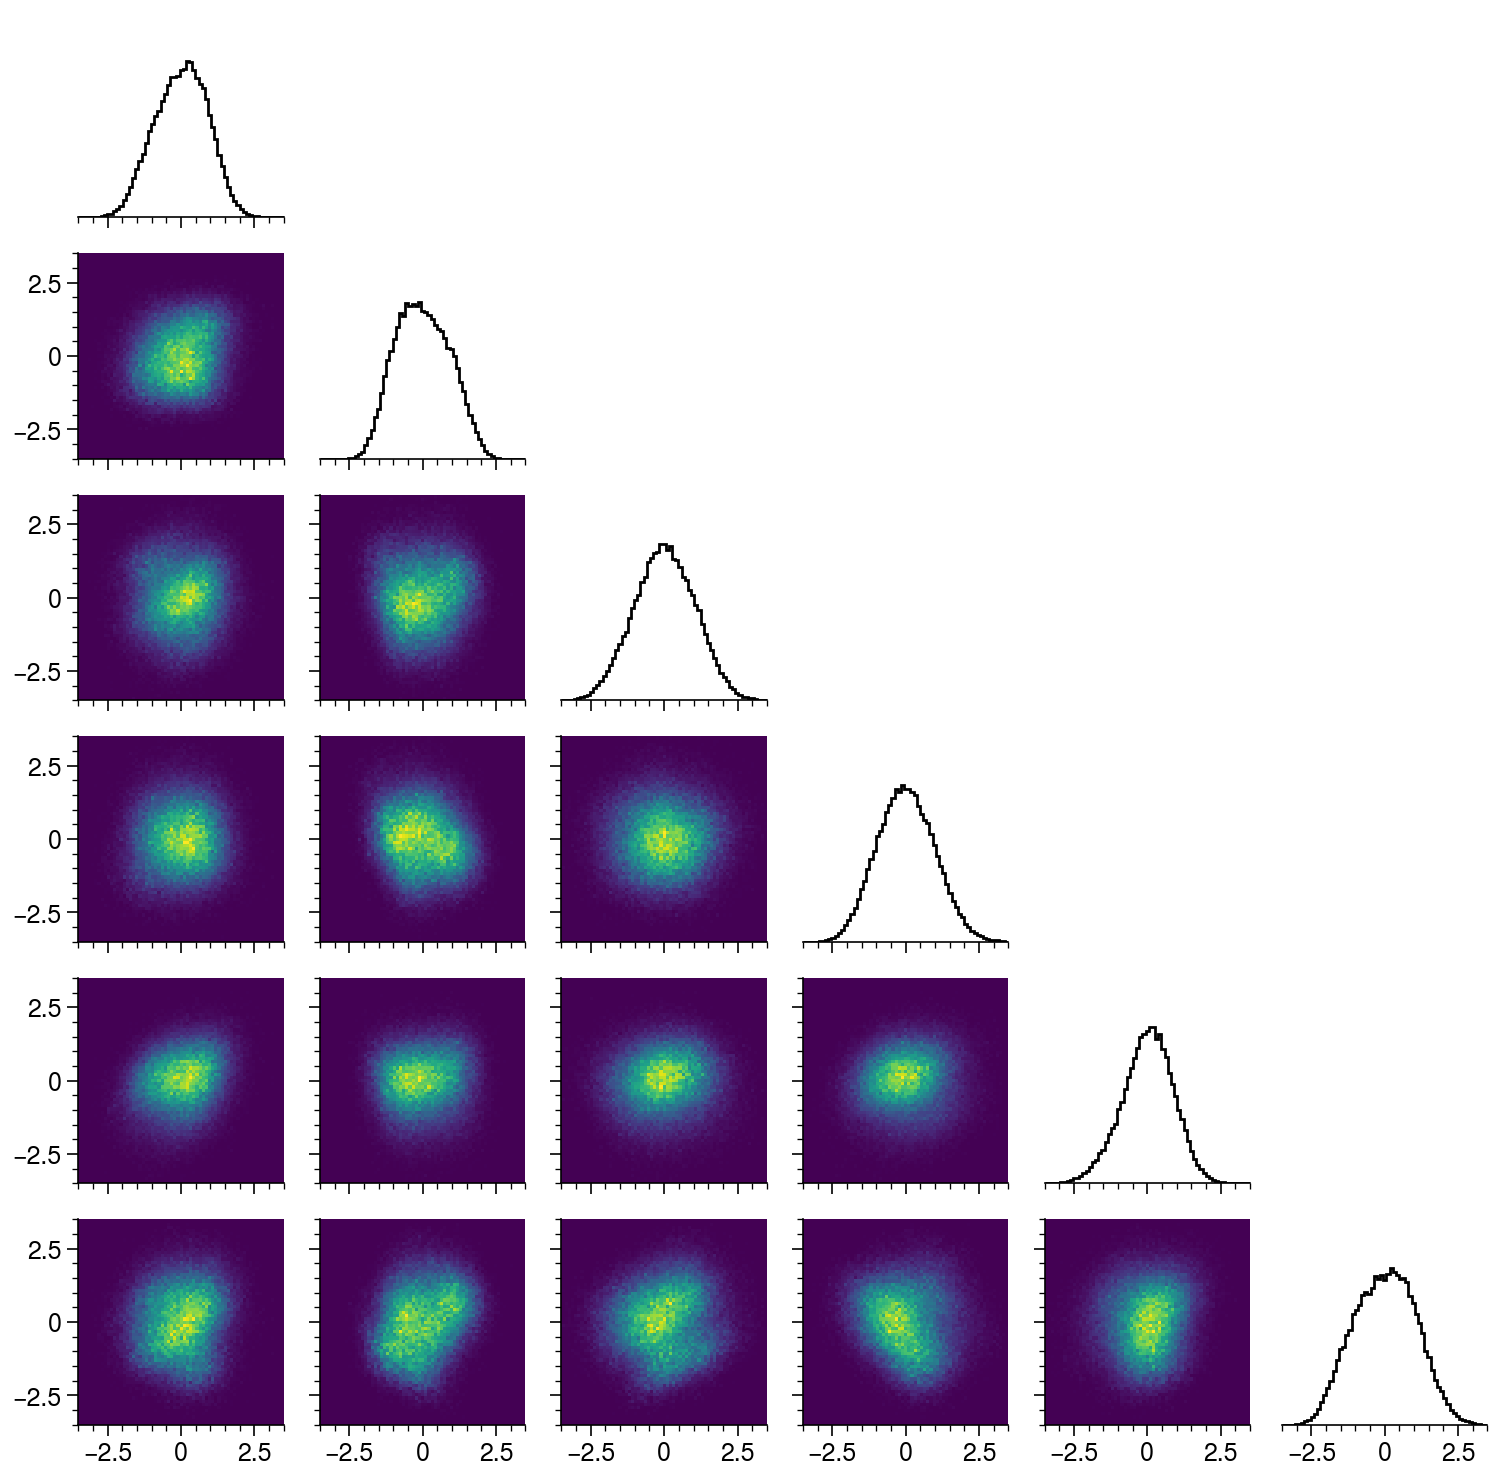

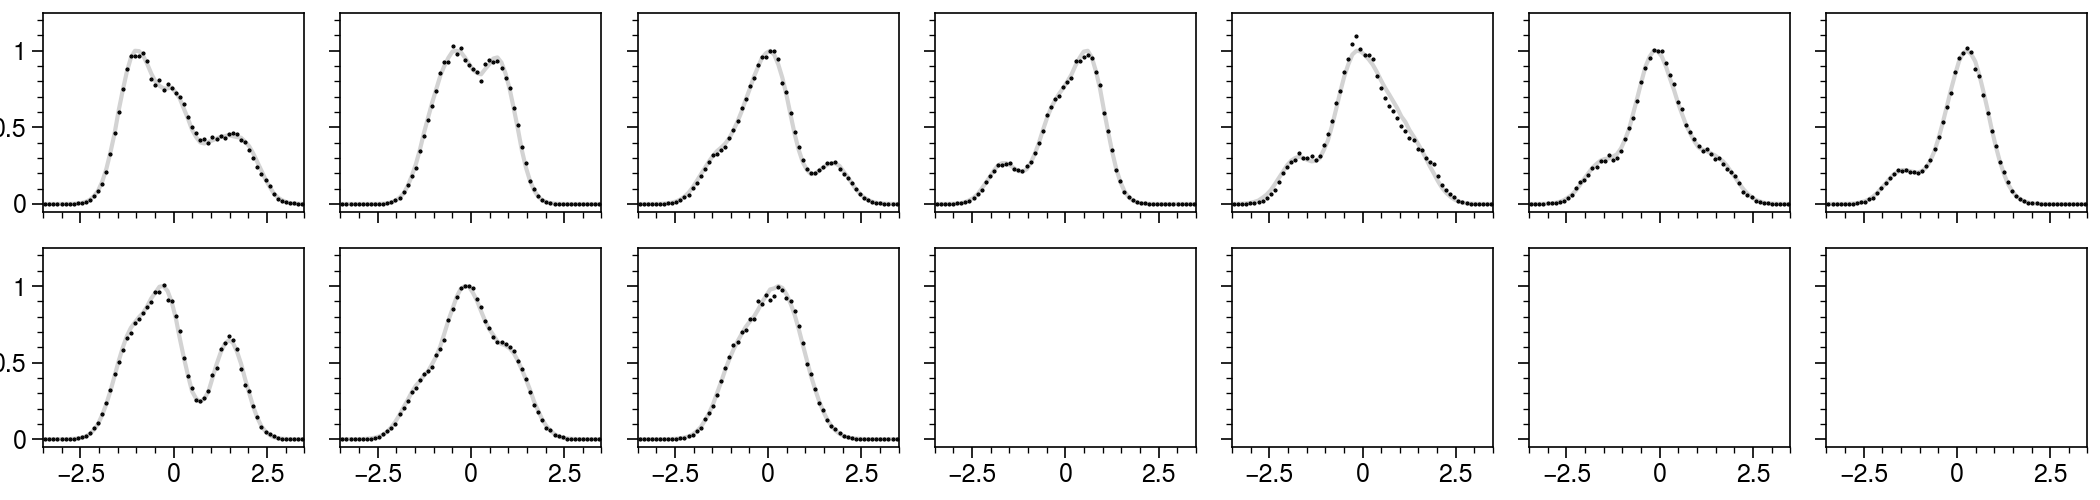

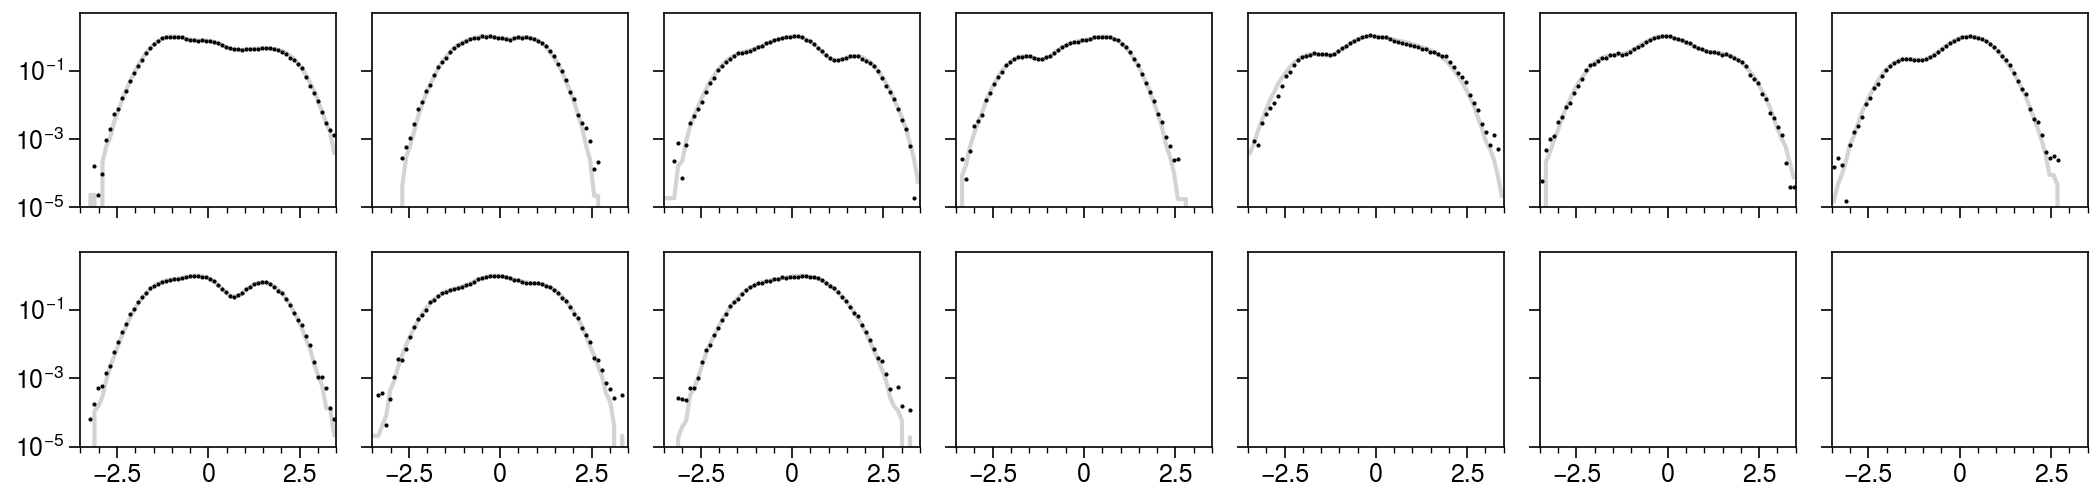

None


In [13]:
trainer = ment.train.Trainer(
    model,
    plot_func=plot_model,
    eval_func=None,
    notebook=True,
)

trainer.train(epochs=3, learning_rate=0.80)

## Evaluate

  0%|                                                                                                                          | 0/14031 [00:00<?, ?it/s]

  2%|█▊                                                                                                            | 231/14031 [00:00<00:06, 2298.72it/s]

  3%|███▌                                                                                                          | 462/14031 [00:00<00:05, 2302.14it/s]

  5%|█████▍                                                                                                        | 693/14031 [00:00<00:05, 2290.80it/s]

  7%|███████▏                                                                                                      | 923/14031 [00:00<00:05, 2282.74it/s]

  8%|████████▉                                                                                                    | 1152/14031 [00:00<00:05, 2281.58it/s]

 10%|██████████▋                                                                                                  | 1381/14031 [00:00<00:05, 2279.04it/s]

 11%|████████████▌                                                                                                | 1610/14031 [00:00<00:05, 2280.63it/s]

 13%|██████████████▎                                                                                              | 1839/14031 [00:00<00:05, 2282.81it/s]

 15%|████████████████                                                                                             | 2068/14031 [00:00<00:05, 2282.58it/s]

 16%|█████████████████▊                                                                                           | 2298/14031 [00:01<00:05, 2286.02it/s]

 18%|███████████████████▋                                                                                         | 2530/14031 [00:01<00:05, 2294.21it/s]

 20%|█████████████████████▍                                                                                       | 2760/14031 [00:01<00:04, 2295.23it/s]

 21%|███████████████████████▏                                                                                     | 2990/14031 [00:01<00:04, 2293.08it/s]

 23%|█████████████████████████                                                                                    | 3220/14031 [00:01<00:04, 2290.73it/s]

 25%|██████████████████████████▊                                                                                  | 3450/14031 [00:01<00:04, 2286.94it/s]

 26%|████████████████████████████▌                                                                                | 3679/14031 [00:01<00:04, 2284.62it/s]

 28%|██████████████████████████████▍                                                                              | 3911/14031 [00:01<00:04, 2292.81it/s]

 30%|████████████████████████████████▏                                                                            | 4142/14031 [00:01<00:04, 2296.89it/s]

 31%|█████████████████████████████████▉                                                                           | 4372/14031 [00:01<00:04, 2294.81it/s]

 33%|███████████████████████████████████▊                                                                         | 4602/14031 [00:02<00:04, 2289.51it/s]

 34%|█████████████████████████████████████▌                                                                       | 4831/14031 [00:02<00:04, 2289.01it/s]

 36%|███████████████████████████████████████▎                                                                     | 5060/14031 [00:02<00:03, 2287.96it/s]

 38%|█████████████████████████████████████████                                                                    | 5292/14031 [00:02<00:03, 2295.04it/s]

 39%|██████████████████████████████████████████▉                                                                  | 5522/14031 [00:02<00:03, 2293.24it/s]

 41%|████████████████████████████████████████████▋                                                                | 5752/14031 [00:02<00:03, 2290.99it/s]

 43%|██████████████████████████████████████████████▍                                                              | 5982/14031 [00:02<00:03, 2293.16it/s]

 44%|████████████████████████████████████████████████▎                                                            | 6212/14031 [00:02<00:03, 2293.13it/s]

 46%|██████████████████████████████████████████████████                                                           | 6442/14031 [00:02<00:03, 2291.34it/s]

 48%|███████████████████████████████████████████████████▊                                                         | 6672/14031 [00:02<00:03, 2291.13it/s]

 49%|█████████████████████████████████████████████████████▌                                                       | 6902/14031 [00:03<00:03, 2289.99it/s]

 51%|███████████████████████████████████████████████████████▍                                                     | 7133/14031 [00:03<00:03, 2295.88it/s]

 52%|█████████████████████████████████████████████████████████▏                                                   | 7363/14031 [00:03<00:02, 2294.94it/s]

 54%|██████████████████████████████████████████████████████████▉                                                  | 7593/14031 [00:03<00:02, 2295.17it/s]

 56%|████████████████████████████████████████████████████████████▊                                                | 7823/14031 [00:03<00:02, 2293.51it/s]

 57%|██████████████████████████████████████████████████████████████▌                                              | 8053/14031 [00:03<00:02, 2292.40it/s]

 59%|████████████████████████████████████████████████████████████████▎                                            | 8283/14031 [00:03<00:02, 2291.27it/s]

 61%|██████████████████████████████████████████████████████████████████▏                                          | 8513/14031 [00:03<00:02, 2291.53it/s]

 62%|███████████████████████████████████████████████████████████████████▉                                         | 8745/14031 [00:03<00:02, 2297.90it/s]

 64%|█████████████████████████████████████████████████████████████████████▋                                       | 8975/14031 [00:03<00:02, 2295.77it/s]

 66%|███████████████████████████████████████████████████████████████████████▌                                     | 9205/14031 [00:04<00:02, 2294.97it/s]

 67%|█████████████████████████████████████████████████████████████████████████▎                                   | 9435/14031 [00:04<00:02, 2290.49it/s]

 69%|███████████████████████████████████████████████████████████████████████████                                  | 9667/14031 [00:04<00:01, 2296.78it/s]

 71%|████████████████████████████████████████████████████████████████████████████▉                                | 9901/14031 [00:04<00:01, 2307.19it/s]

 72%|██████████████████████████████████████████████████████████████████████████████                              | 10135/14031 [00:04<00:01, 2314.42it/s]

 74%|███████████████████████████████████████████████████████████████████████████████▊                            | 10367/14031 [00:04<00:01, 2303.68it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████▌                          | 10598/14031 [00:04<00:01, 2284.85it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████▎                        | 10827/14031 [00:04<00:01, 2284.82it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████                       | 11056/14031 [00:04<00:01, 2285.28it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████▊                     | 11285/14031 [00:04<00:01, 2282.31it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████▋                   | 11515/14031 [00:05<00:01, 2284.68it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████▍                 | 11744/14031 [00:05<00:01, 2265.55it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████▏               | 11971/14031 [00:05<00:00, 2245.57it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████▉              | 12203/14031 [00:05<00:00, 2266.34it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████▋            | 12438/14031 [00:05<00:00, 2291.03it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████▌          | 12673/14031 [00:05<00:00, 2306.55it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████▍        | 12916/14031 [00:05<00:00, 2343.04it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 13155/14031 [00:05<00:00, 2356.79it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████     | 13391/14031 [00:05<00:00, 2353.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 13628/14031 [00:05<00:00, 2356.84it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 13864/14031 [00:06<00:00, 2345.77it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14031/14031 [00:06<00:00, 2297.16it/s]

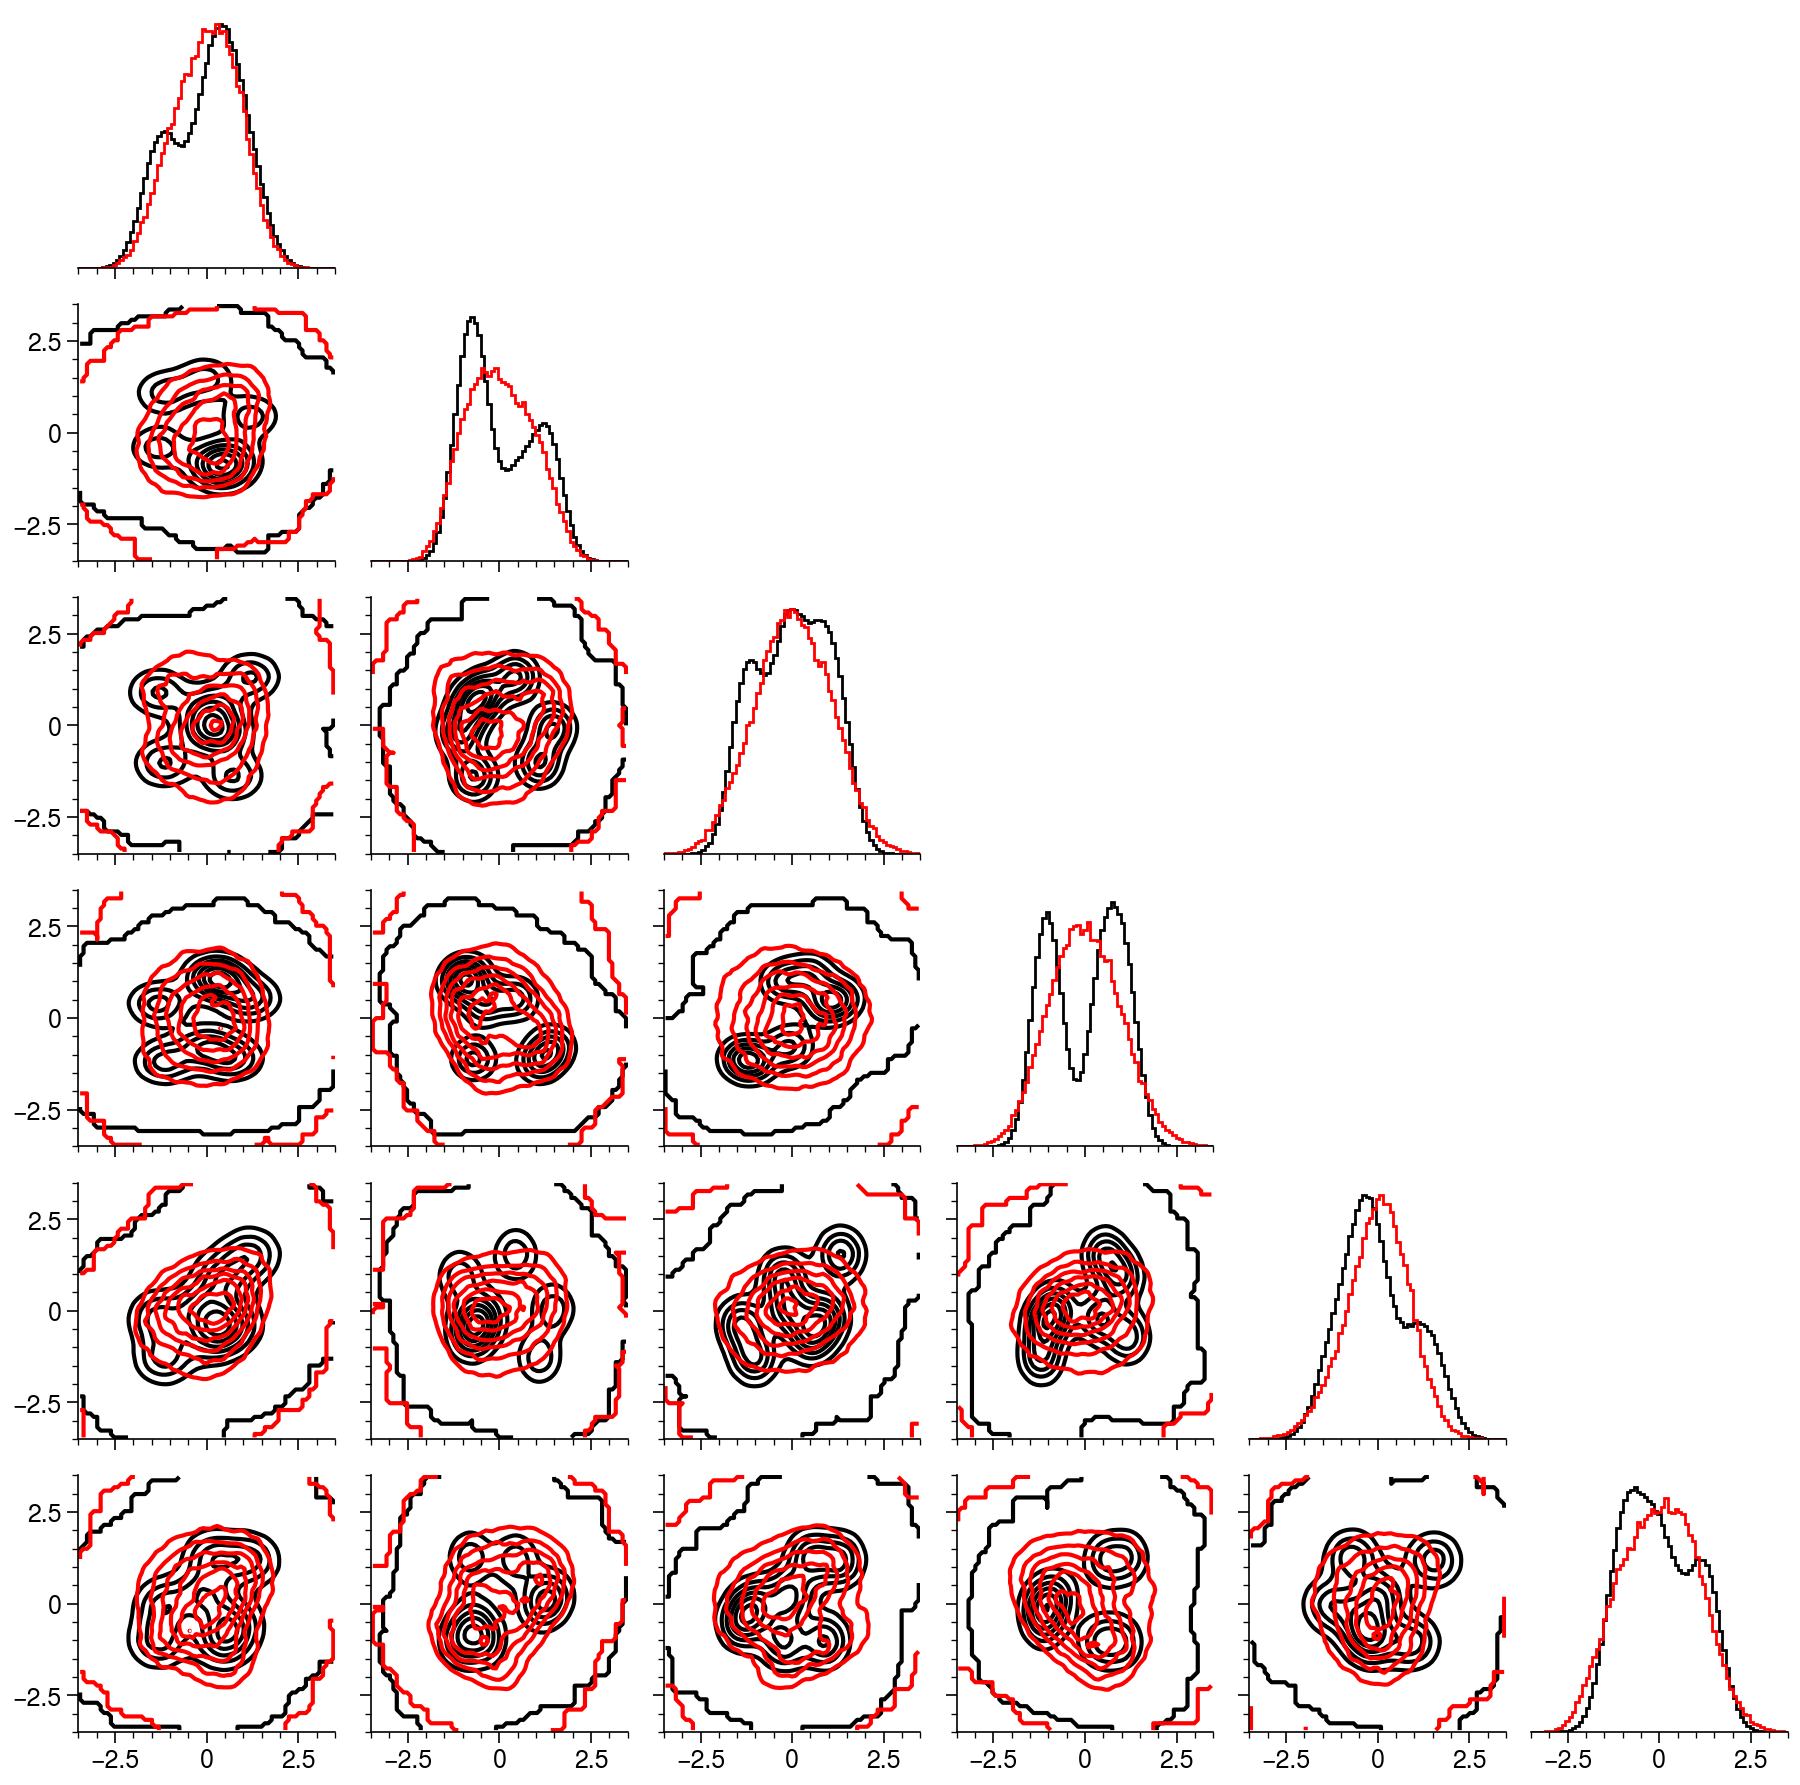

In [14]:
x_pred = model.unnormalize(model.sample(1_000_000))

grid = psv.CornerGrid(ndim, figwidth=(ndim * 1.5))
for x, color in zip([x_true, x_pred], ["black", "red"]):
    grid.plot(
        x,
        limits=limits,
        bins=75,
        diag_kws=dict(color=color),
        mask=False,
        kind="contour",
        process_kws=dict(blur=1.0),
        color=color,
        N=7,
    )
plt.show()